In [ ]:
from huggingface_hub import hf_hub_download
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import os
from collections import Counter
import re

# Training

In [ ]:
path = hf_hub_download(
    repo_id="Arnab-Datta-240185/CS779-Capstone-Project",
    filename=f"train_data1.json",
    repo_type="dataset"
)

In [451]:
with open(path, "r") as file:
    data = json.load(file)

In [452]:
import matplotlib as mpl
from matplotlib import font_manager
def plot_top(top, type, script="Devanagari"):
    font_manager.fontManager.addfont("/usr/share/fonts/truetype/noto/NotoSans-Regular.ttf")
    font_manager.fontManager.addfont("/usr/share/fonts/truetype/noto/NotoSansDevanagari-Regular.ttf")
    font_manager.fontManager.addfont("/usr/share/fonts/truetype/noto/NotoSansBengali-Regular.ttf")

    # Set font family preference list (Latin first, then Devanagari fallback)
    plt.rcParams["font.family"] = [
        "Noto Sans",              # English, Latin
        f"Noto Sans {script}"
    ]
    labels, freqs = zip(*top)
    plt.figure(figsize=(24,12))
    plt.bar(labels, freqs)
    plt.xticks(rotation=90)
    plt.xlabel(f"{type} ---->",fontsize=14)
    plt.ylabel("Frequency ---->",fontsize=14)
    plt.title(f"{type} Frequency Histogram",fontsize=20)
    plt.margins(x=0)
    plt.tight_layout()
    plt.show()
    mpl.rcdefaults()

In [453]:
def plot_sentence_length_distribution(counts):
    """
    Plot histogram of sentence lengths.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(counts, bins=30, edgecolor='black', alpha=0.7)
    plt.title("Sentence Length Distribution")
    plt.xlabel("Sentence length (tokens)")
    plt.ylabel("Frequency")
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

In [454]:
def entropy(counter):
    total = sum(counter.values())
    ps = np.array([c/total for c in counter.values() if c>0], dtype=np.float64)
    return float(-(ps * np.log2(ps + 1e-12)).sum())

In [455]:
def plot_zipf(counter, title):
    freqs = np.array(sorted(counter.values(), reverse=True), dtype=np.float64)
    ranks = np.arange(1, len(freqs)+1, dtype=np.float64)
    plt.figure(figsize=(6,4))
    plt.loglog(ranks, freqs, marker='.')
    plt.xlabel("Rank (log)"); plt.ylabel("Frequency (log)"); plt.title(title)
    plt.grid(True, ls='--', alpha=0.4); plt.tight_layout(); plt.show()


In [456]:
def frac_in_block(text, start, end):
    n = len(text); 
    if n == 0: return 0.0
    return sum(1 for ch in text if start <= ord(ch) <= end) / n

BLOCKS = {
    "Bengali":   (0x0980, 0x09FF),
    "Hindi":     (0x0900, 0x097F),  # Devanagari
    "Latin":     (0x0000, 0x007F),
}

def script_purity(df, lang):
    bl = BLOCKS.get(lang, None)
    lat = BLOCKS["Latin"]
    if bl is None:
        print("Unknown language block")
        return
    tgt_frac_lang = np.array([frac_in_block(t, bl[0], bl[1]) for t in df["target"]])
    tgt_frac_lat  = np.array([frac_in_block(t, lat[0], lat[1]) for t in df["target"]])
    print(f"Target mean frac in {lang} block: {tgt_frac_lang.mean():.3f}")
    print(f"Target mean frac in Latin block:  {tgt_frac_lat.mean():.3f}")

    plt.figure(figsize=(6,3))
    plt.hist(tgt_frac_lang, bins=30, alpha=0.8, edgecolor='k')
    plt.xlabel(f"Fraction of chars in {lang} block"); plt.ylabel("Count"); plt.title("Script purity (target)")
    plt.tight_layout(); plt.show()

## Bengali

In [457]:
lang="Bengali"

In [458]:
des=pd.DataFrame(data[f"English-{lang}"]["Train"]).T
des.head(10)

,source,target
78683,Do not forget to visit the point where the Nar...,এই জায়গাগুলো দেখতে ভুলো না যেখানে নর্মদা নদী ম...
78684,It is evident that the biggest cause of povert...,এই কথা স্পষ্ট যে দরিদ্রতার বড় কারণ হল অশিক্ষা ।
78685,The film was released theatrically on 12 April...,চলচ্চিত্রটি ২০১৩ সালের ১২ই এপ্রিল প্রেক্ষাগৃহে...
78686,is wyatt's birthday party at ten p. m.,অনিমেষ এর জন্মদিনের পার্টি রাত দশটায়
78687,"Apart from being used as an eatable, barley is...",খাদ্যদ্রব্য ছাড়াও যব আরো বিভিন্ন ক্ষেত্রে যেমন...
78688,Emperor Akbar got the State Museum constructed...,রাজকীয় সংগ্রহালয়ের নির্মাণ সম্রাট আকবর নিজের...
78689,initiate the music on the electronic playlist,ইলেক্ট্রনিক প্লেলিস্টের গানগুলো শুরু কর
78690,Srinagar is at a distance of 305 kms from Jammu .,জম্মু থেকে শ্রীনগরের দূরত্ব হল ৩০৫ কি.মি. ৷
78691,A devotee is chosen and a Karaga or a clay pot...,একটি ভক্ত বাছা হয়েছিল এবং একটি কারাগা অথবা একট...
78692,The city is lined up with shops that have ever...,শহরটিতে আপনার রান্নাঘর ভর্তি করার জন্য দোকান স...


Target mean frac in Bengali block: 0.827
Target mean frac in Latin block:  0.164


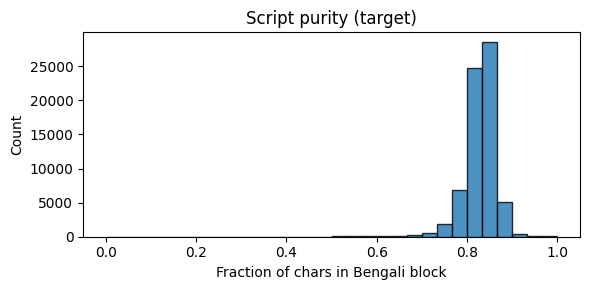

In [459]:
script_purity(des, lang)

In [460]:
print("Size of dataset",len(des))

Size of dataset 68849


### Unique Words

Unique English Words: 90192


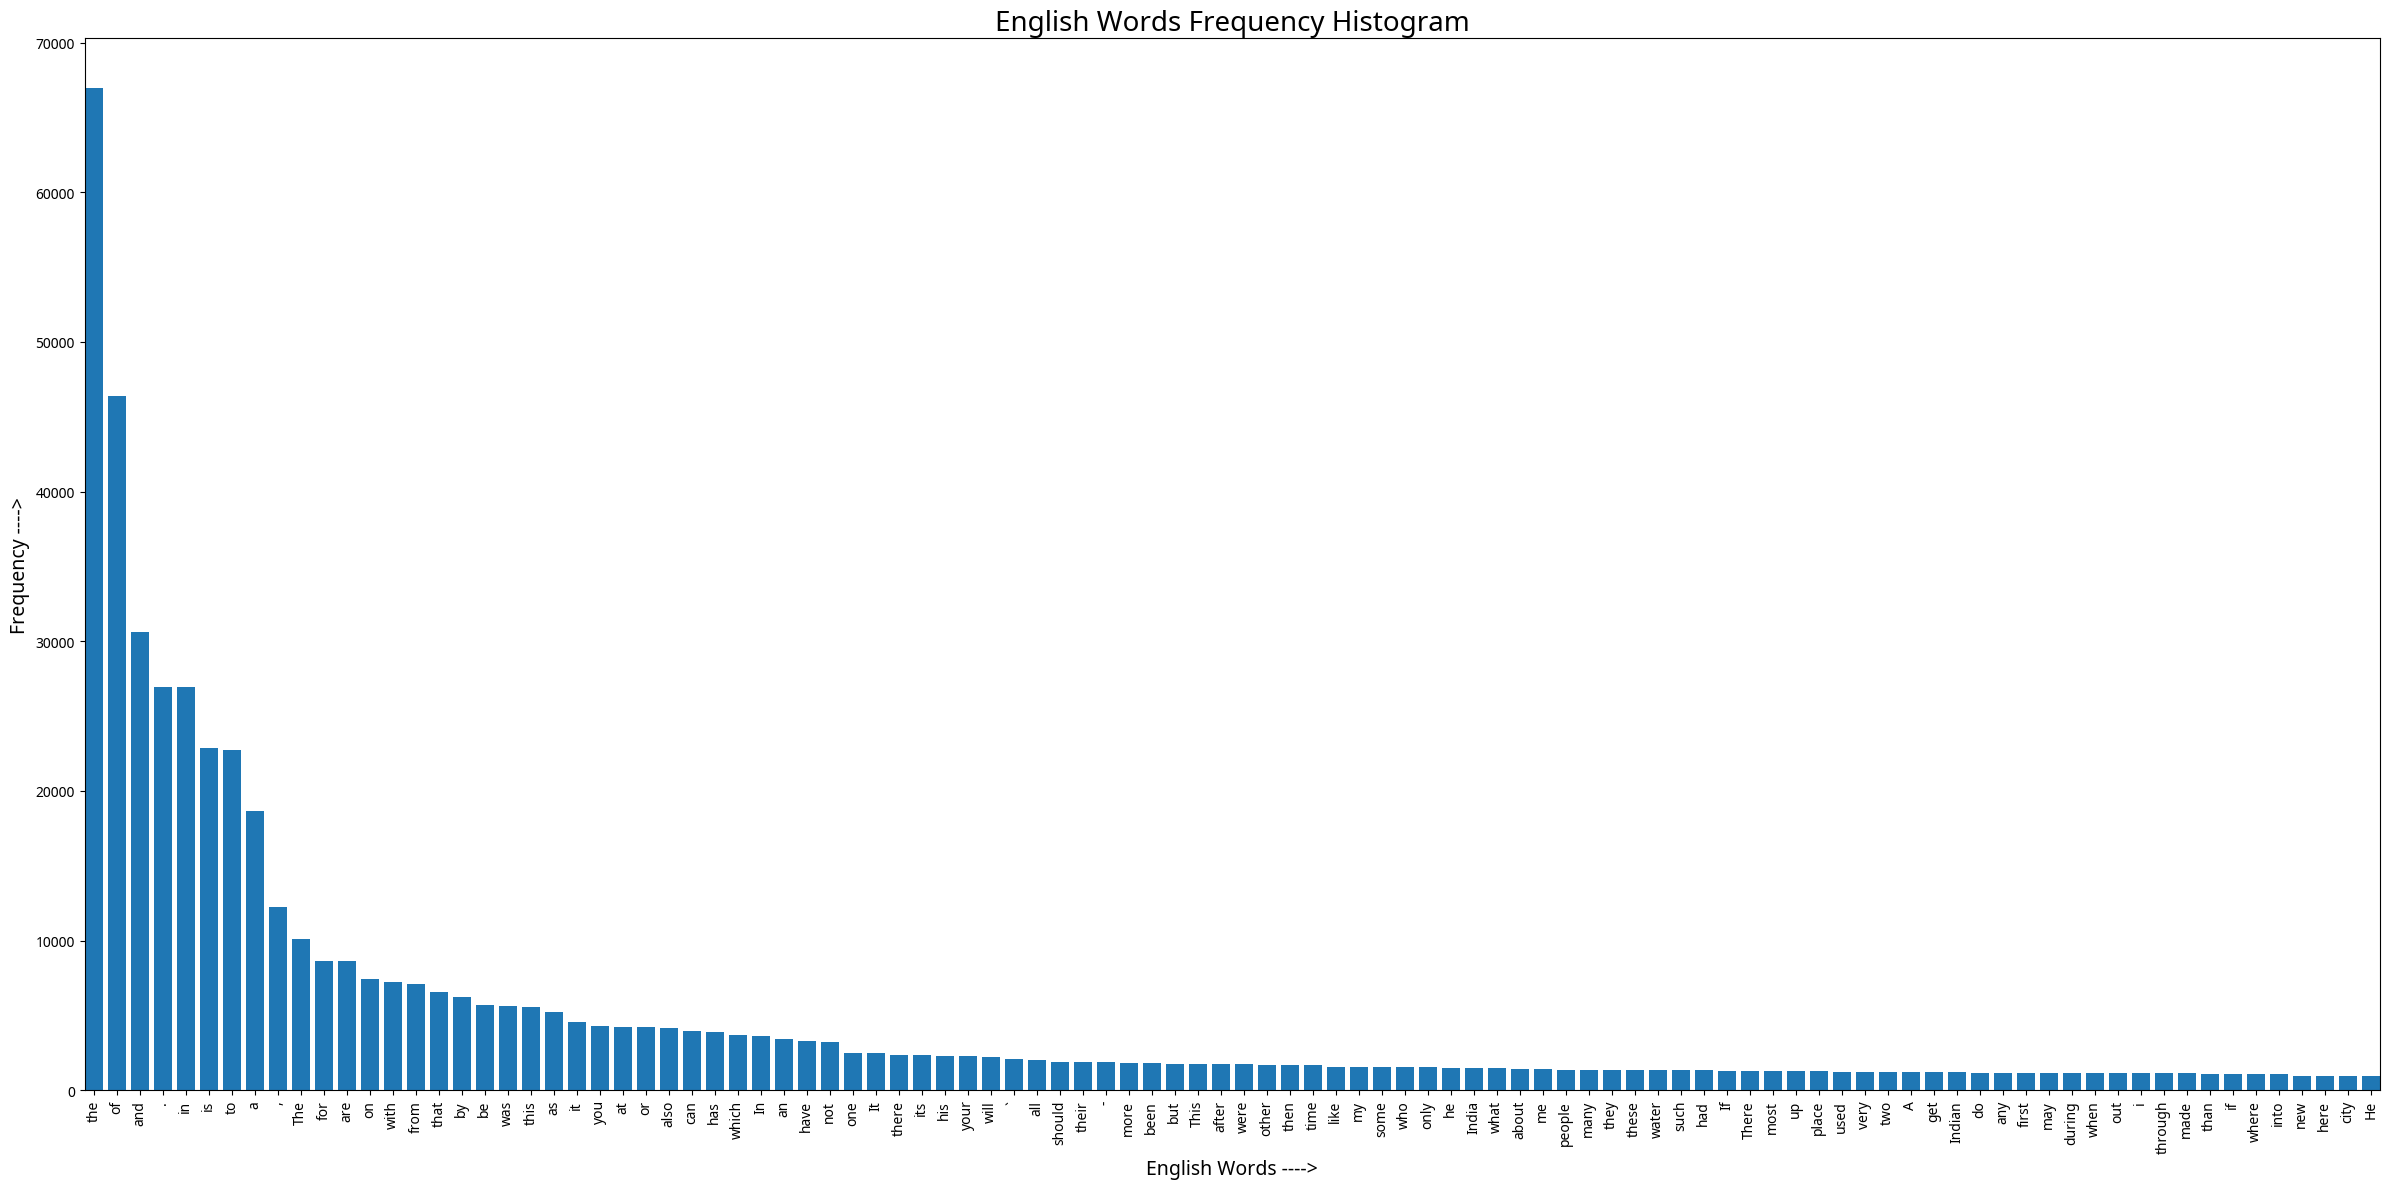

In [461]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 57158


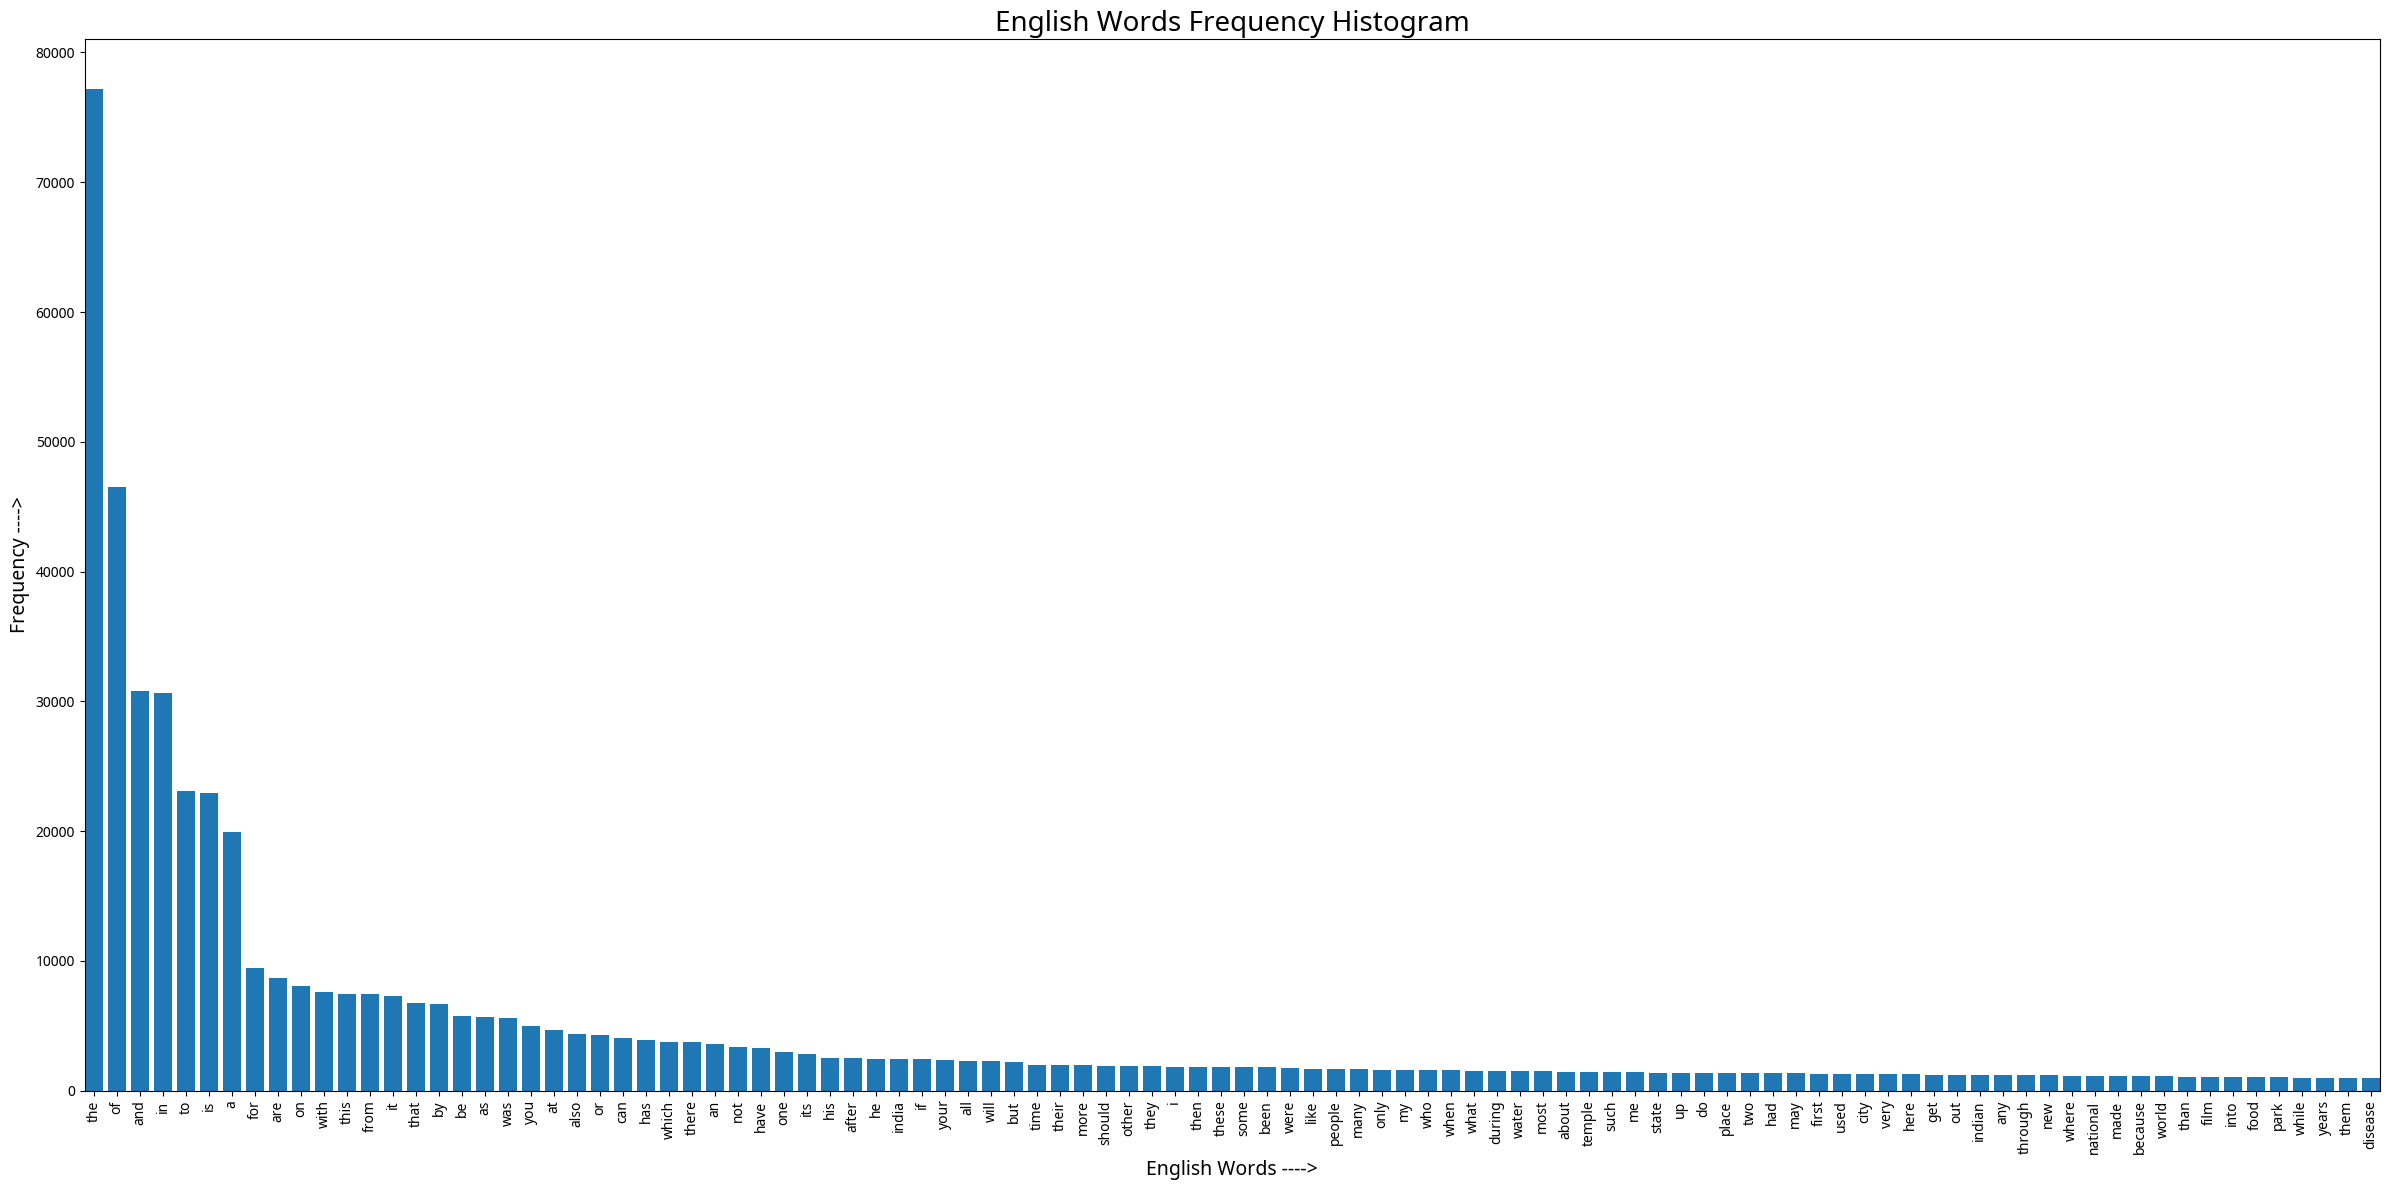

In [462]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

Unique Bengali Words: 116759


/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 1472 (\N{HEBREW PUNCTUATION PASEQ}) missing from font(s) Noto Sans, Noto Sans Bengali.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Matplotlib currently does not support Hebrew natively.
  plt.tight_layout()
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1472 (\N{HEBREW PUNCTUATION PASEQ}) missing from font(s) Noto Sans, Noto Sans Bengali.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Hebrew natively.
  fig.canvas.print_figure(bytes_io, **kw)


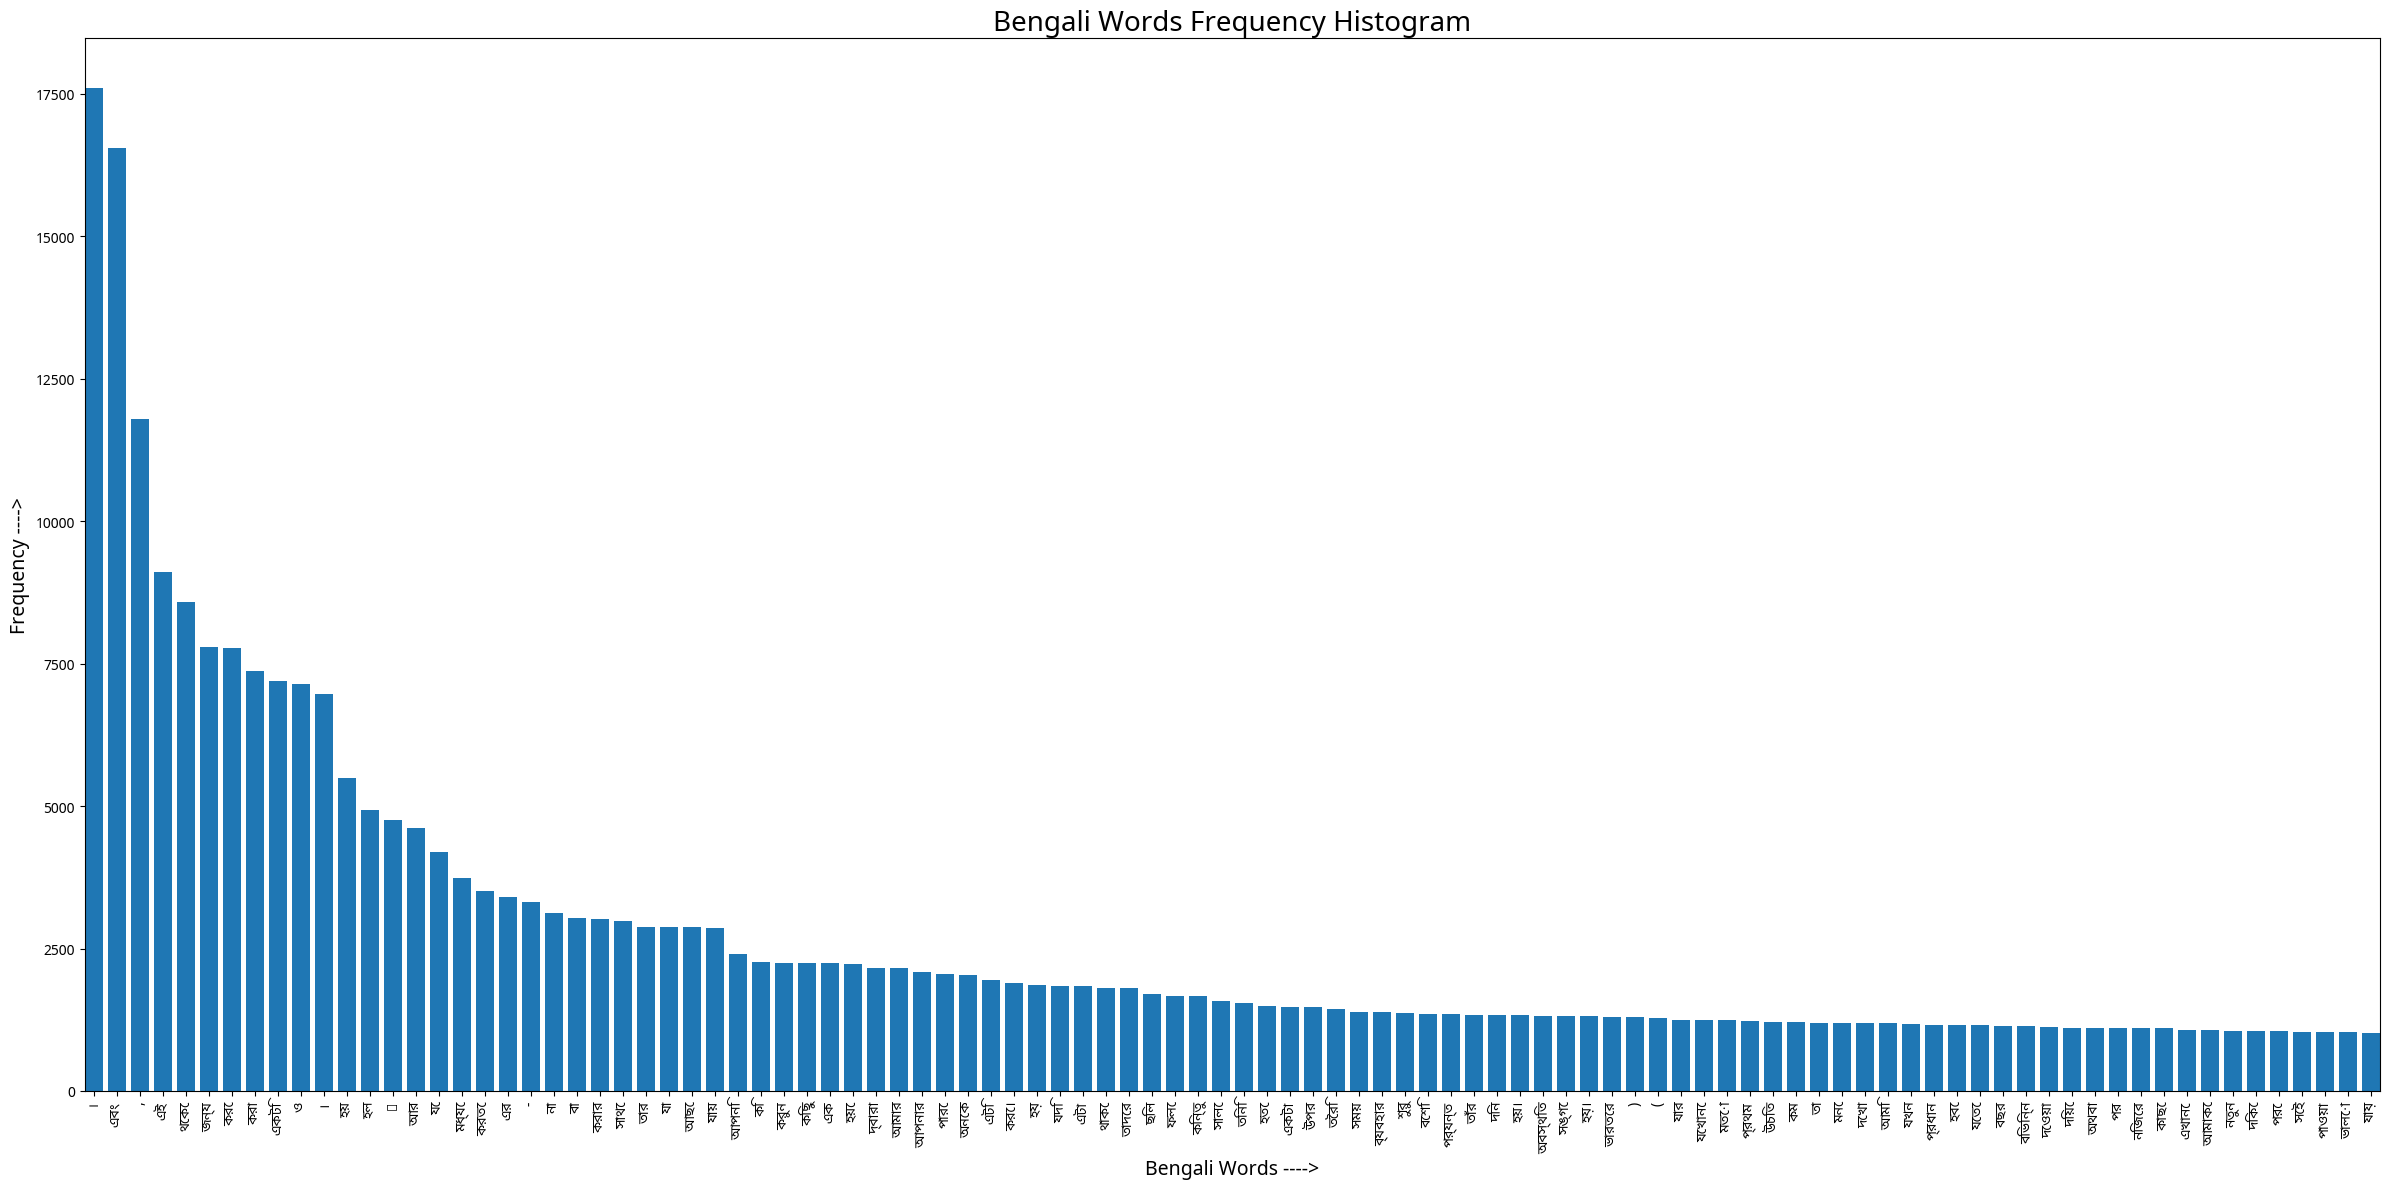

In [463]:
des_des=Counter((" ".join(list(des["target"]))).split())
print(f"Unique {lang} Words:",len(des_des))
plot_top(des_des.most_common(100),f"{lang} Words",lang)

The above error indicates the presence of the Hebrew punctuation `׀` in the dataset. In the output prediction of my model, it appears many places instead of the bengali fullstop `৷`

### Entropy

In [464]:
print("Source entropy:",entropy(des_eng))
print(f"{lang} entropy:",entropy(des_des))

Source entropy: 11.170675345238514
Bengali entropy: 12.723375097149363


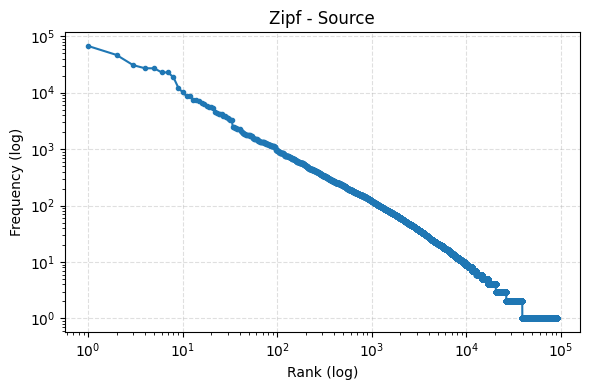

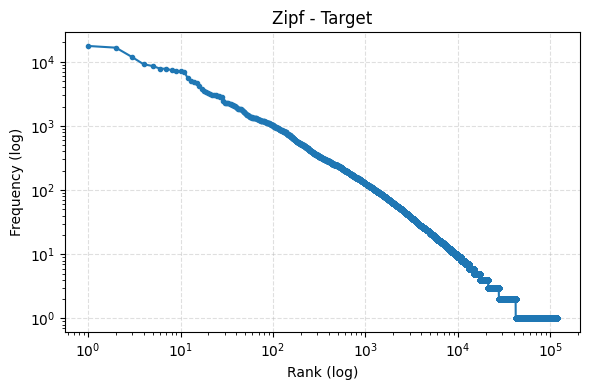

In [465]:
plot_zipf(des_eng, "Zipf - Source")
plot_zipf(des_des, "Zipf - Target")

### Unique Characters

Unique English Characters: 238


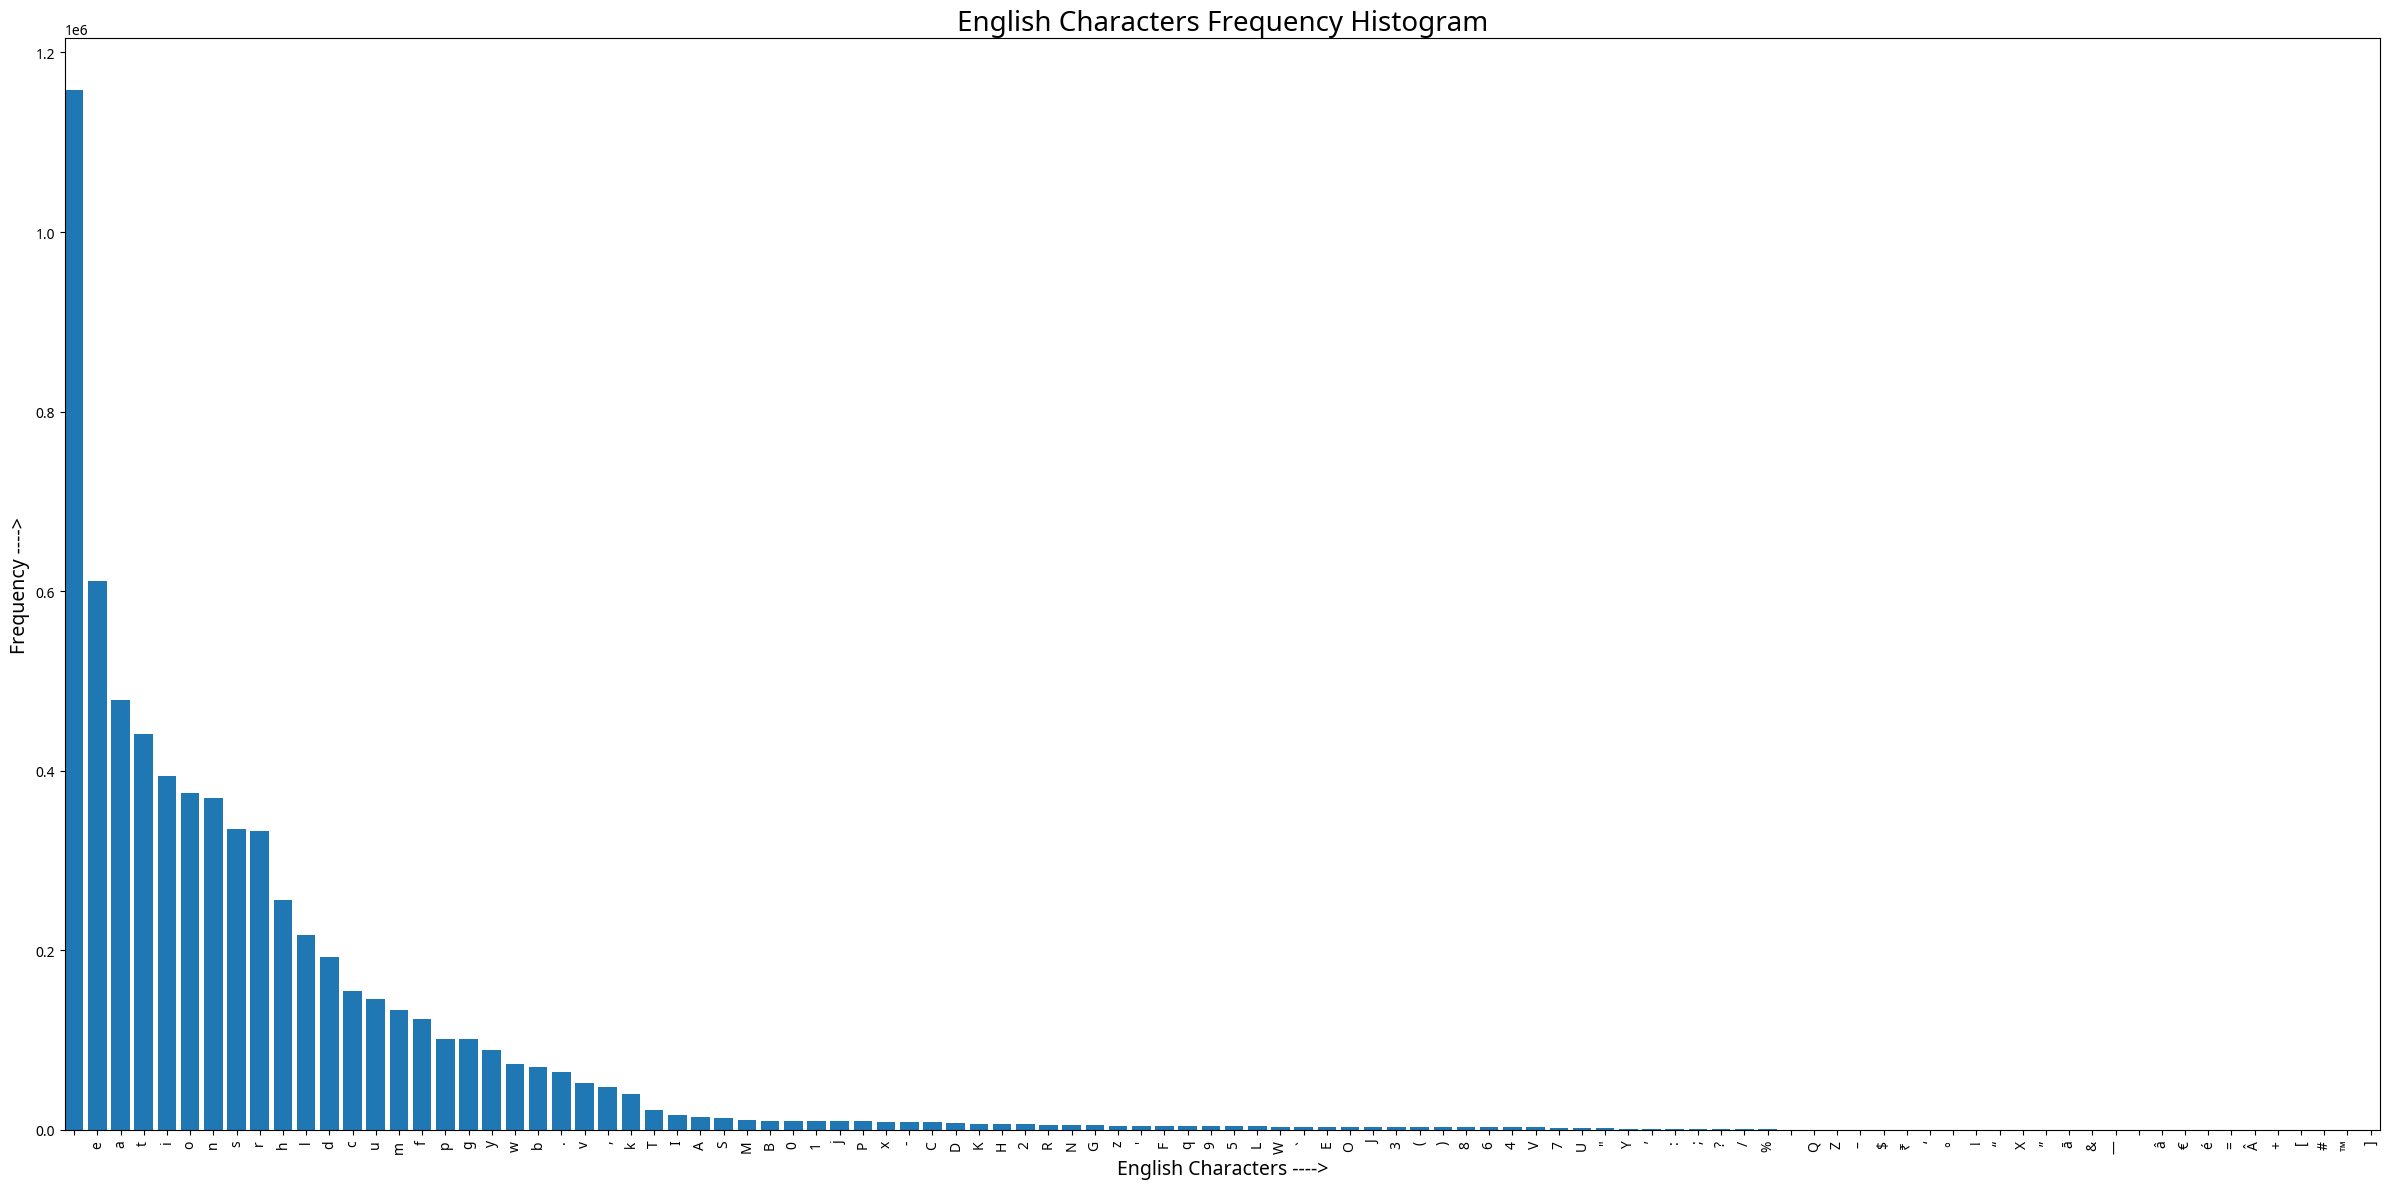

In [466]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

Unique Bengali Characters: 210


/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 1472 (\N{HEBREW PUNCTUATION PASEQ}) missing from font(s) Noto Sans, Noto Sans Bengali.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Matplotlib currently does not support Hebrew natively.
  plt.tight_layout()
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 1472 (\N{HEBREW PUNCTUATION PASEQ}) missing from font(s) Noto Sans, Noto Sans Bengali.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Hebrew natively.
  fig.canvas.print_figure(bytes_io, **kw)


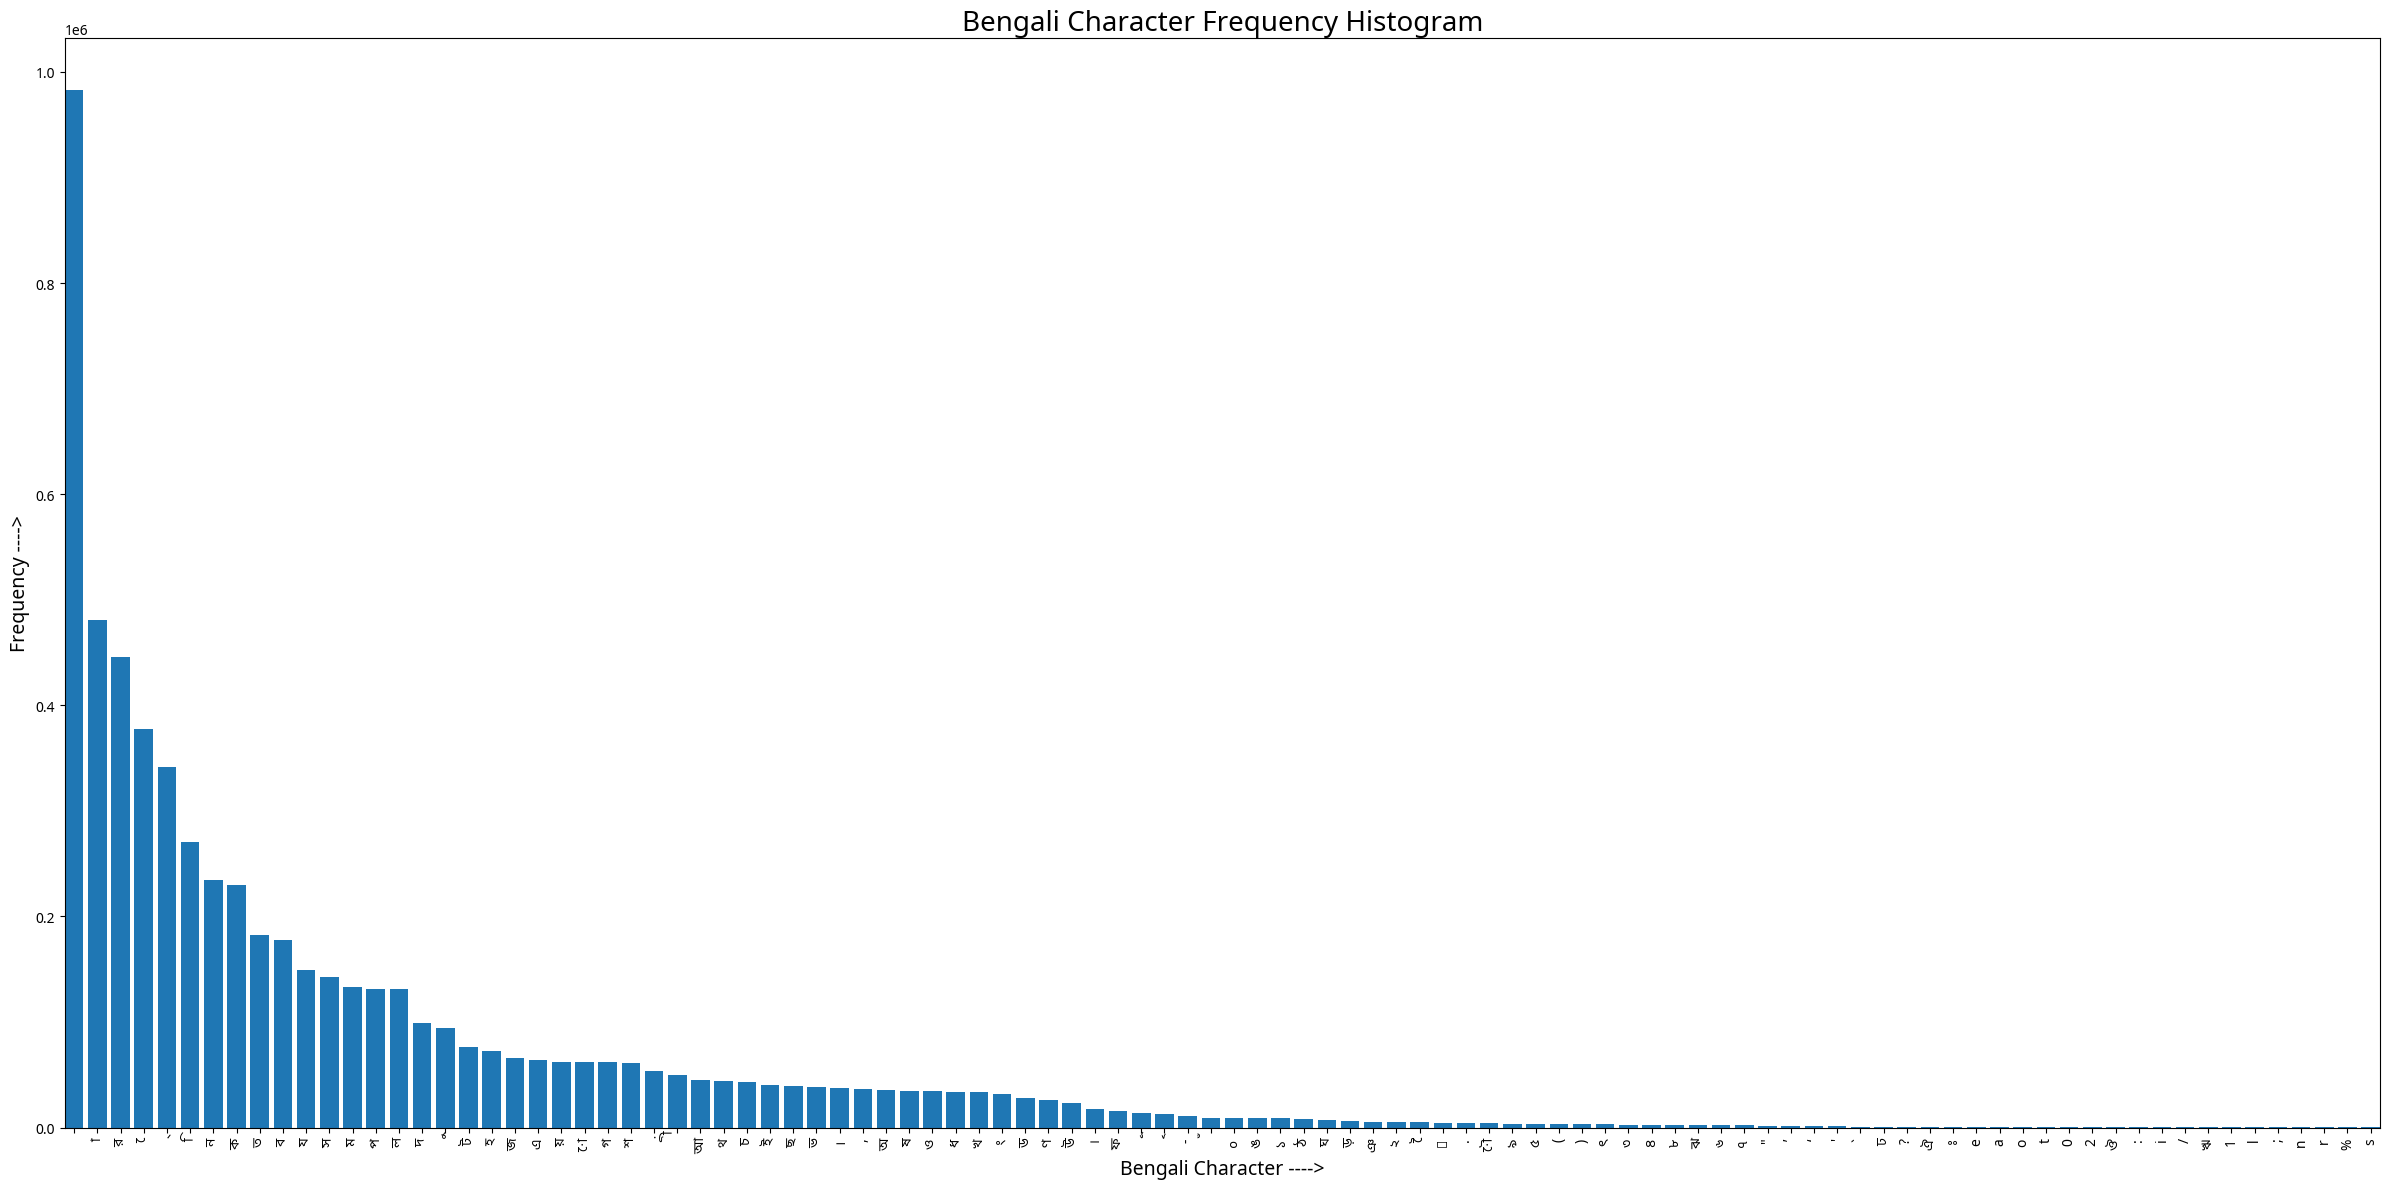

In [467]:
des_des_char=Counter((" ".join(list(des["target"]))))
print(f"Unique {lang} Characters:",len(des_des_char))
plot_top(des_des_char.most_common(100),f"{lang} Character",lang)

### Sentence Length

Average English Sentence Length: 16.823033014277623 words


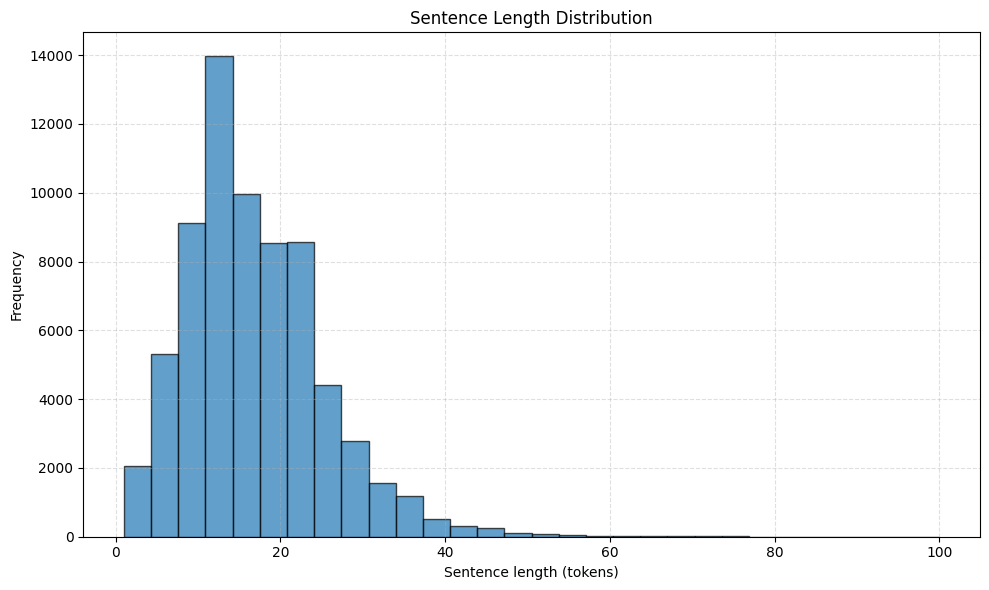

In [468]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

Average Bengali Sentence Length: 14.272422257403884 words


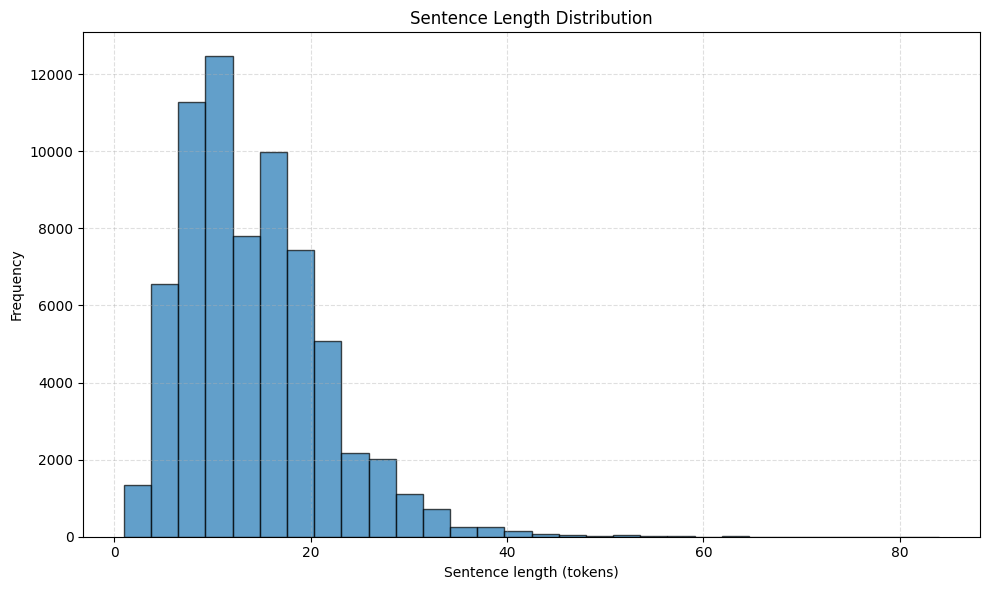

In [469]:
des_des_sent=[len(sent.split()) for sent in des["target"]]
print(f"Average {lang} Sentence Length:",sum(des_des_sent)/len(des_des_sent),"words")
plot_sentence_length_distribution(des_des_sent)

In [470]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))
print(f"{lang} sentence length entropy:",entropy(Counter(des_des_sent)))

Source sentence length entropy: 4.997552413085854
Bengali sentence length entropy: 4.762091775981674


### Numerals

Total Latin Script Numeral in dataset: 49228


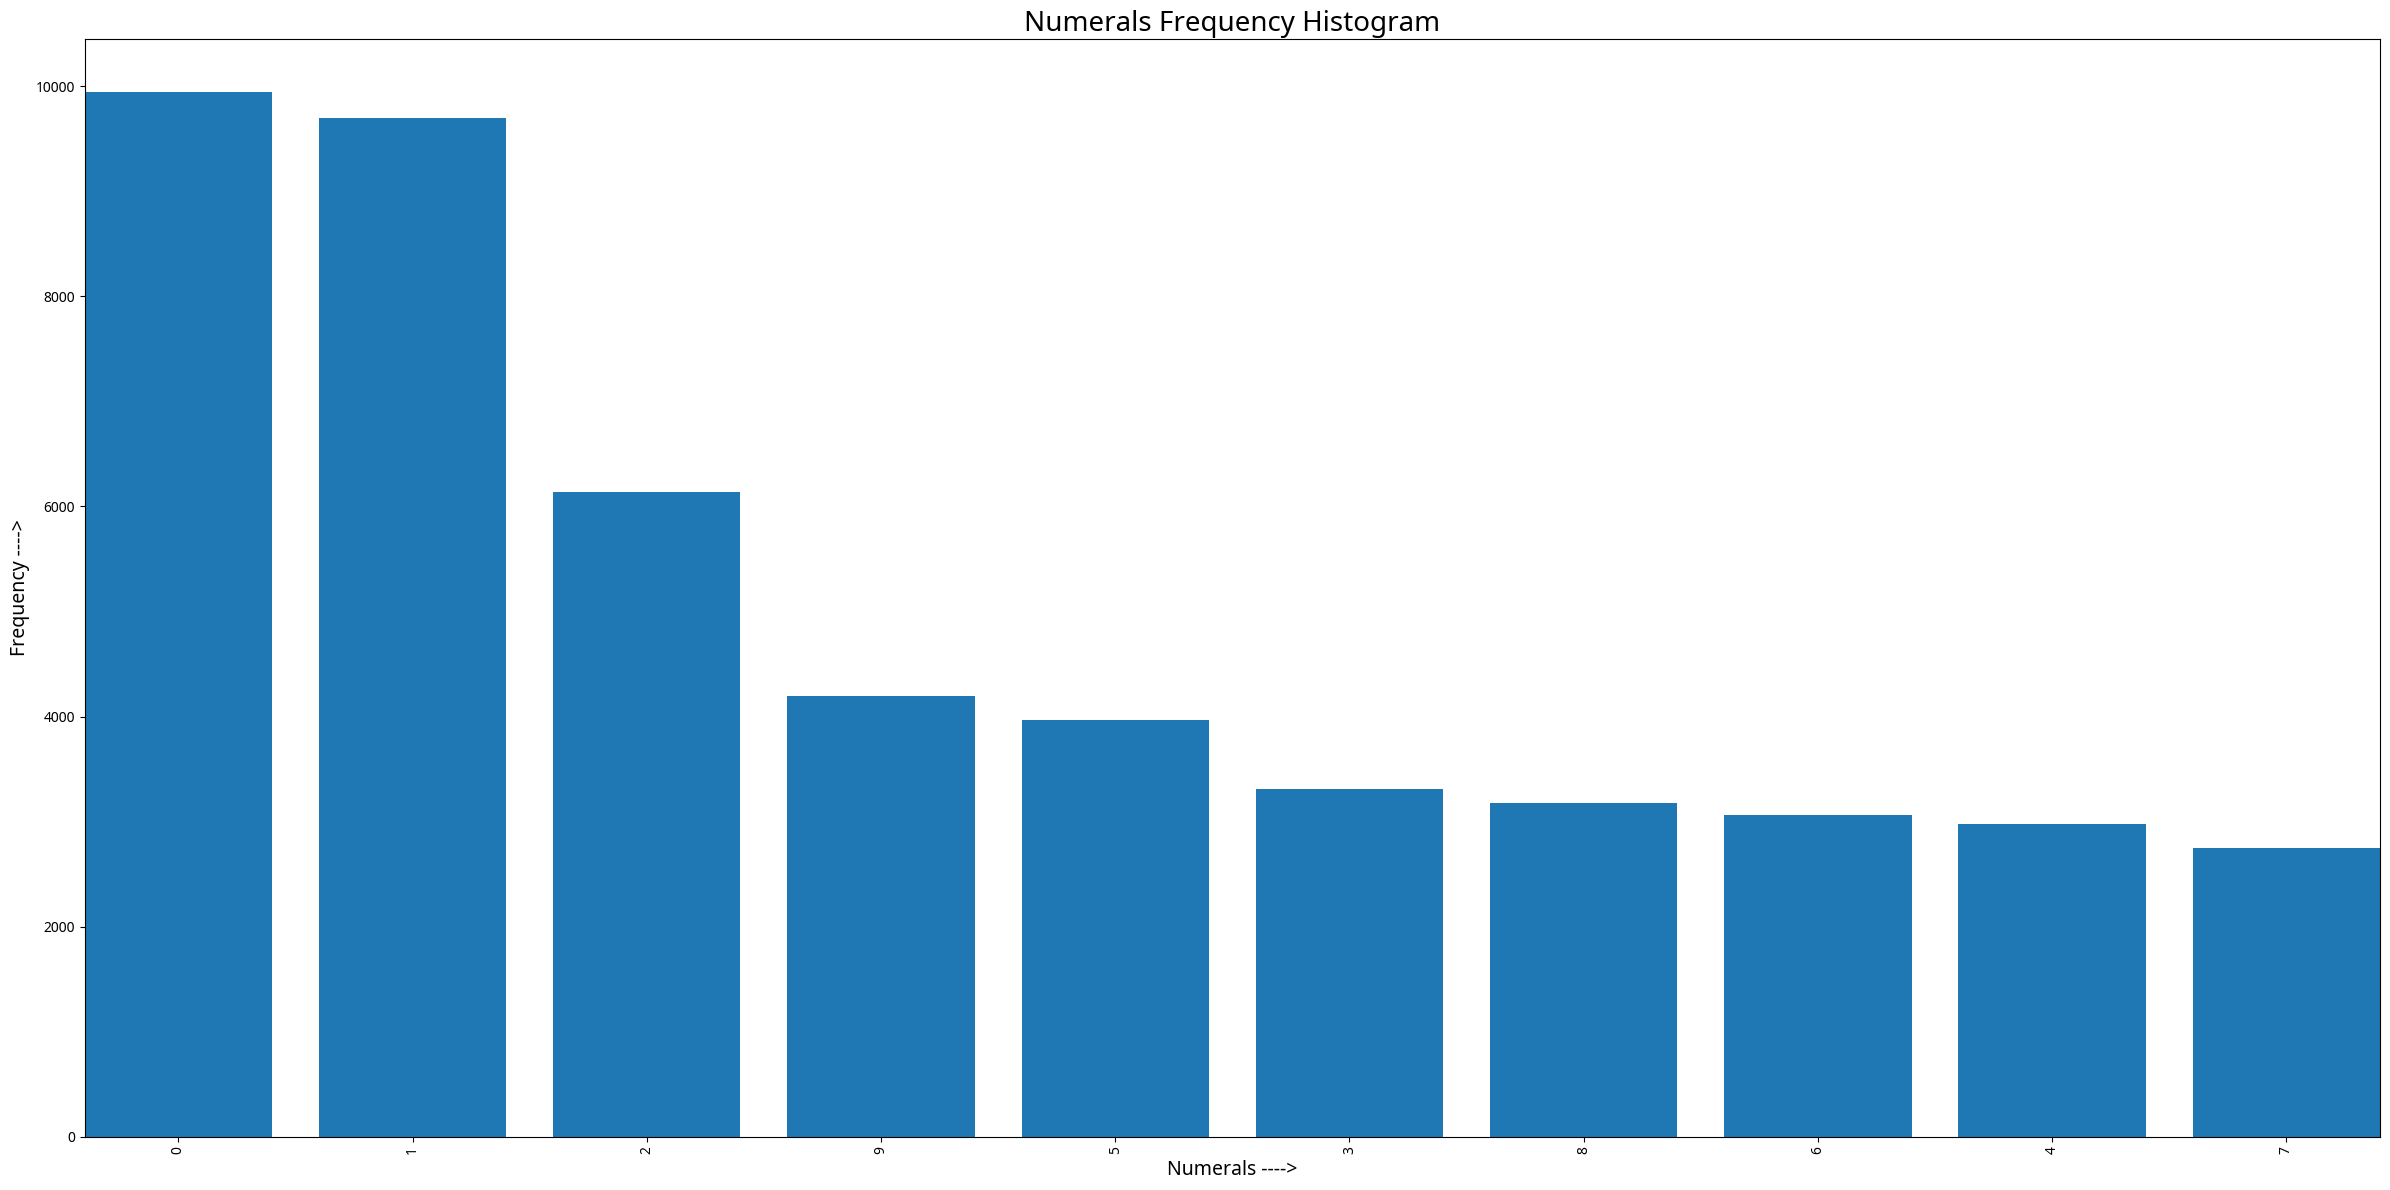

In [471]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")


Total Numeral in dataset: 47807


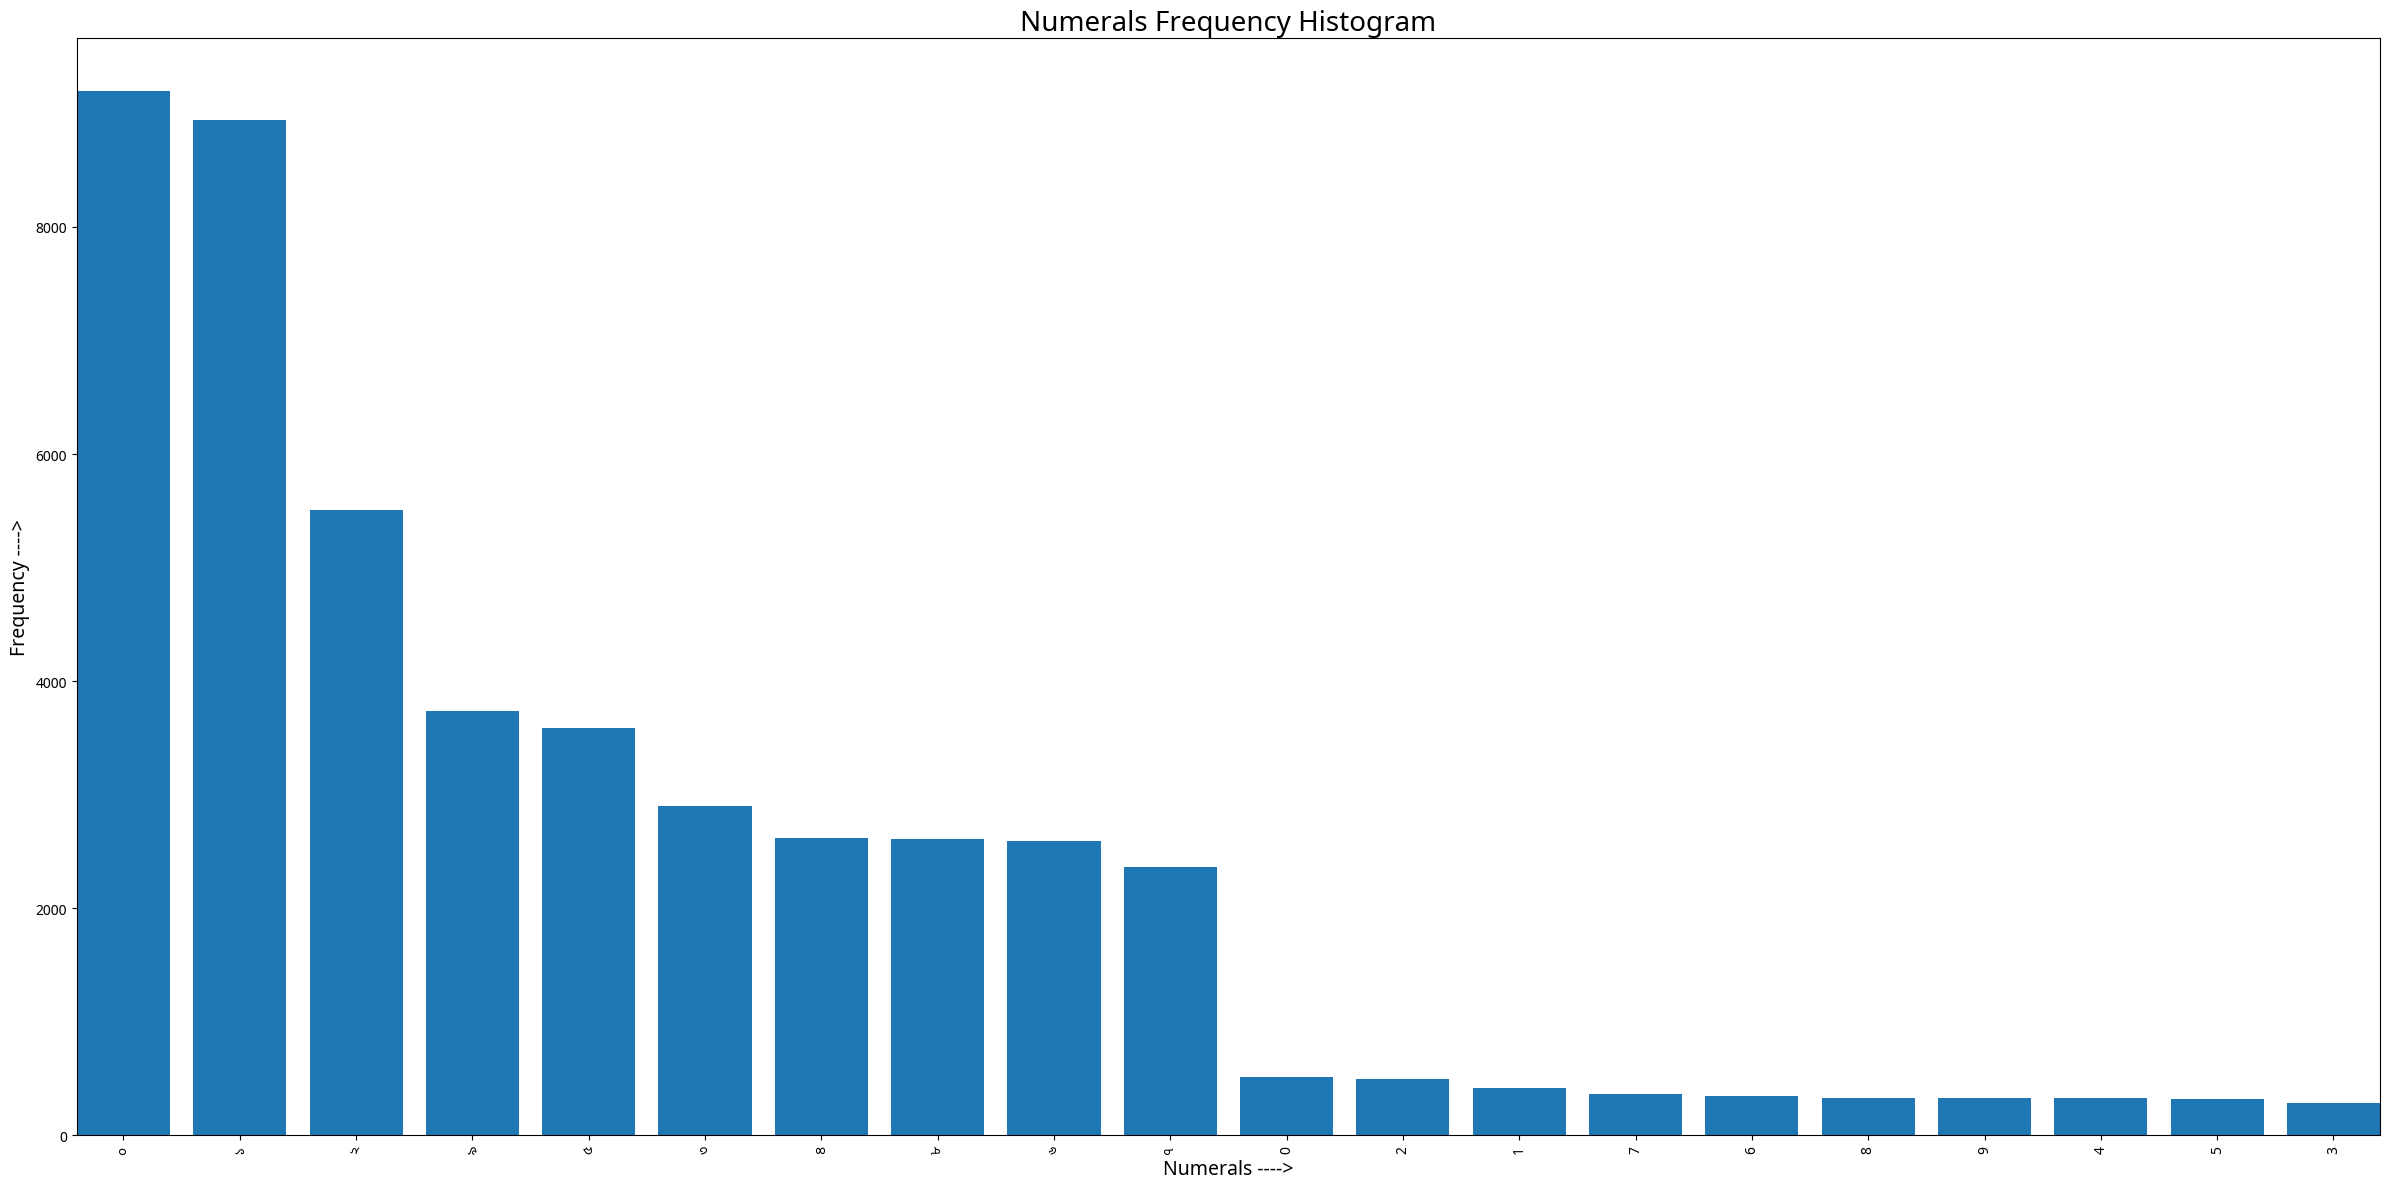

In [472]:
des_digits = []
for sentence in des["target"]:
    des_digits.extend(re.findall(r'[0-9০-৯]', sentence))  # find all single digits

# Build a frequency counter
des_digits_counter = Counter(des_digits)
print("Total Numeral in dataset:",sum(des_digits_counter.values()))
plot_top(des_digits_counter.most_common(),"Numerals","Bengali")


Bengali numerals are much more common

## Hindi

In [473]:
lang="Hindi"

In [474]:
des=pd.DataFrame(data[f"English-{lang}"]["Train"]).T
des.head(10)

,source,target
424714,cancel everything on my calendar,मेरे कैलेंडर पर सब कुछ रद्द करें
424715,Adrenal hormone levels are at their peak durin...,अधिवृक्क के हार्मोन का स्तर प्रातःकाल में अपने...
424716,"Golden threads are obtained from Surat, the qu...","स्वर्ण धागे सूरत से प्राप्त होते हैं, जिनकी गु..."
424717,Look for agglutination within 30 seconds.,30 सेकेण्ड के भीतर एग्लूटिनेशन देखें।
424718,The non-pompousness and informality of their l...,उनके जीवन की आडंबरहीनता एवं अनौपचारिकता उनके स...
424719,"The World Chess Championship 2006, in which Kr...","विश्व शतरंज चैम्पियनशिप 2006, जिसमें क्रैमनिक ..."
424720,The heavily embroidered rugs and shawls produc...,गुजरात के हथकरघा कारखाने में बनने वाले कशीदेदा...
424721,"So, therefore, we need a way in which variable...","तो, इसलिए, हमें एक ऐसे तरीके की आवश्यकता है जि..."
424722,By having honey mixed in onion juice the lack ...,प्याज के रस में शहद मिलाकर सेवन करने से शरीर म...
424723,While taking bath take bath by keeping the mou...,सुबह बिना कुल्ला किए पानी पीकर शौच जाने से पेट...


Target mean frac in Hindi block: 0.781
Target mean frac in Latin block:  0.218


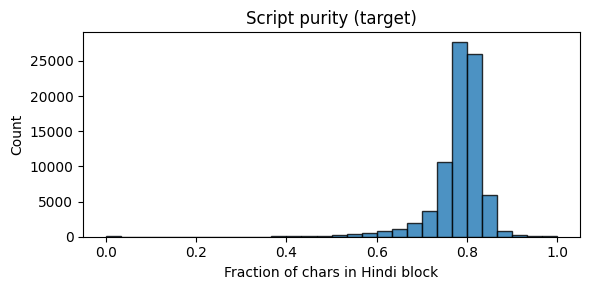

In [475]:
script_purity(des, lang)

In [476]:
print("Size of dataset",len(des))

Size of dataset 80797


### Unique Words

Unique English Words: 100866


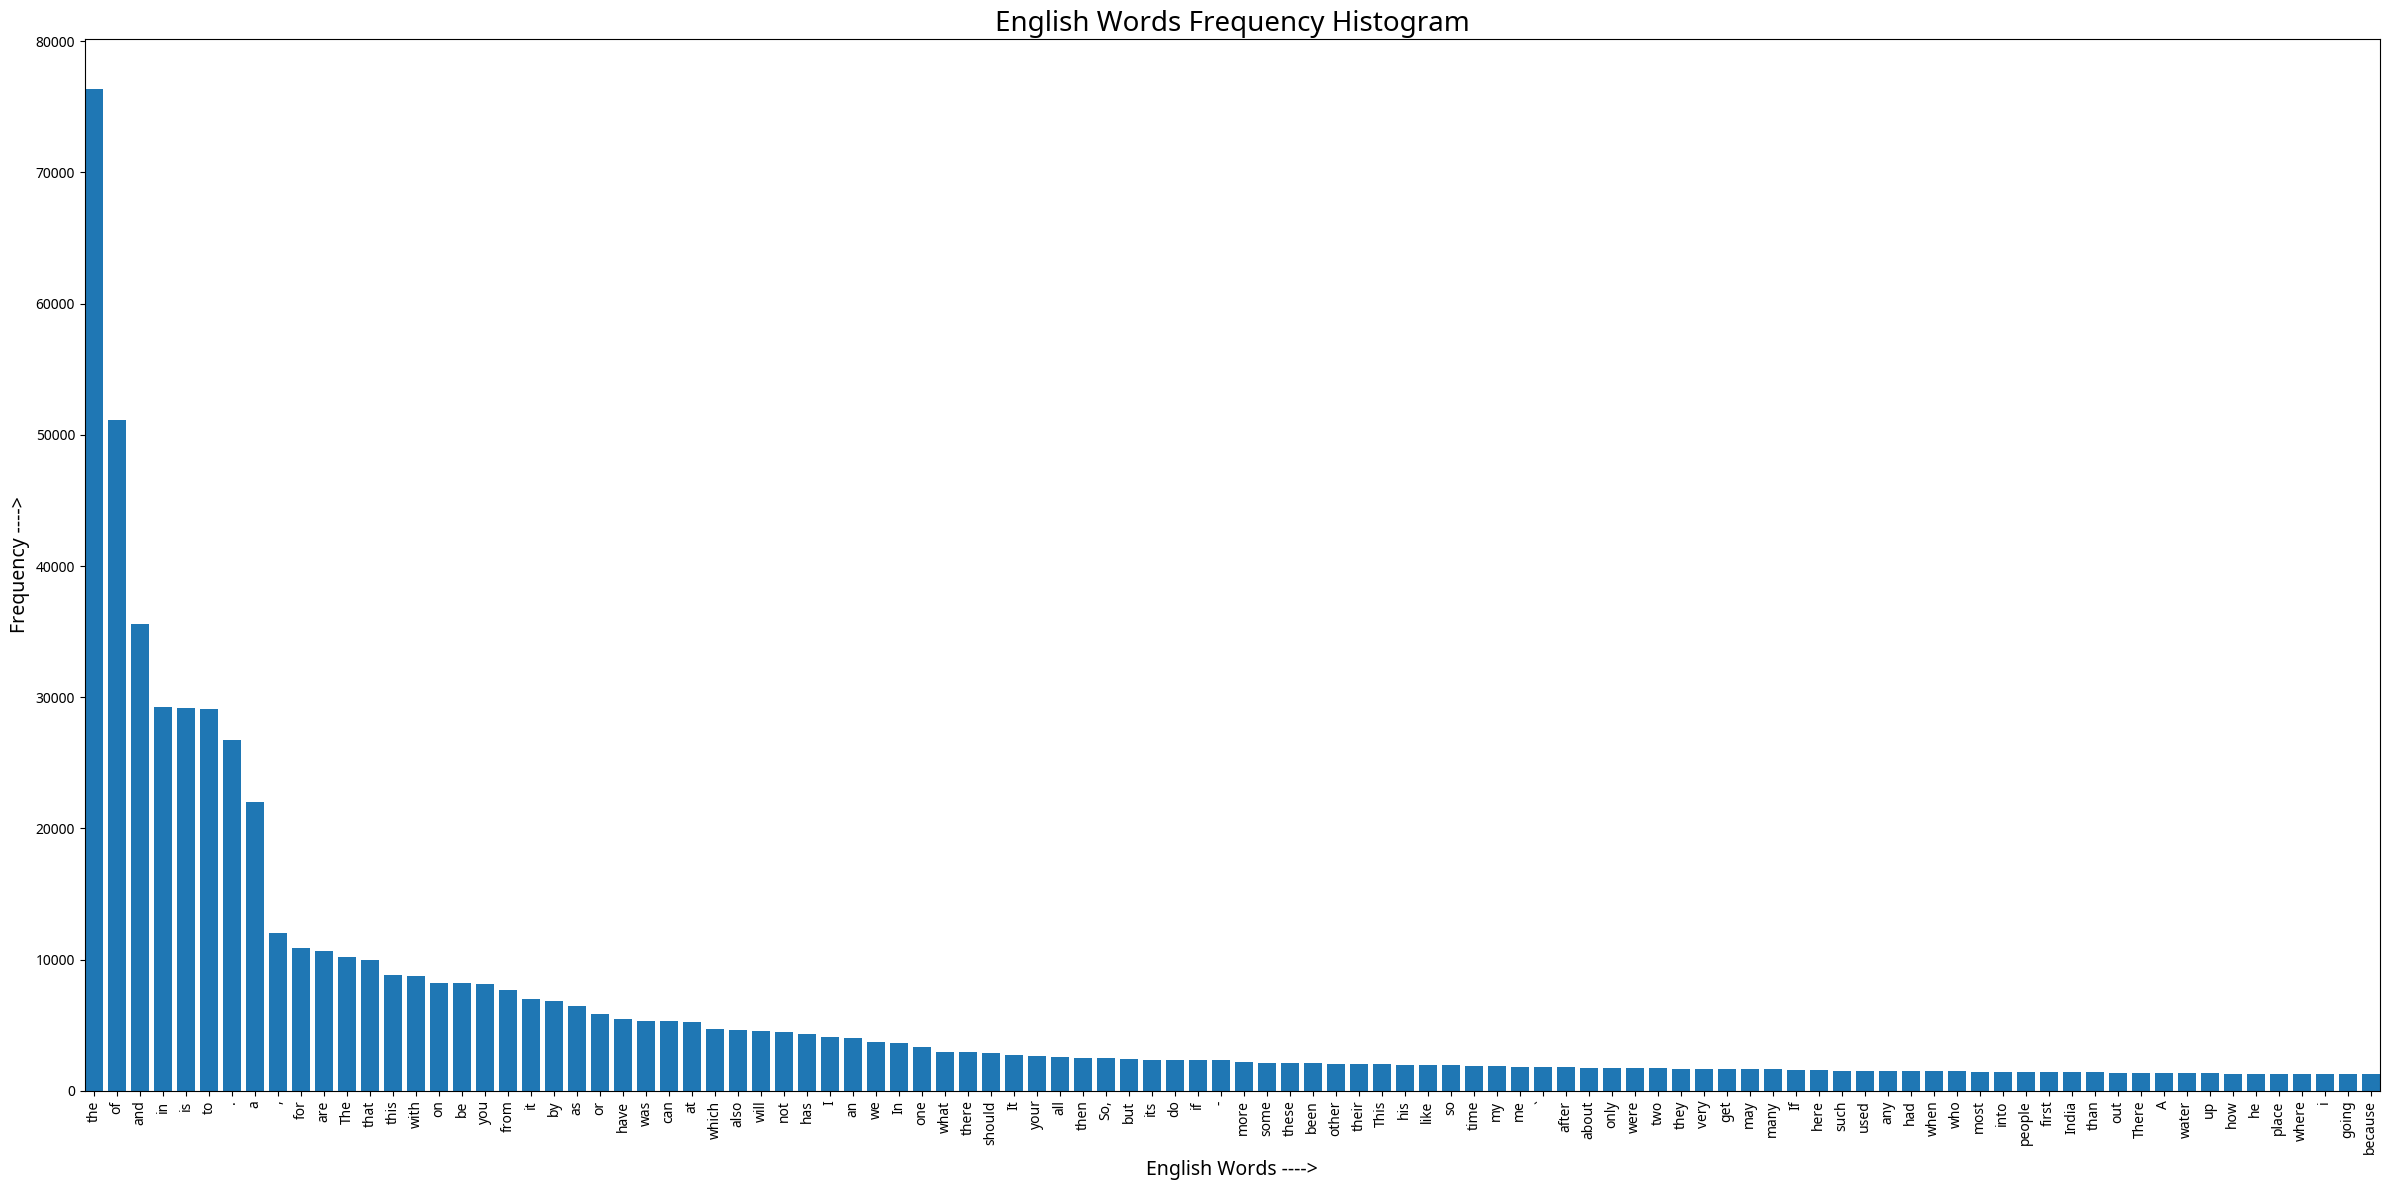

In [477]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 61153


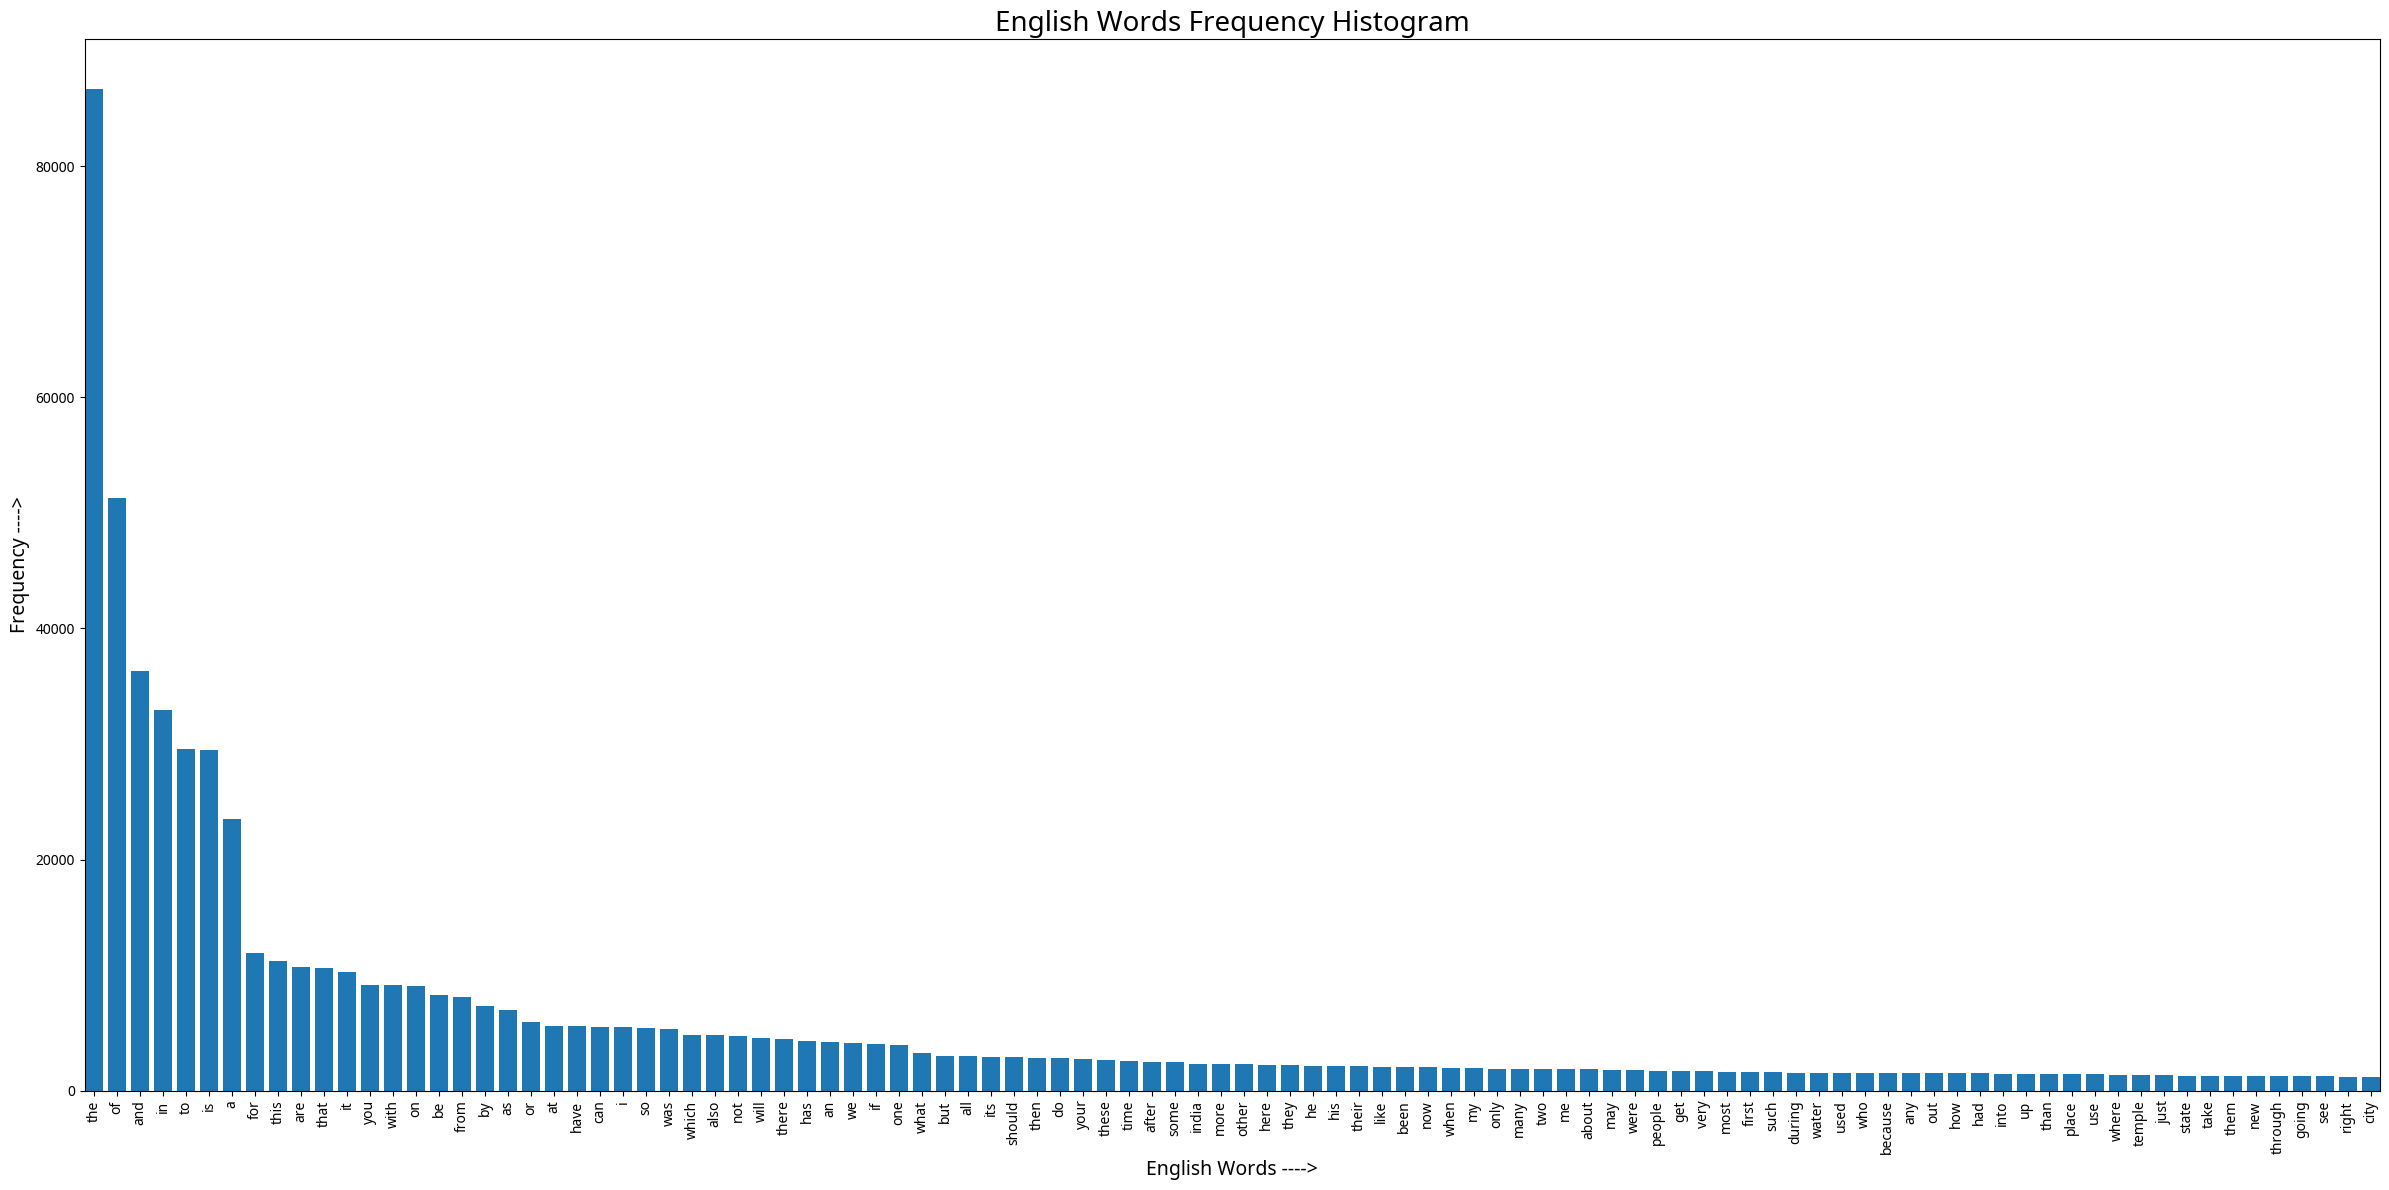

In [478]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

Unique Hindi Words: 94678


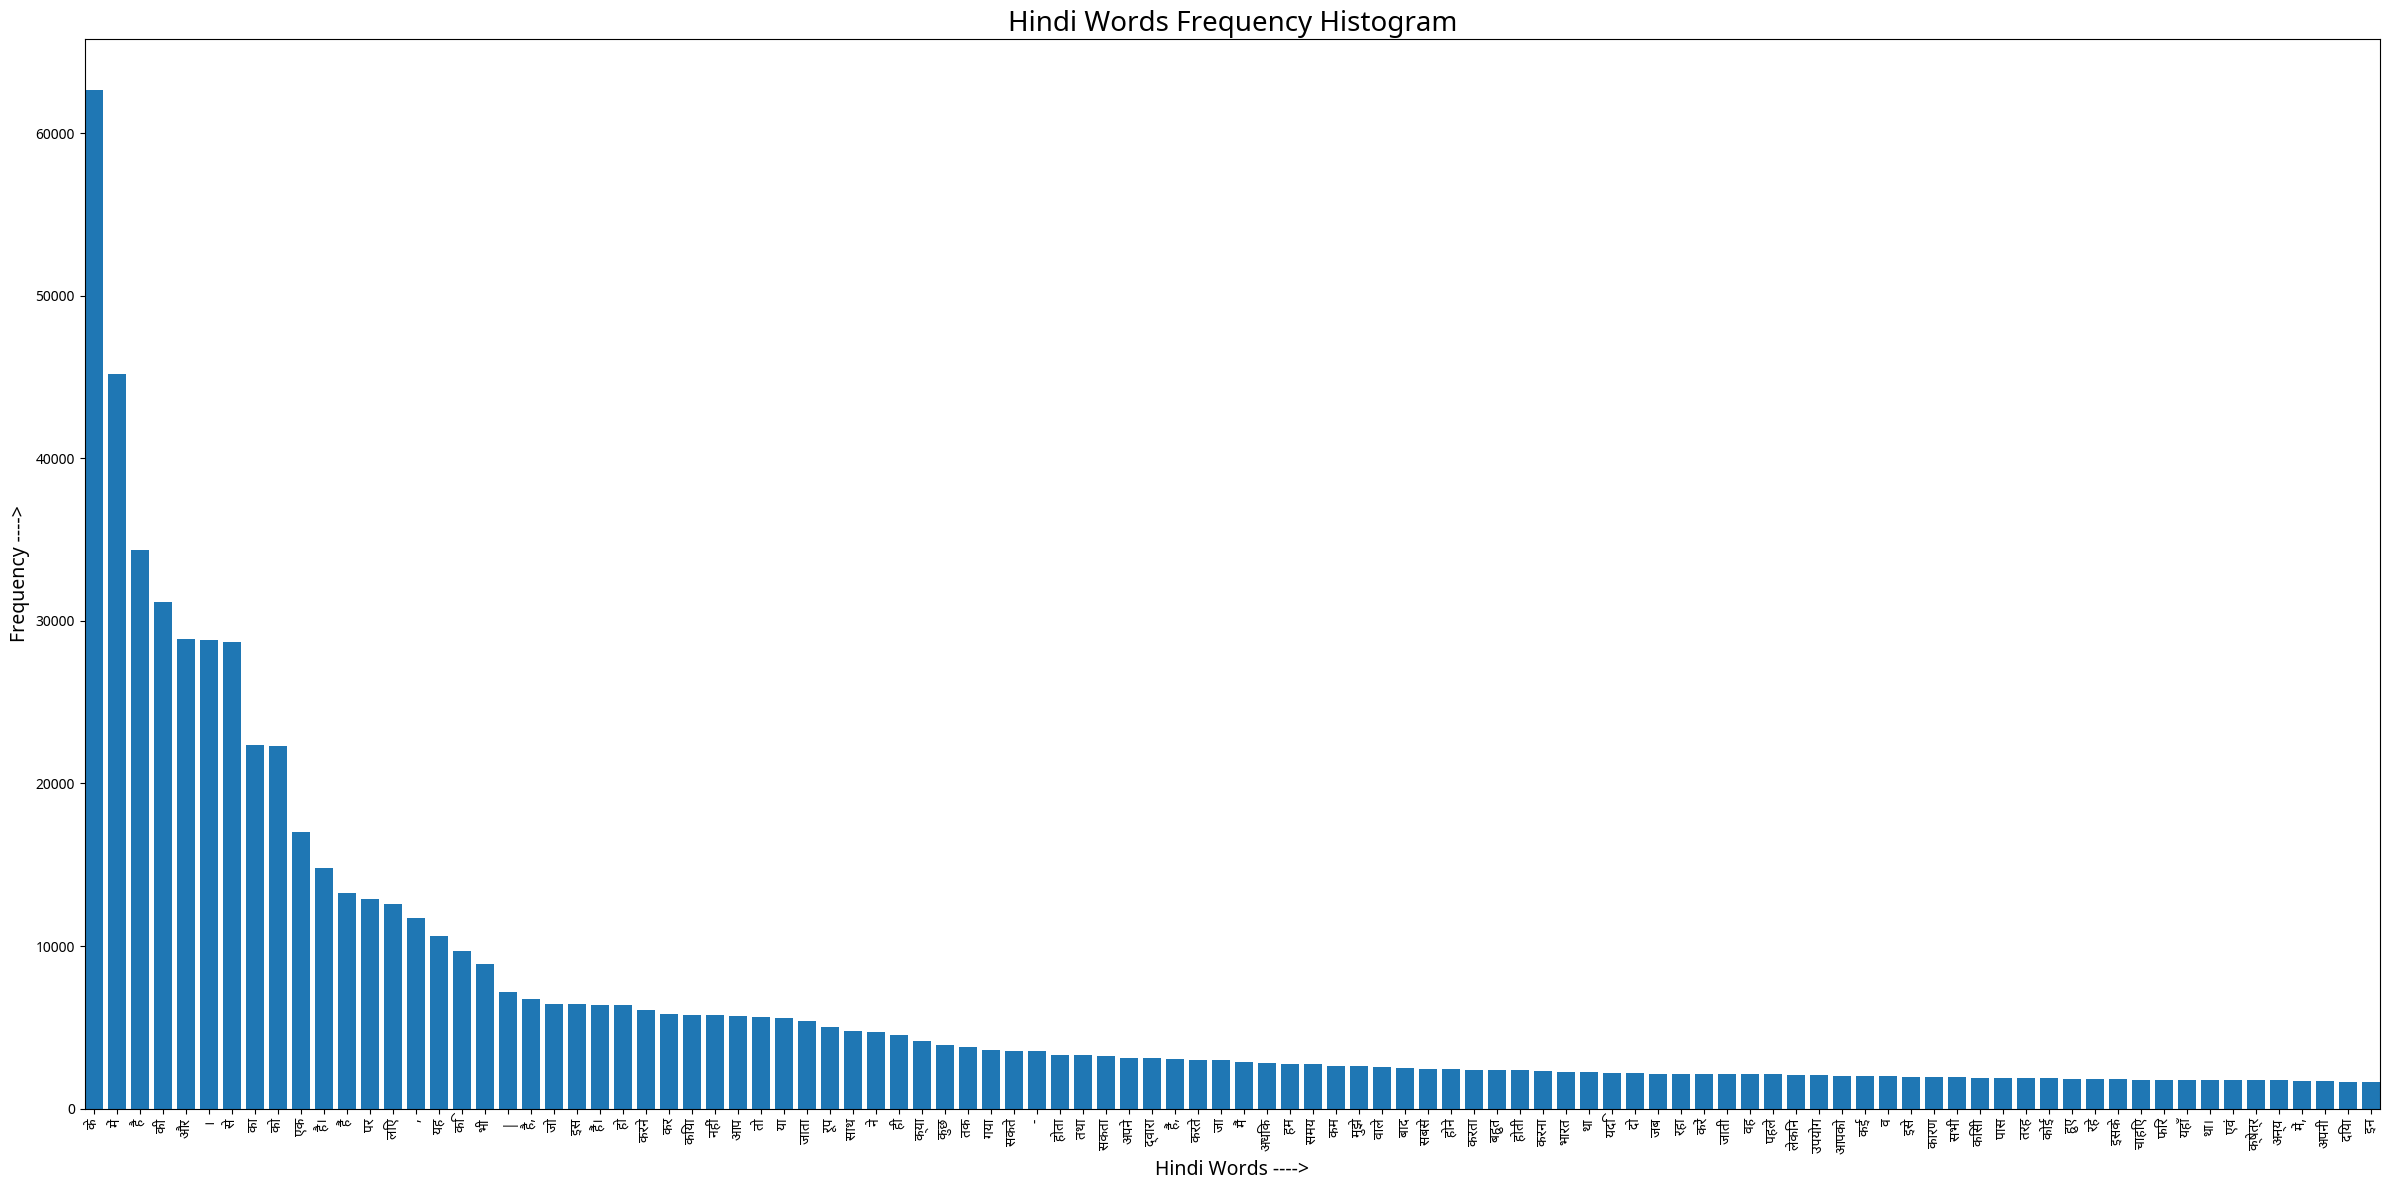

In [479]:
des_des=Counter((" ".join(list(des["target"]))).split())
print(f"Unique {lang} Words:",len(des_des))
plot_top(des_des.most_common(100),f"{lang} Words")

### Entropy

In [480]:
print("Source entropy:",entropy(des_eng))
print(f"{lang} entropy:",entropy(des_des))

Source entropy: 11.199419810733147
Hindi entropy: 11.044456394314565


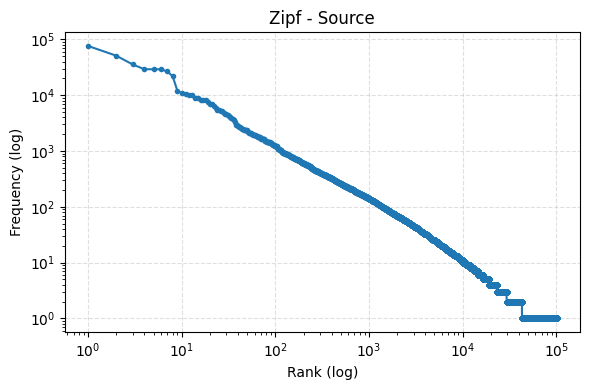

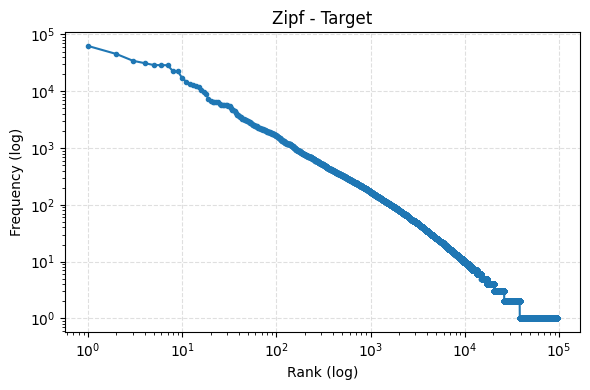

In [481]:
plot_zipf(des_eng, "Zipf - Source")
plot_zipf(des_des, "Zipf - Target")

### Unique Characters

Unique English Characters: 254


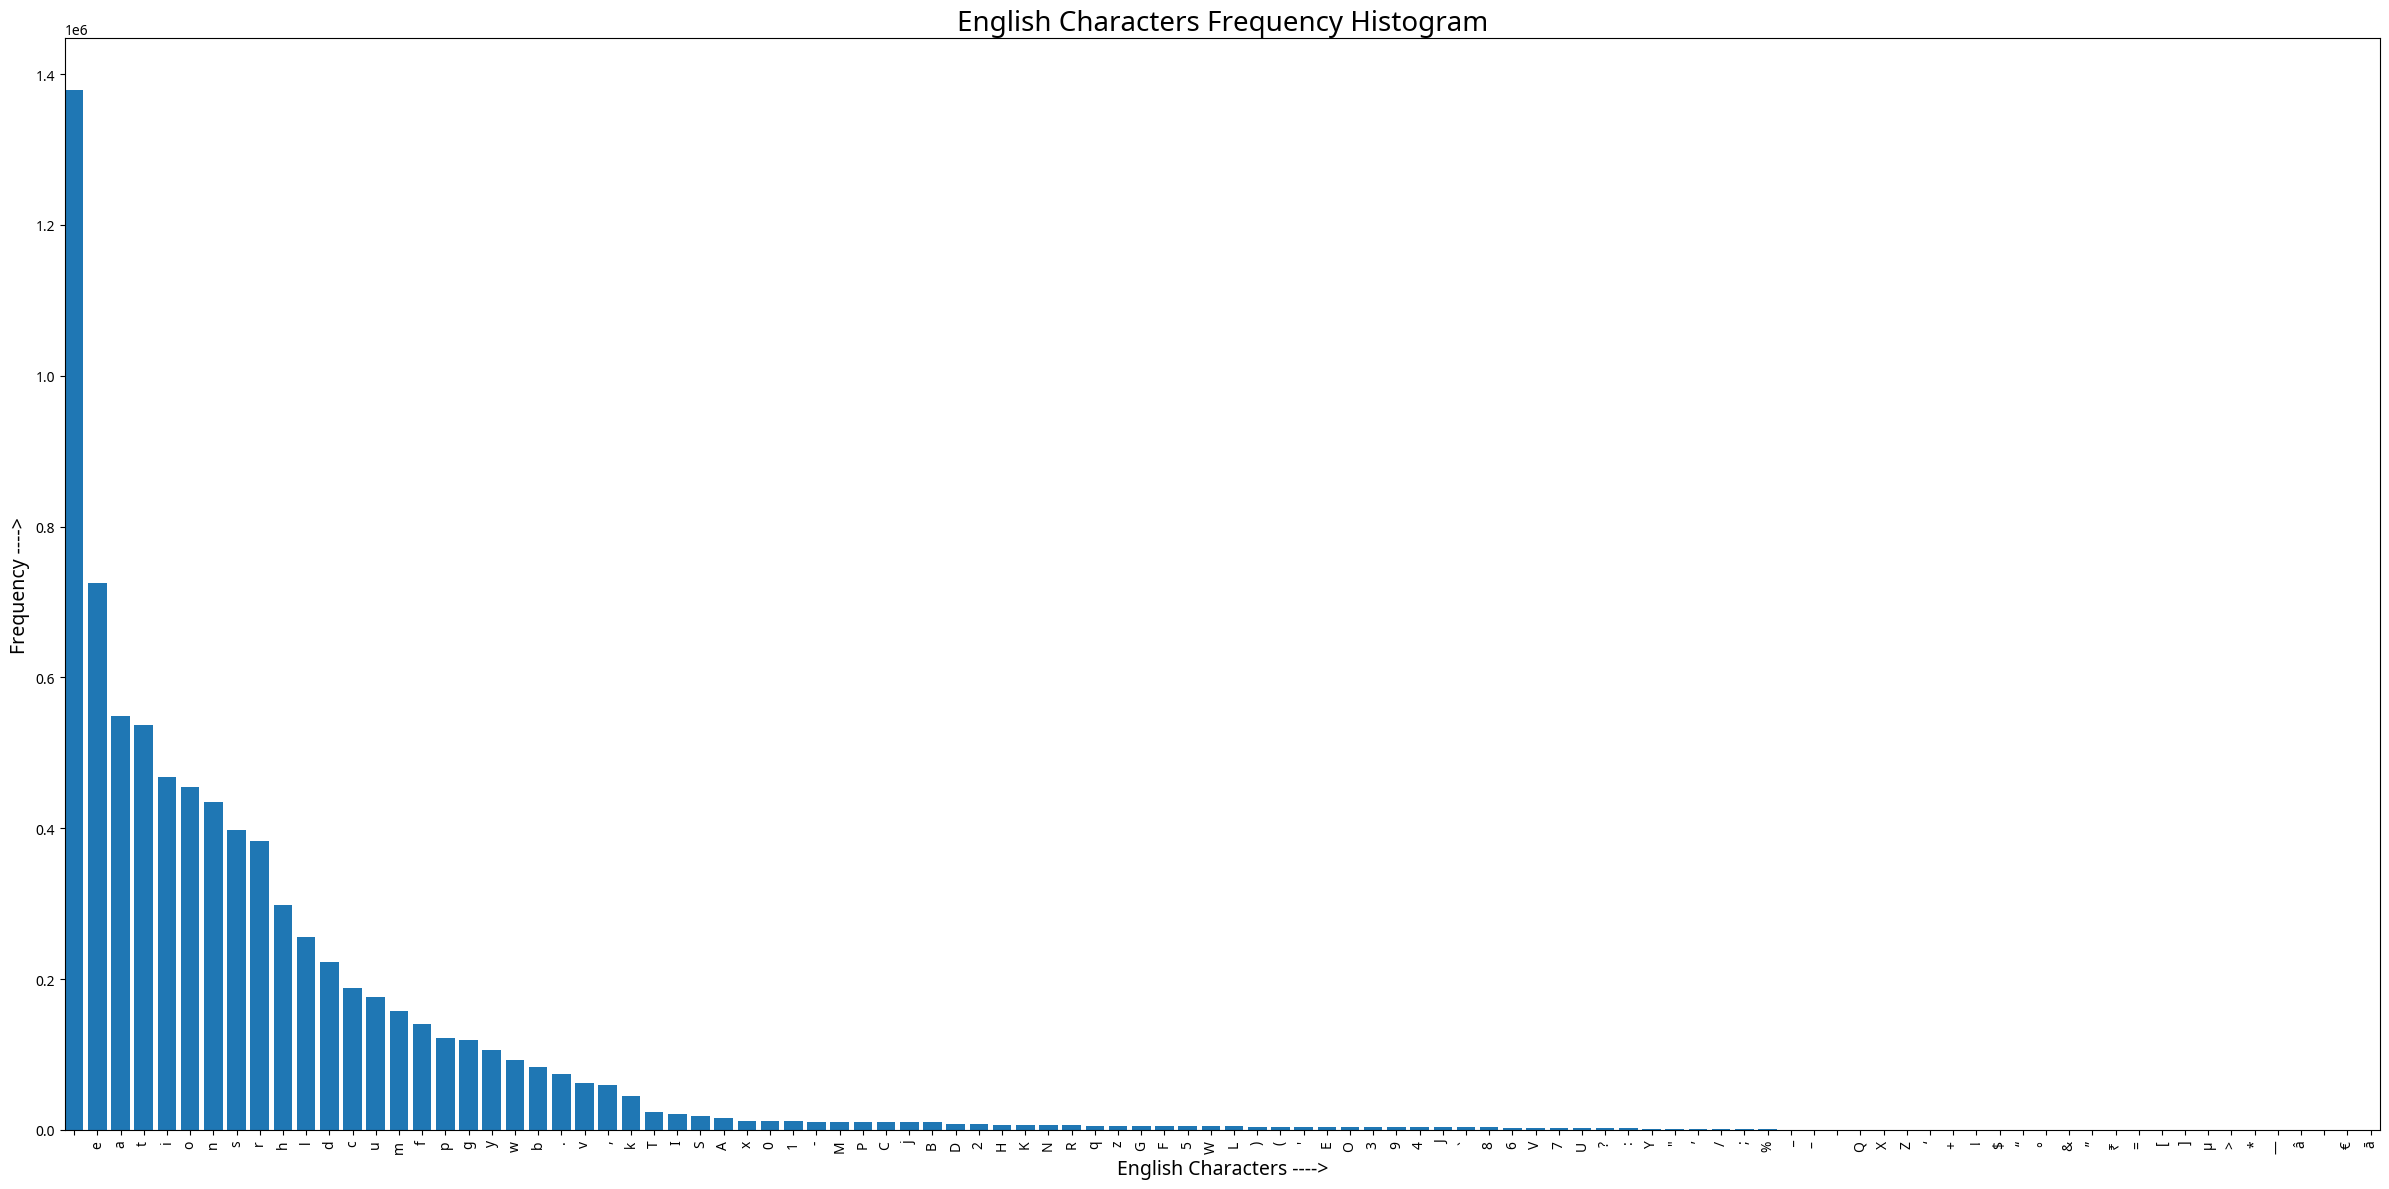

In [482]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

Unique Hindi Characters: 301


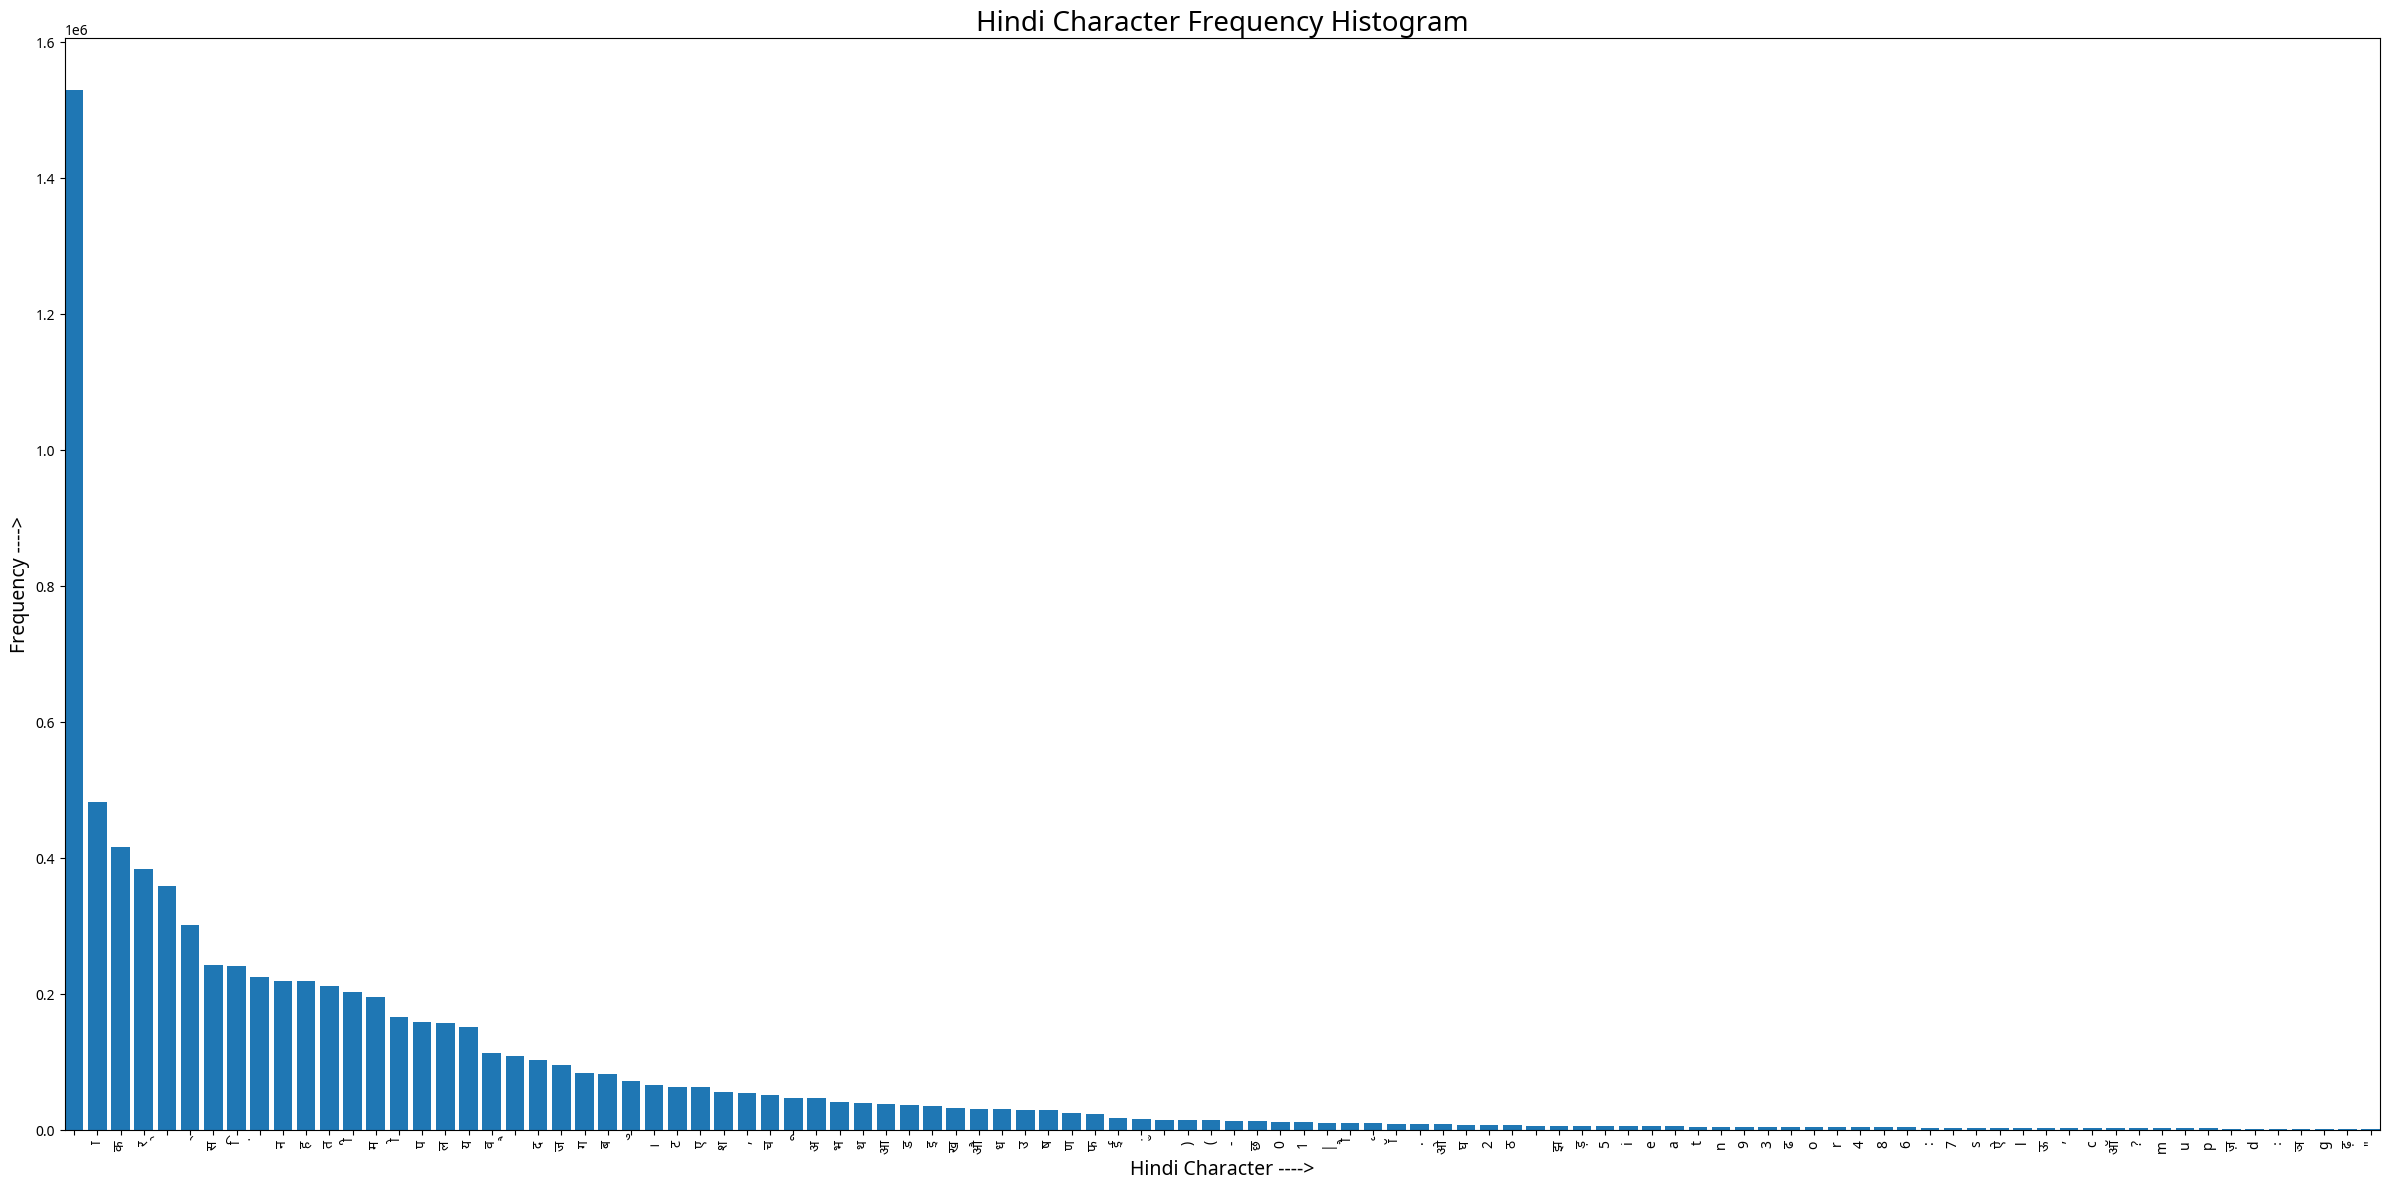

In [483]:
des_des_char=Counter((" ".join(list(des["target"]))))
print(f"Unique {lang} Characters:",len(des_des_char))
plot_top(des_des_char.most_common(100),f"{lang} Character")

### Sentence Length

Average English Sentence Length: 17.067675780041338 words


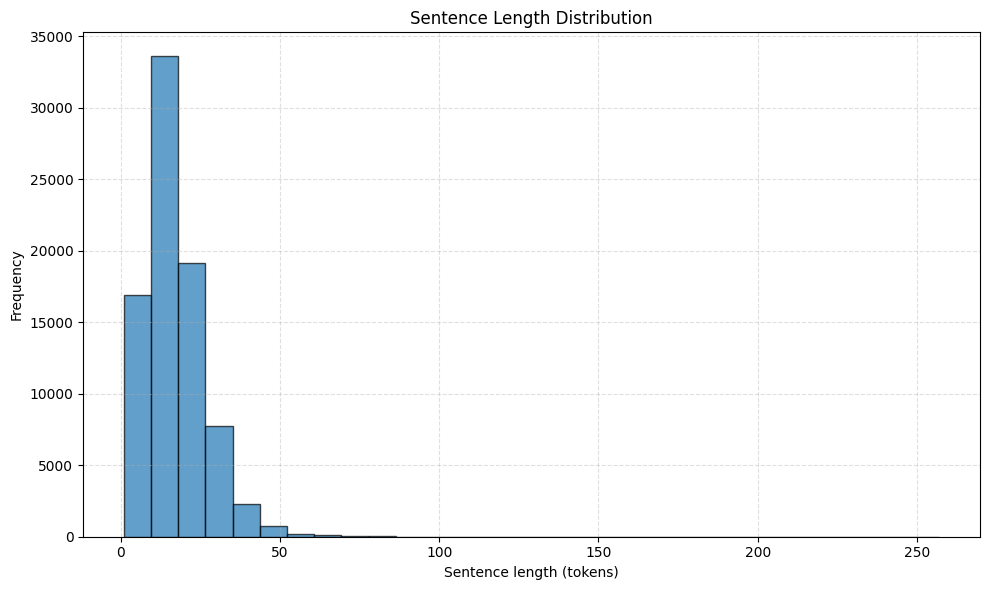

In [484]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

Average Hindi Sentence Length: 18.931767268586704 words


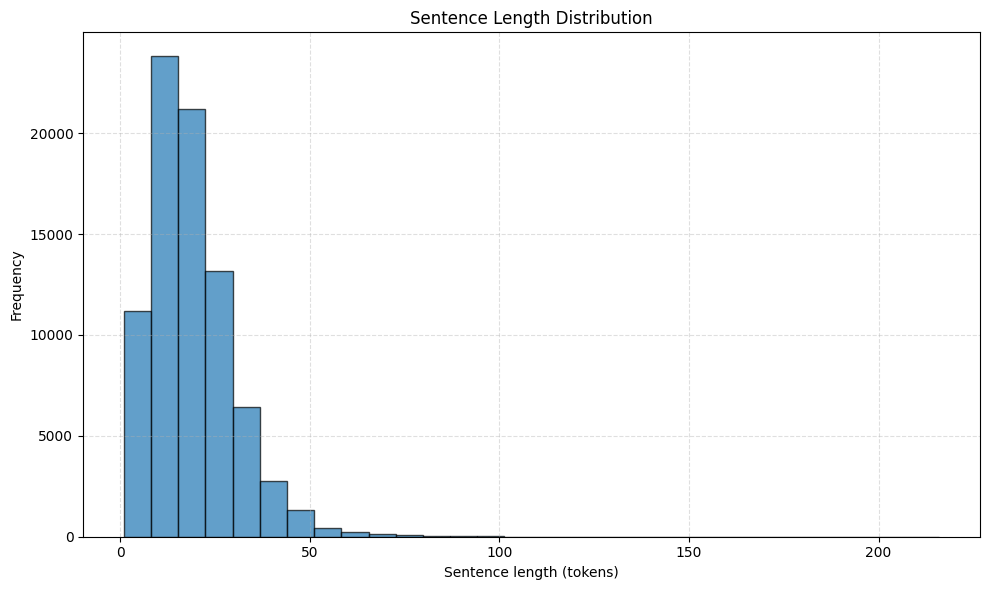

In [485]:
des_des_sent=[len(sent.split()) for sent in des["target"]]
print(f"Average {lang} Sentence Length:",sum(des_des_sent)/len(des_des_sent),"words")
plot_sentence_length_distribution(des_des_sent)

In [486]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))
print(f"{lang} sentence length entropy:",entropy(Counter(des_des_sent)))

Source sentence length entropy: 5.109992530094804
Hindi sentence length entropy: 5.283521806731528


### Numerals

Total Latin Script Numeral in dataset: 57163


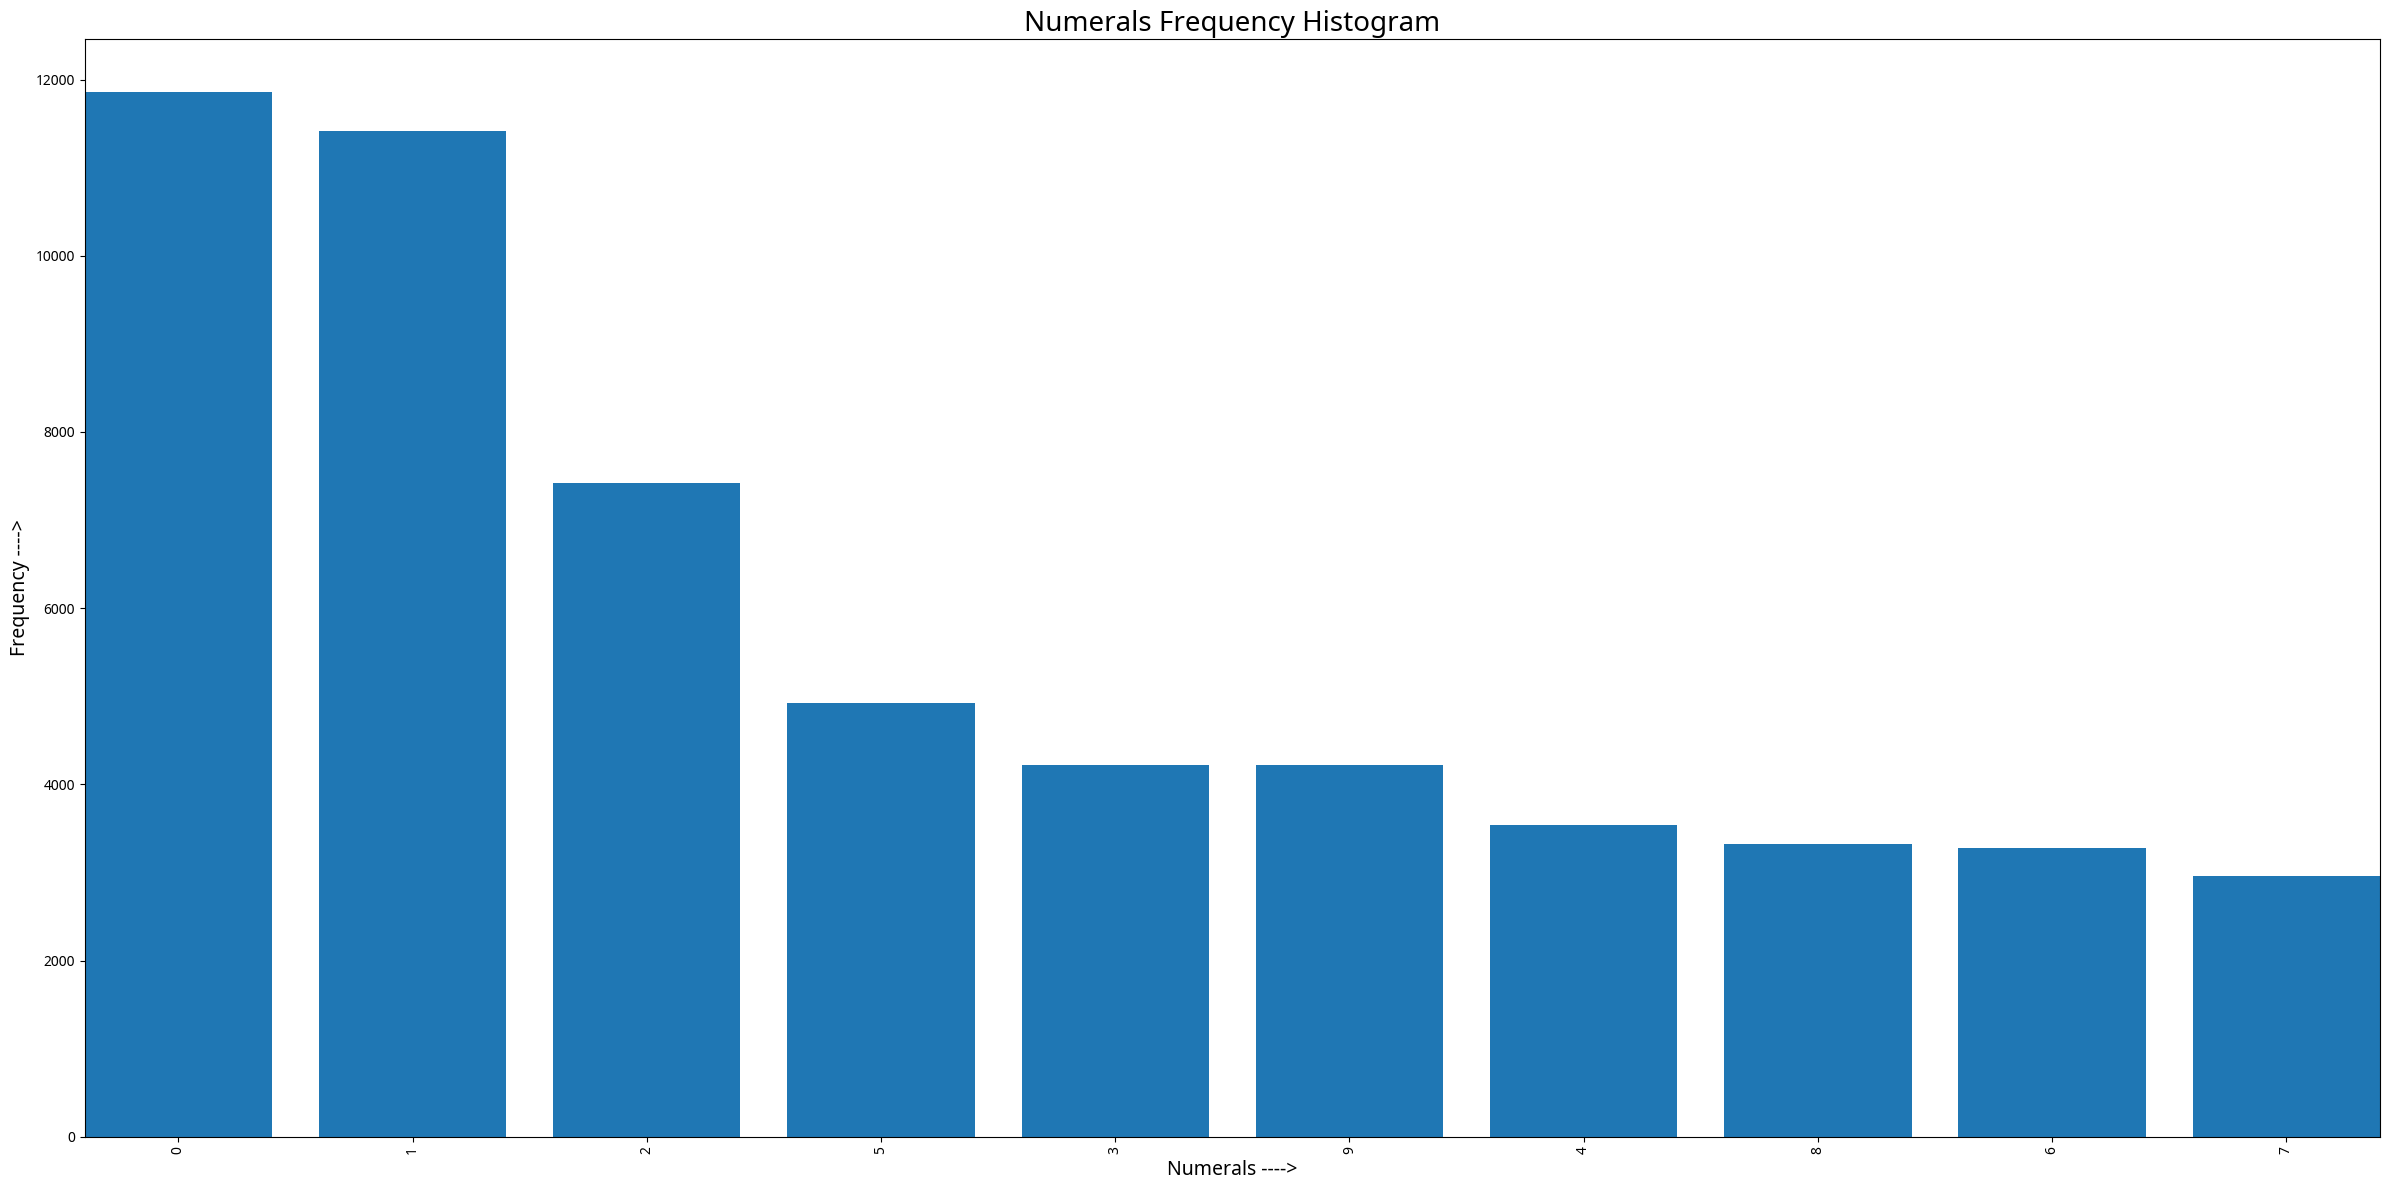

In [487]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")

Total Numeral in dataset: 58314


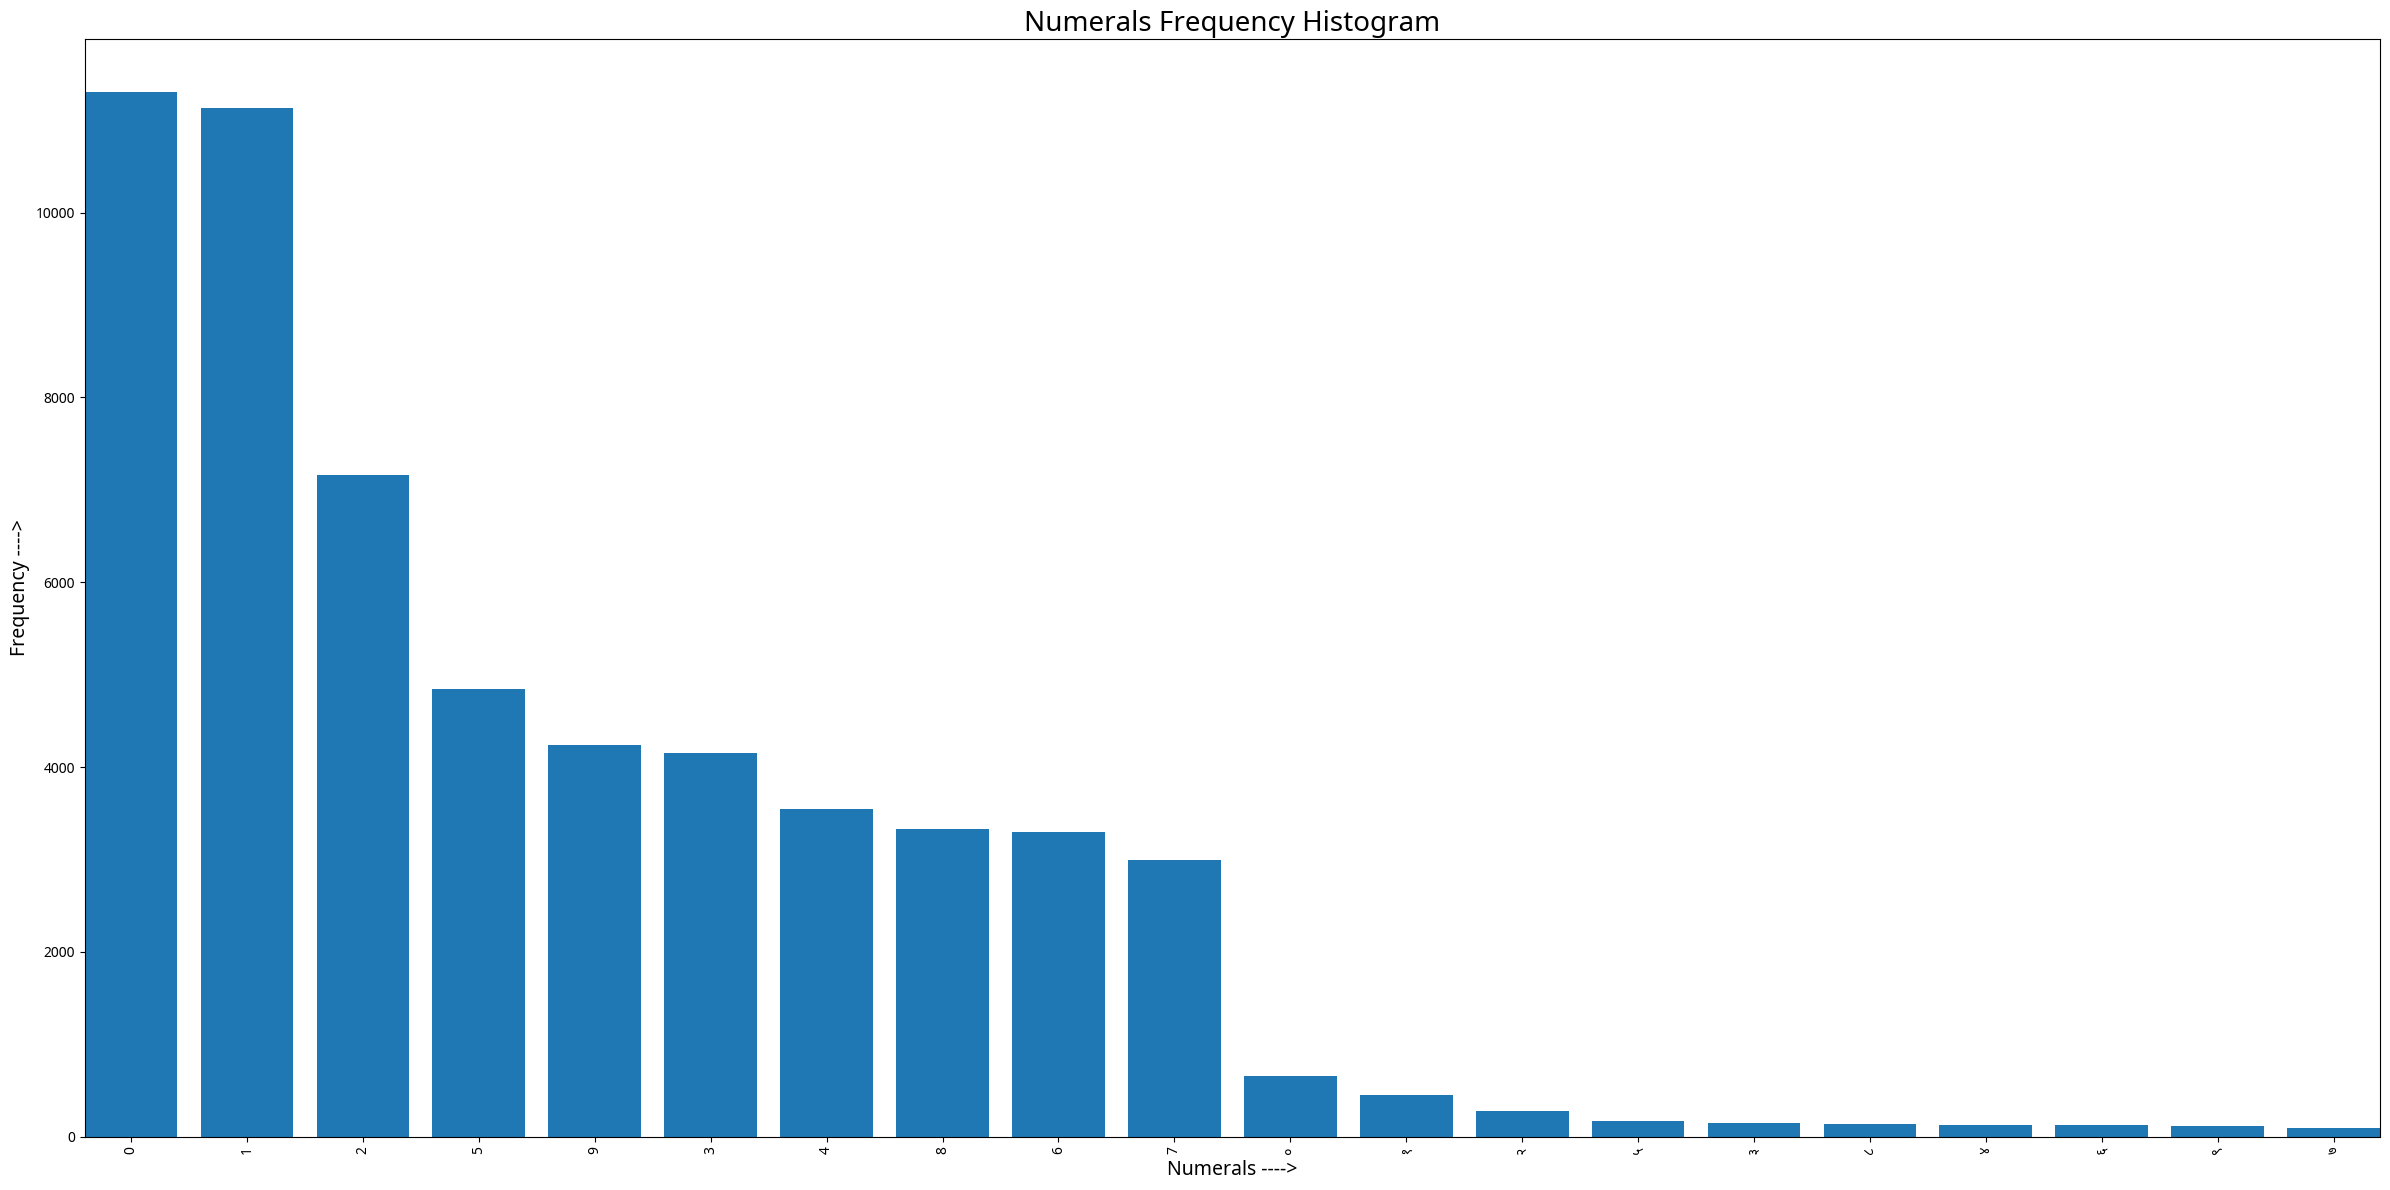

In [488]:
des_digits = []
for sentence in des["target"]:
    des_digits.extend(re.findall(r'[0-9०-९]', sentence))  # find all single digits

# Build a frequency counter
des_digits_counter = Counter(des_digits)
print("Total Numeral in dataset:",sum(des_digits_counter.values()))
plot_top(des_digits_counter.most_common(),"Numerals",)


In Hindi, Latin Numerals are much more common

# Validation

In [ ]:
path = hf_hub_download(
    repo_id="Arnab-Datta-240185/CS779-Capstone-Project",
    filename=f"val_data1.json",
    repo_type="dataset"
)

In [490]:
with open(path, "r") as file:
    data = json.load(file)

## Bengali

In [491]:
lang="Bengali"

In [492]:
des=pd.DataFrame(data[f"English-{lang}"]["Validation"]).T
des.head(10)

,source
147532,Food parks should be established away from tow...
147533,On one side is the Spiti valley and to the oth...
147534,The INF is responsible for compiling world ran...
147535,"The total population of the district was 192,7..."
147536,Patali Srikhetra is a famous place with signif...
147537,what is today's exact date
147538,In Amitabh `s words only Pran gave life to the...
147539,This German scholar through the scientific met...
147540,Your GP will also check to see that you are no...
147541,A baby does not need the nutrients in solid fo...


In [493]:
print("Size of dataset",len(des))

Size of dataset 9836


### Unique Words

Unique English Words: 27925


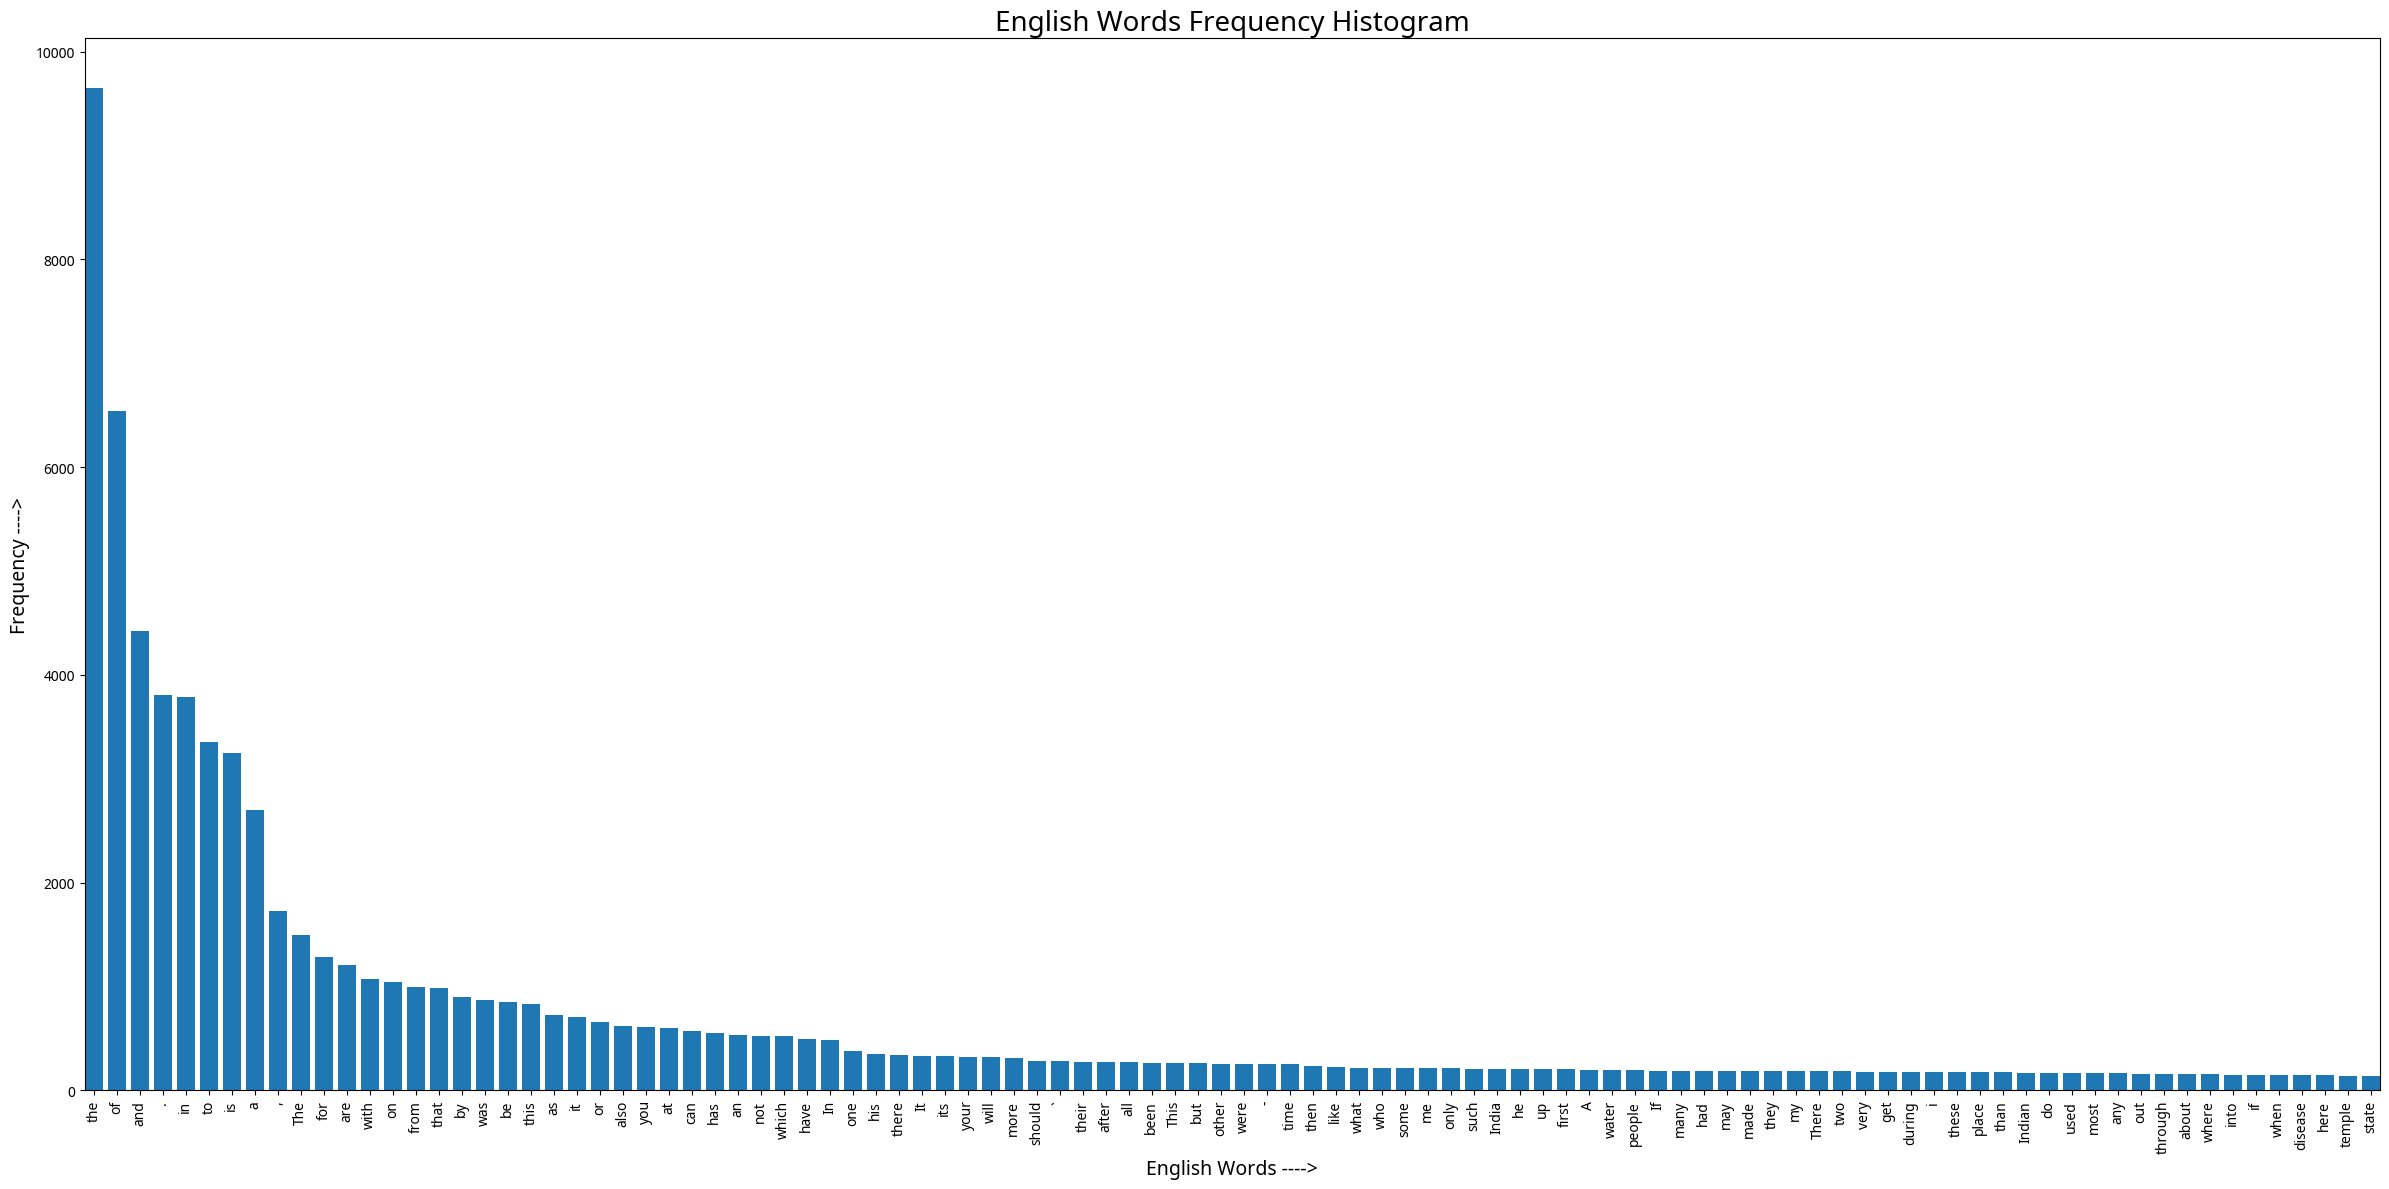

In [494]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 20303


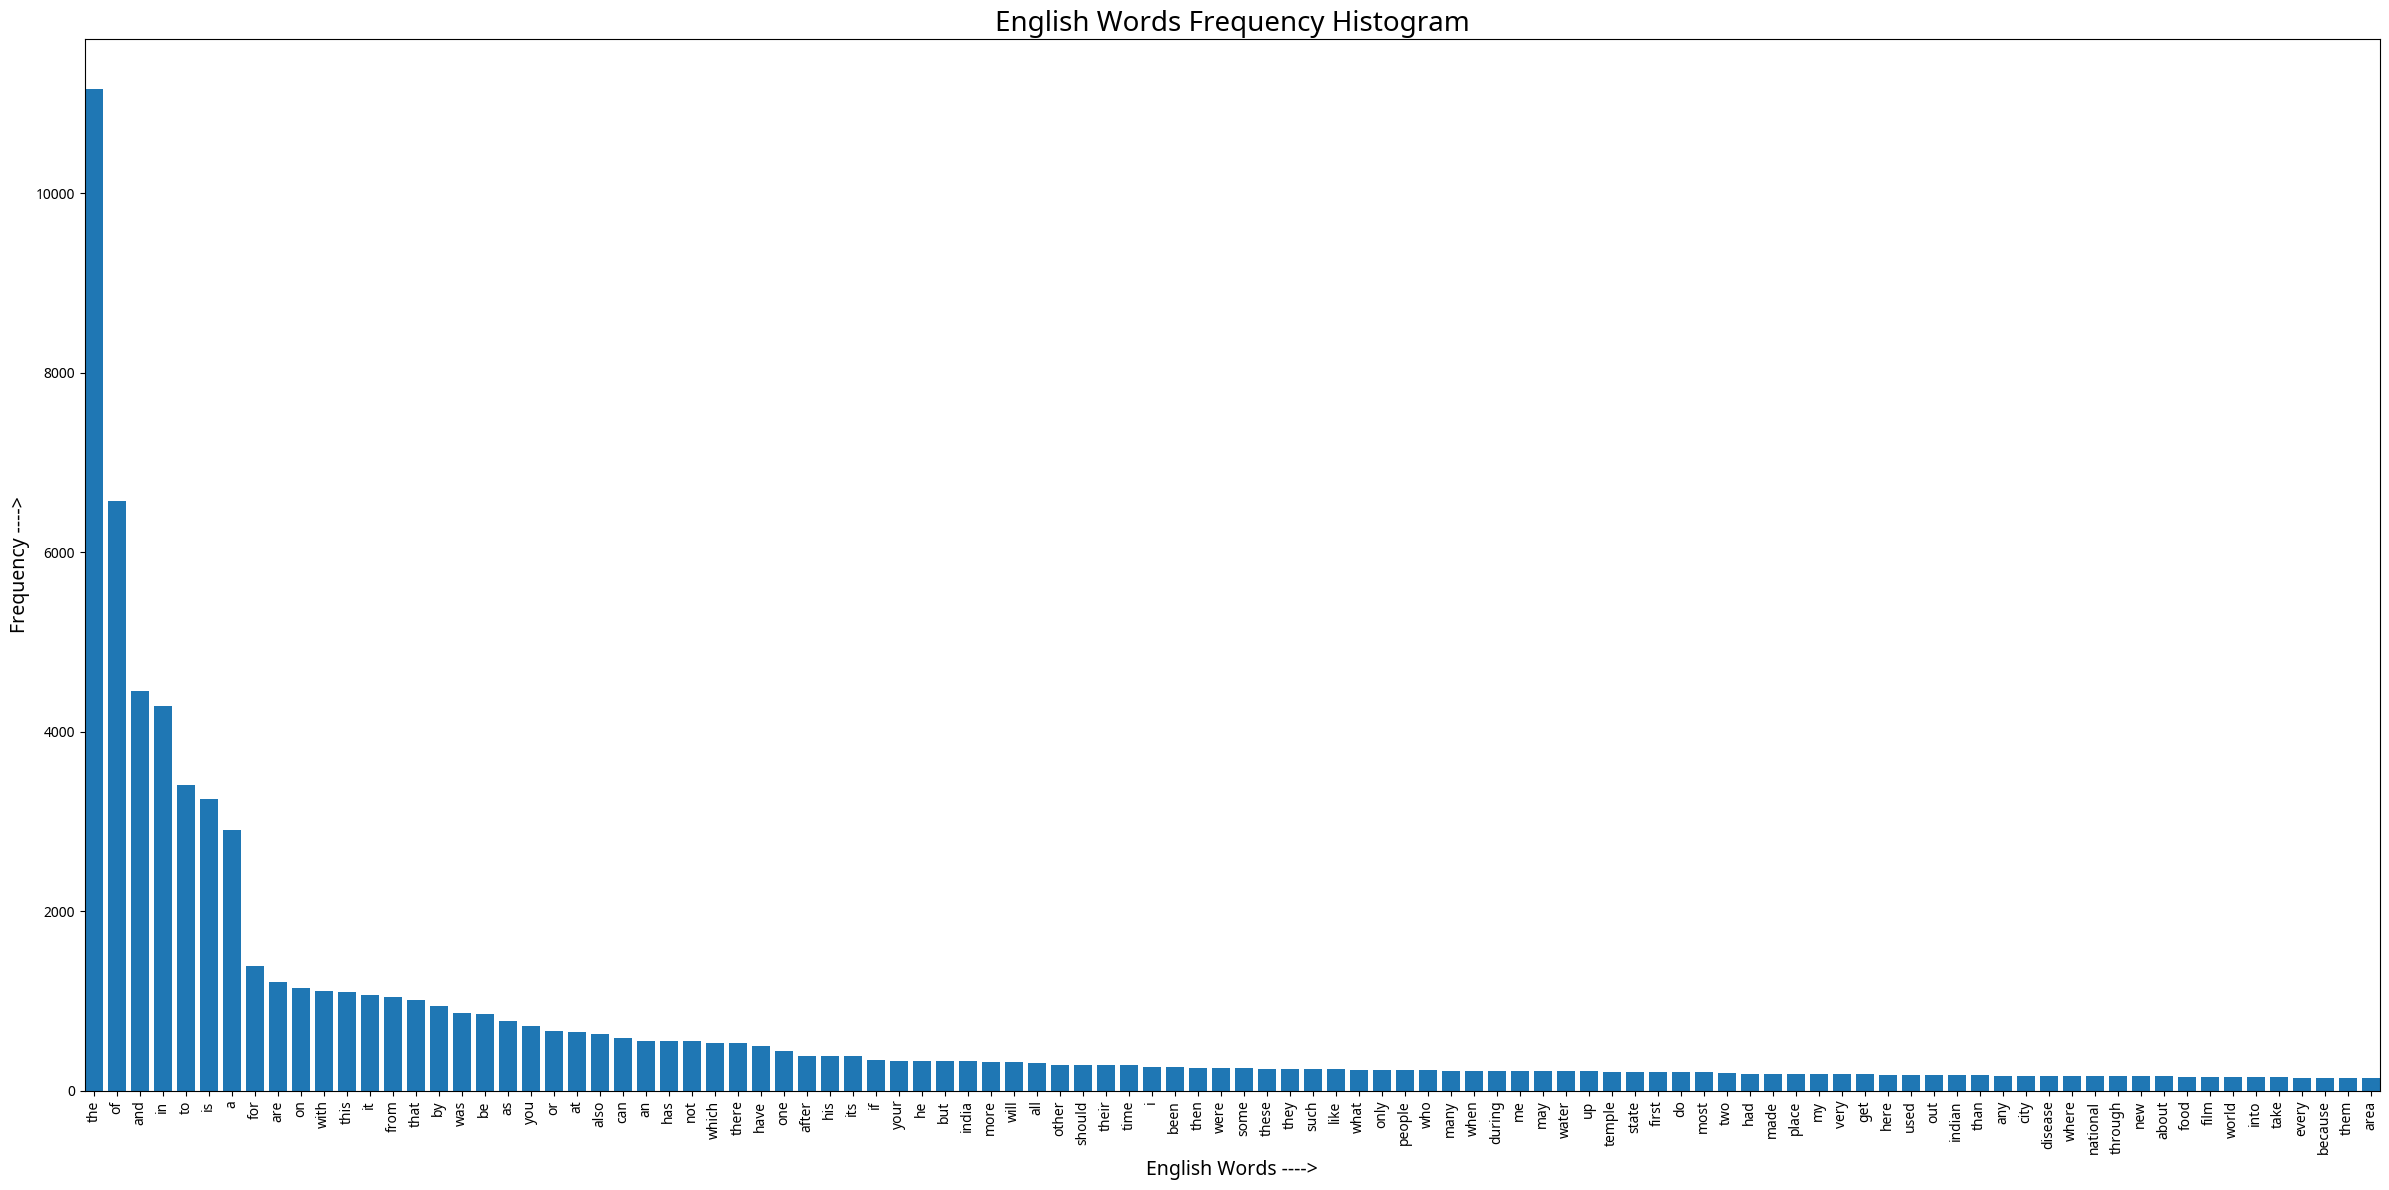

In [495]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

### Entropy

In [496]:
print("Source entropy:",entropy(des_eng))

Source entropy: 10.879135813935013


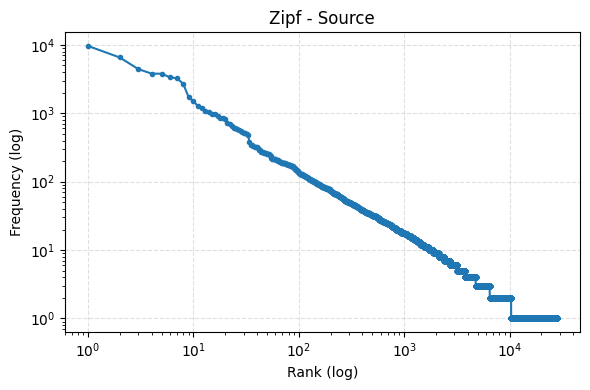

In [497]:
plot_zipf(des_eng, "Zipf - Source")

### Unique Characters

Unique English Characters: 145


/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 129 (\x81) missing from font(s) Noto Sans Devanagari, Noto Sans.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from font(s) Noto Sans Devanagari, Noto Sans.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Matplotlib currently does not support Bengali natively.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 2482 (\N{BENGALI LETTER LA}) missing from font(s) Noto Sans Devanagari, Noto Sans.
  plt.tight_layout()
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129 (\x81) missing from font(s) Noto Sans Devanagari, Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 2503 (\N{BENGALI VOWEL SIGN E}) missing from font(s) Noto Sans Devana

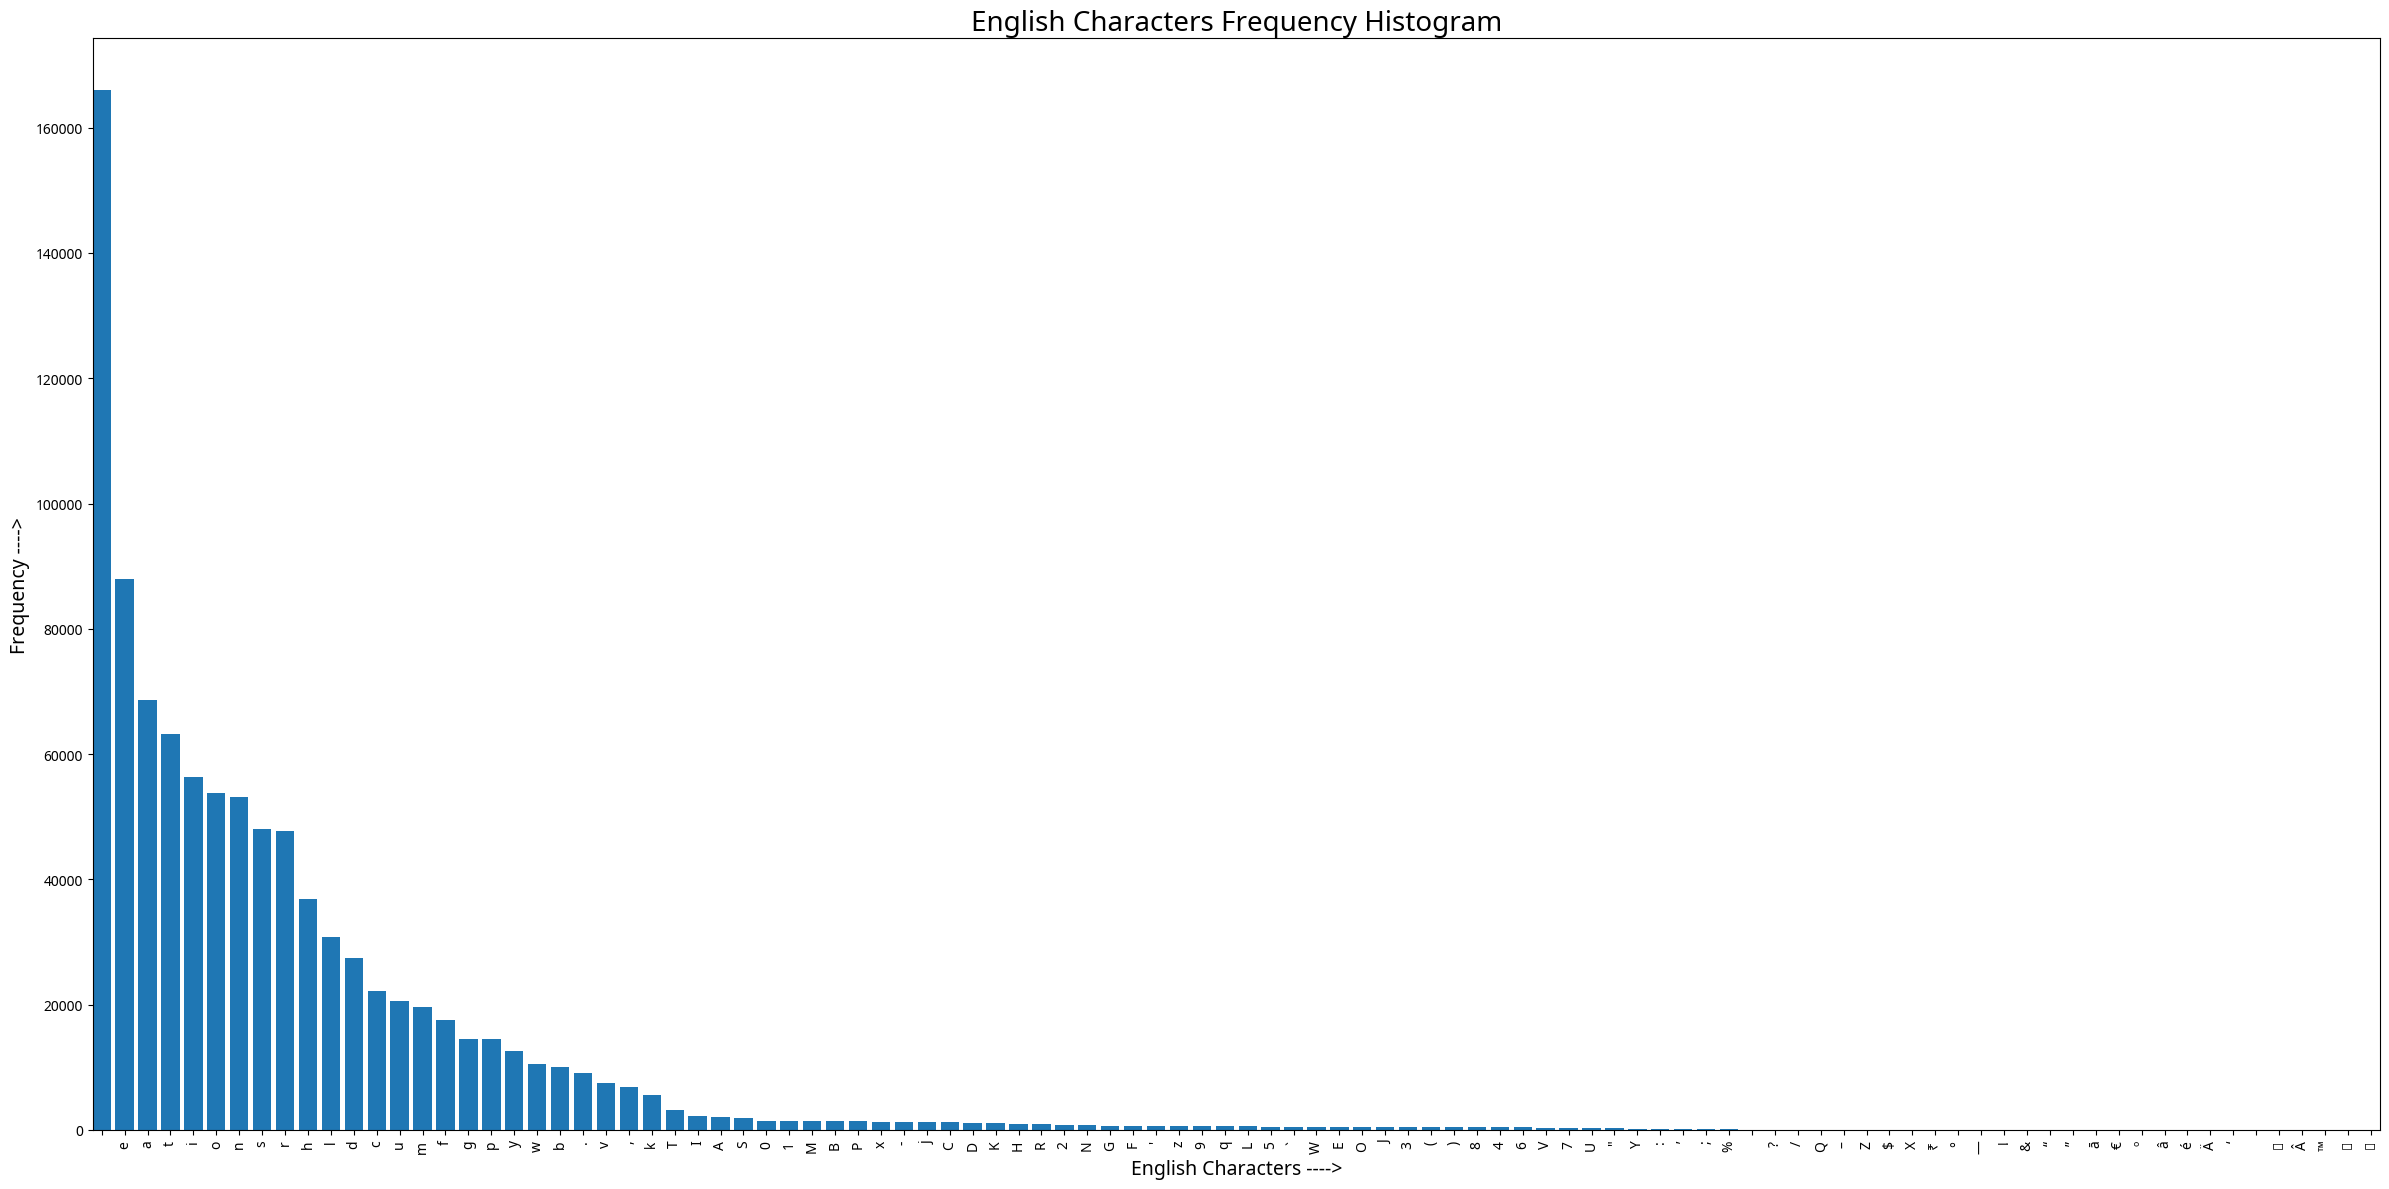

In [498]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

### Sentence Length

Average English Sentence Length: 16.880032533550224 words


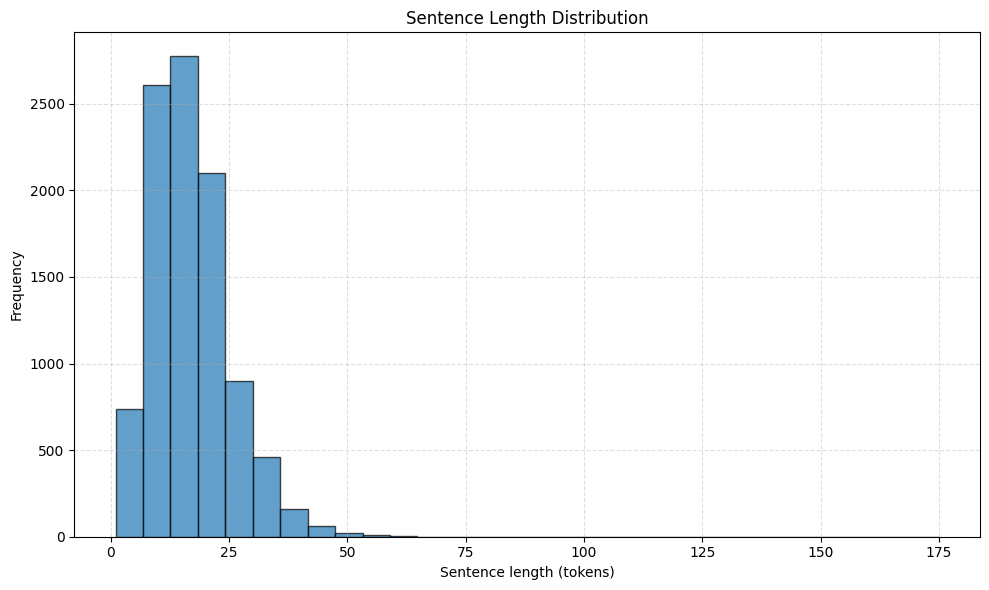

In [499]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

In [500]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))

Source sentence length entropy: 4.989648266448063


### Numerals

Total Latin Script Numeral in dataset: 7119


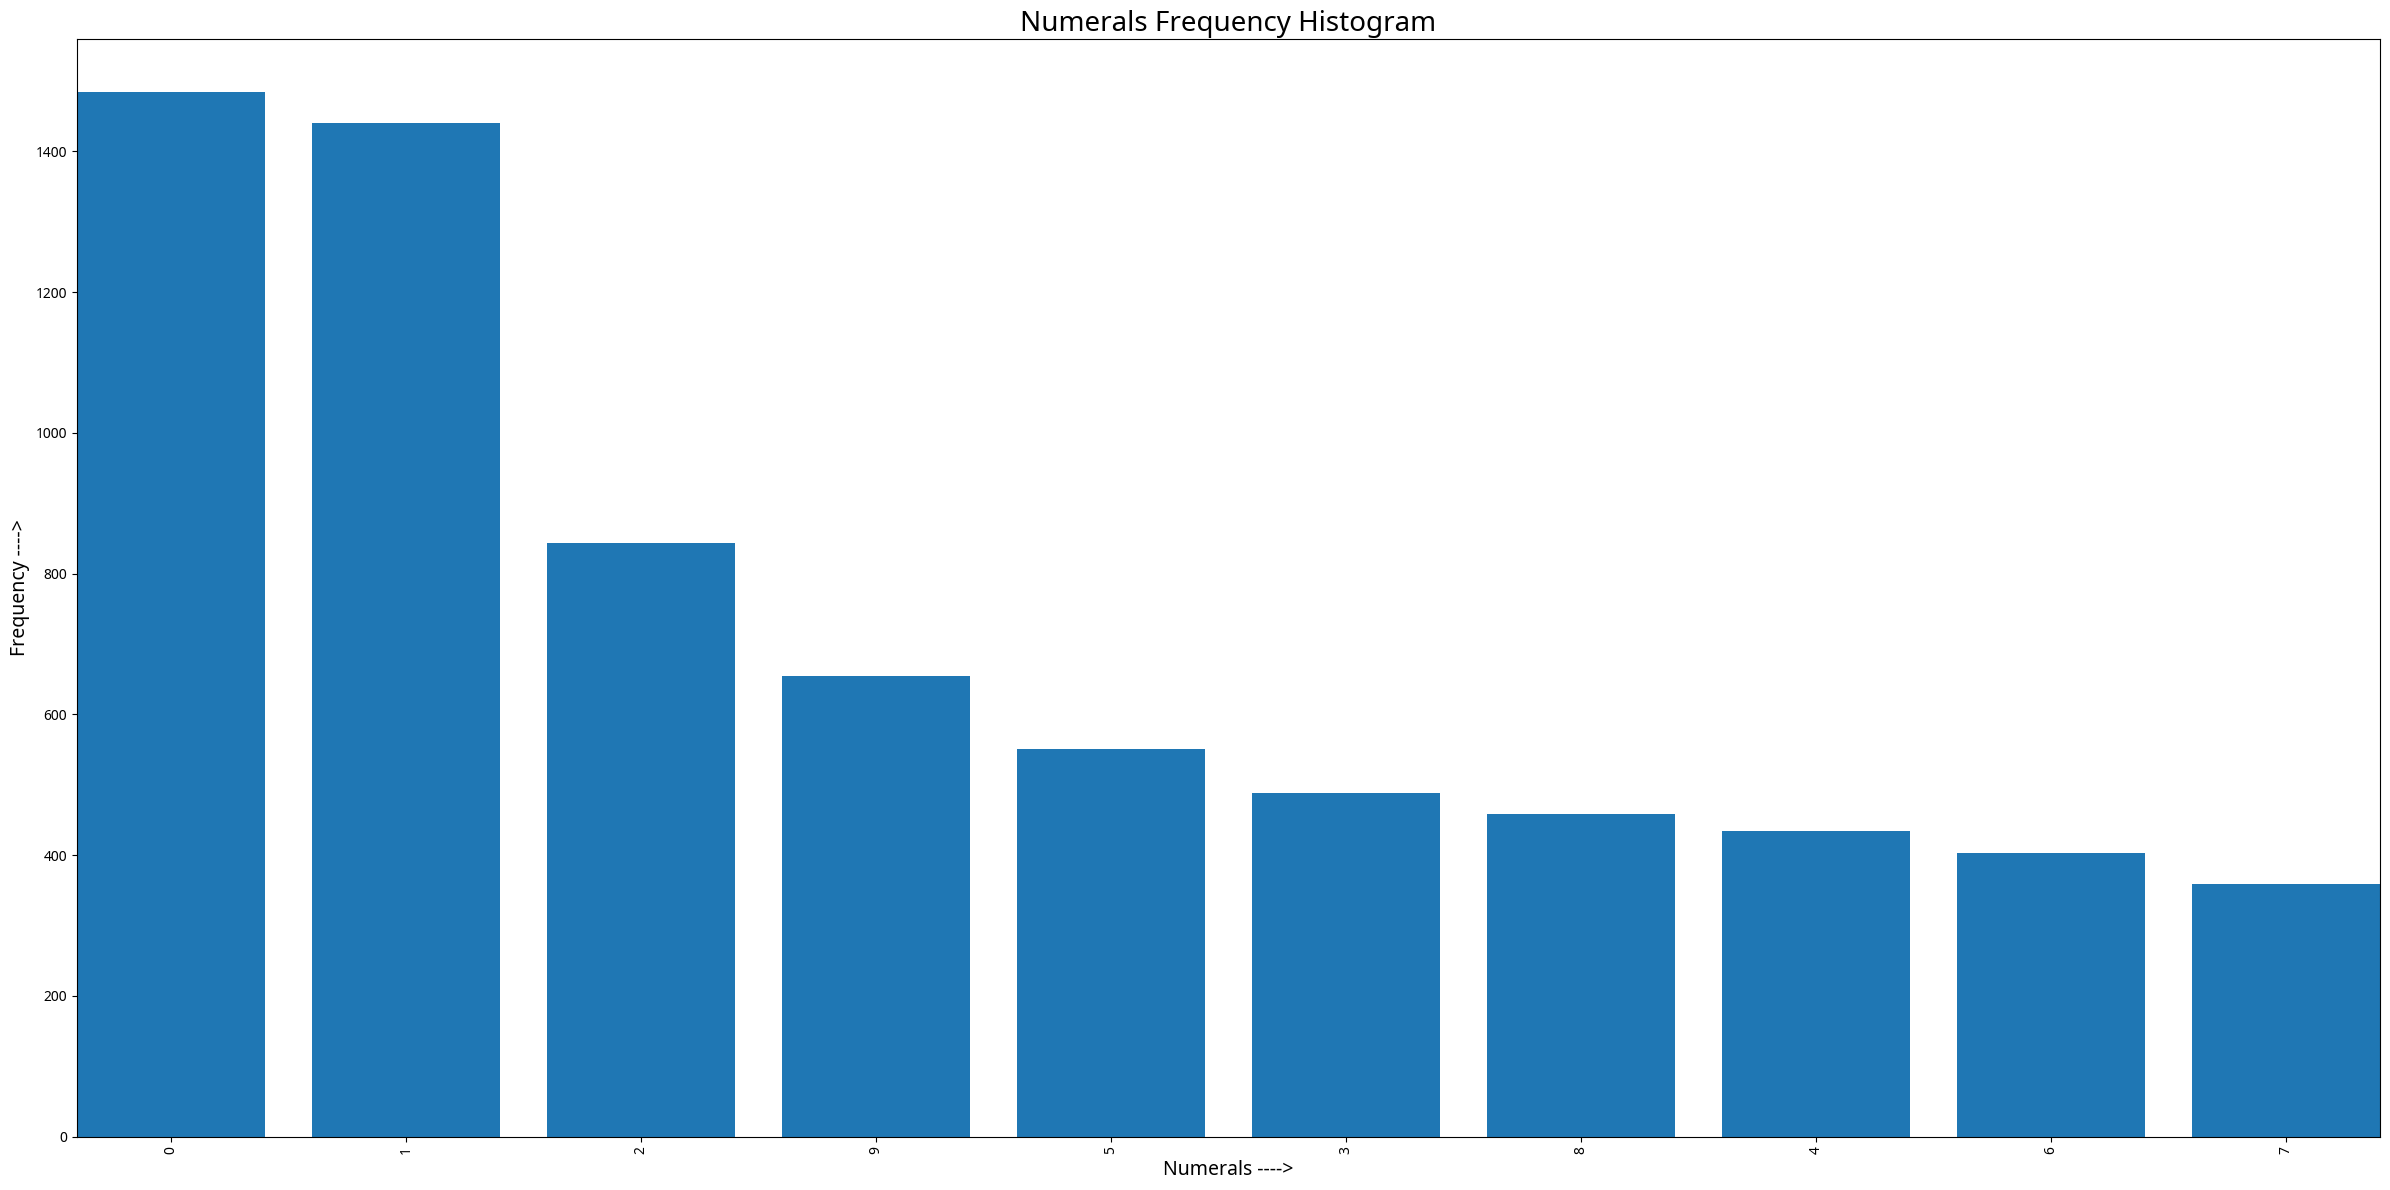

In [501]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")


## Hindi

In [502]:
lang="Hindi"

In [503]:
des=pd.DataFrame(data[f"English-{lang}"]["Validation"]).T
des.head(10)

,source
505511,"Somebody on this side, what will be my goal-test?"
505512,Avoid alcohol and illicit drugs.
505513,"Barley is also used for malt production, which..."
505514,Rana Daggubati shed 15 kilograms for this film...
505515,"Cradle Mountain-Lake St Clair National Park, a..."
505516,"So, it is 512 channels, but the number of loca..."
505517,"Colo-rectal Cancer – Bleeding per rectum, alte..."
505518,"So, if we have queen over here and a queen ove..."
505519,Ortigia has been connected with the rest of th...
505520,Lalitaditya was equally a great builder and he...


In [504]:
print("Size of dataset",len(des))

Size of dataset 11543


### Unique Words

Unique English Words: 31023


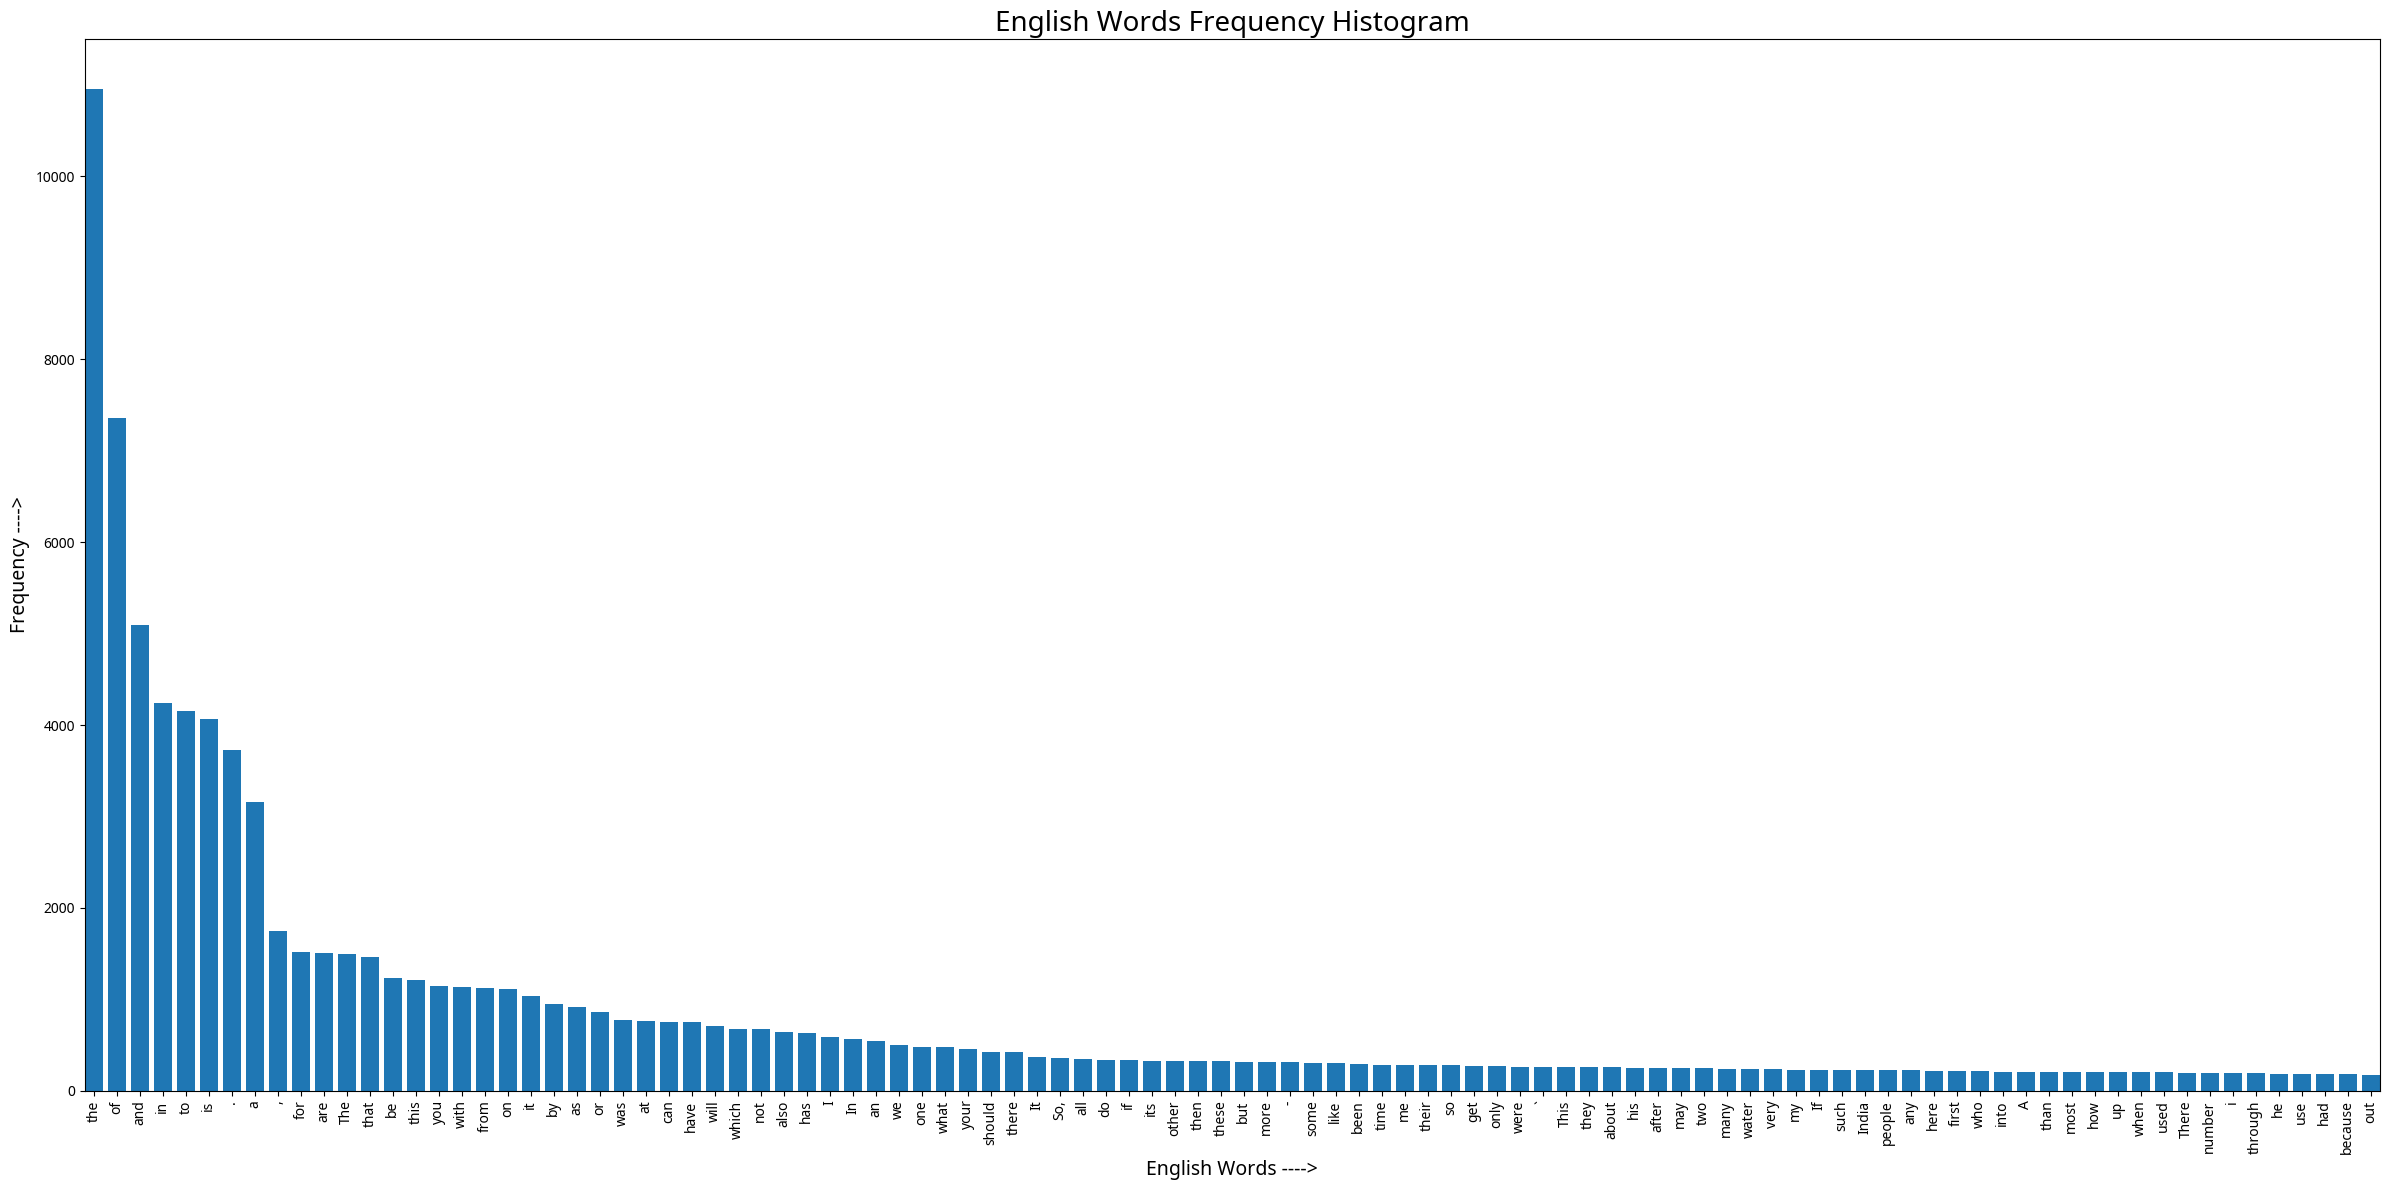

In [505]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 21743


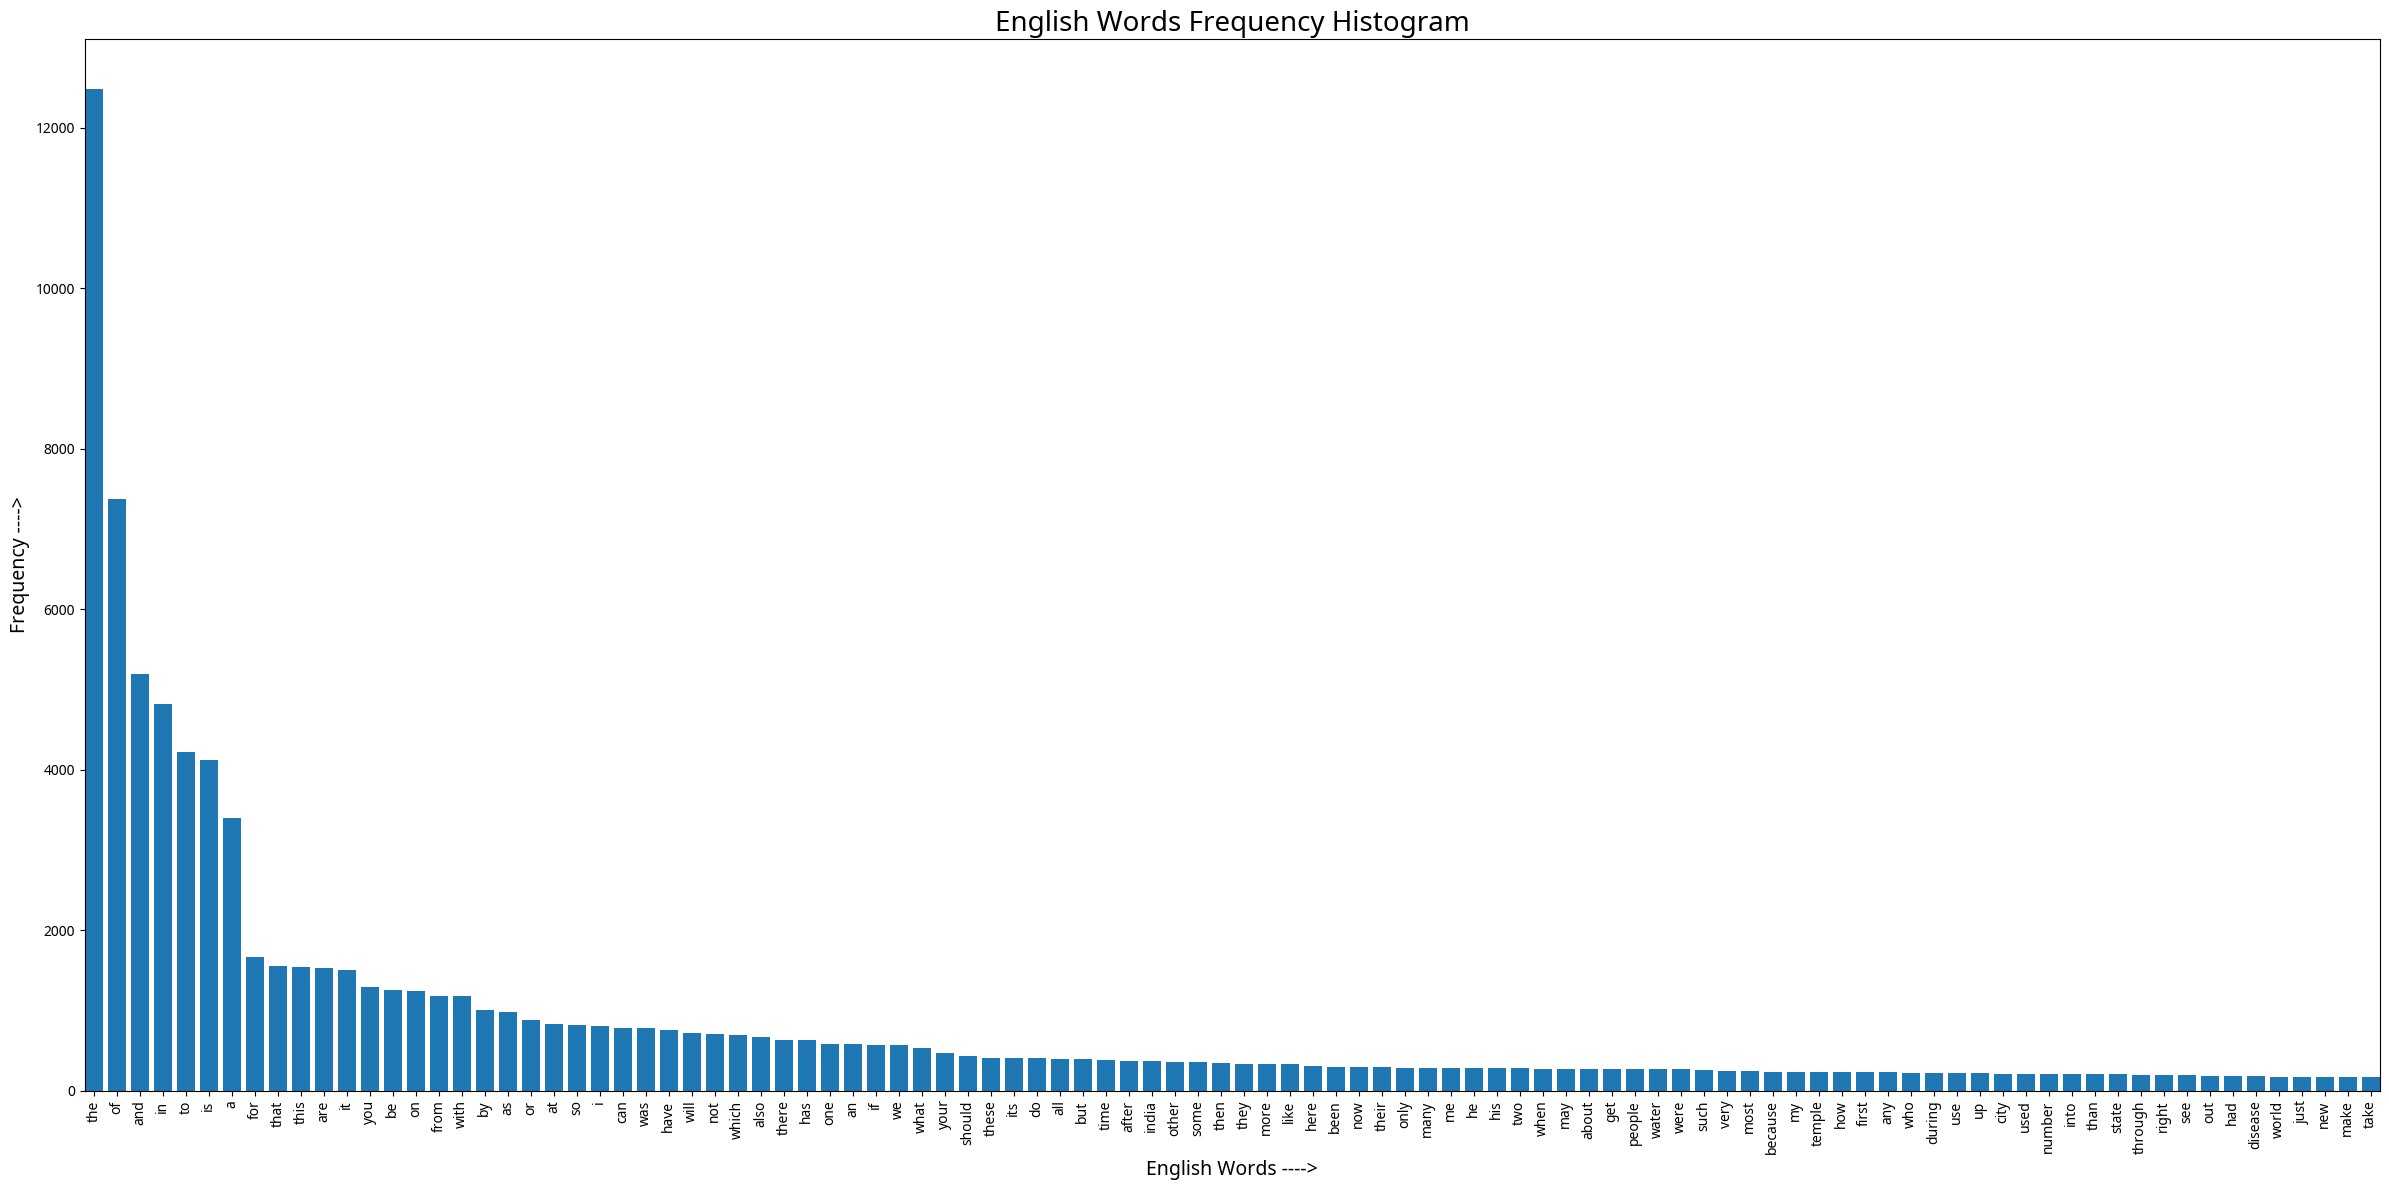

In [506]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

### Entropy

In [507]:
print("Source entropy:",entropy(des_eng))

Source entropy: 10.924262931487476


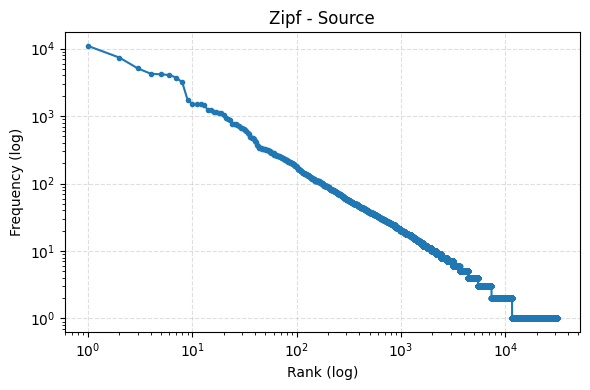

In [508]:
plot_zipf(des_eng, "Zipf - Source")

### Unique Characters

Unique English Characters: 145


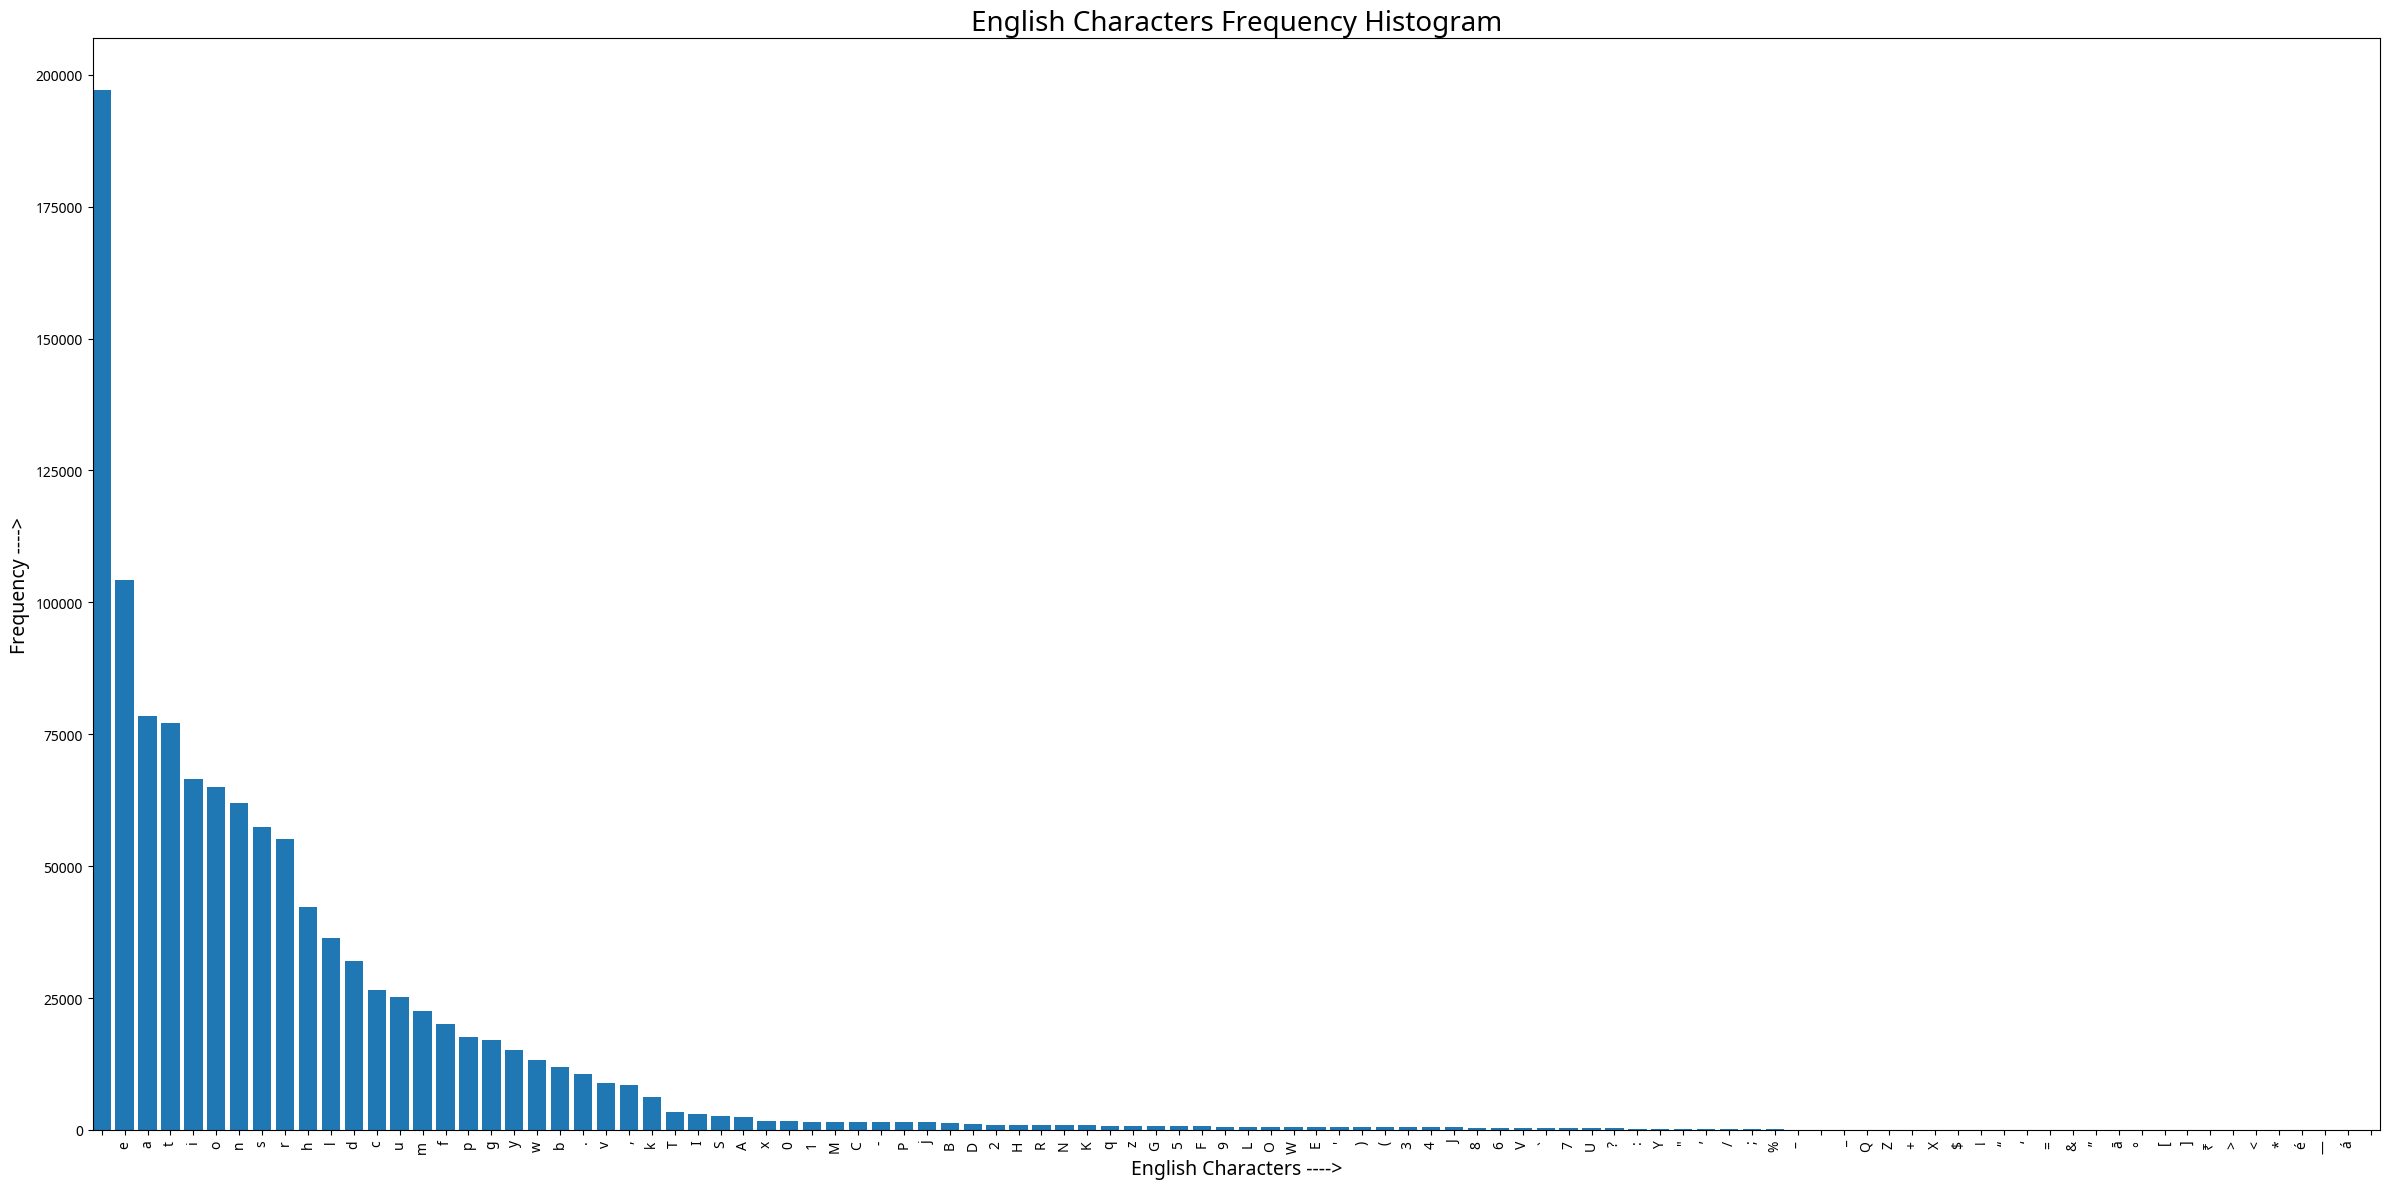

In [509]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

Average English Sentence Length: 17.076236680239106 words


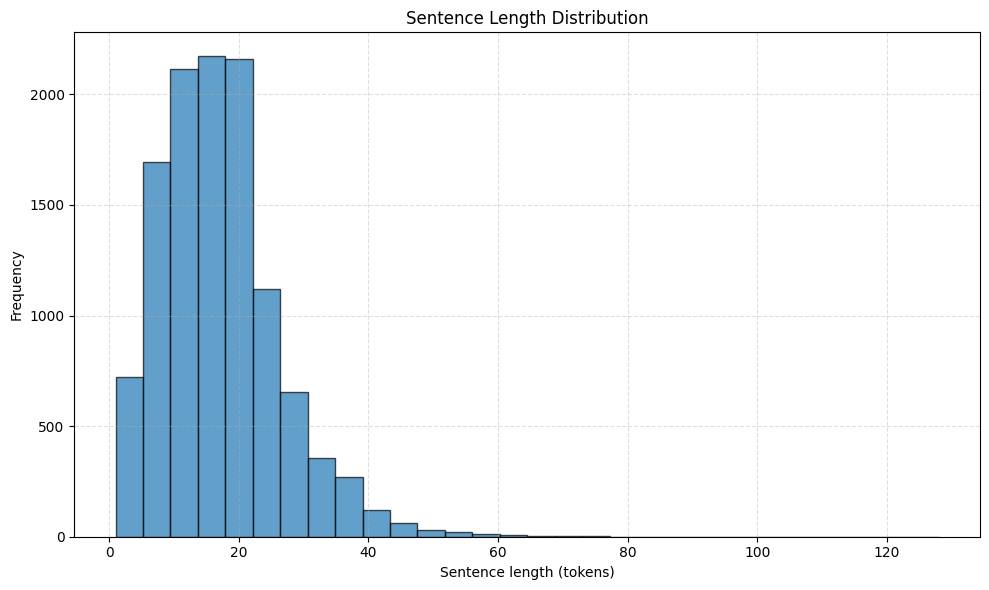

In [510]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

In [511]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))

Source sentence length entropy: 5.098314290927169


### Numerals

Total Latin Script Numeral in dataset: 8116


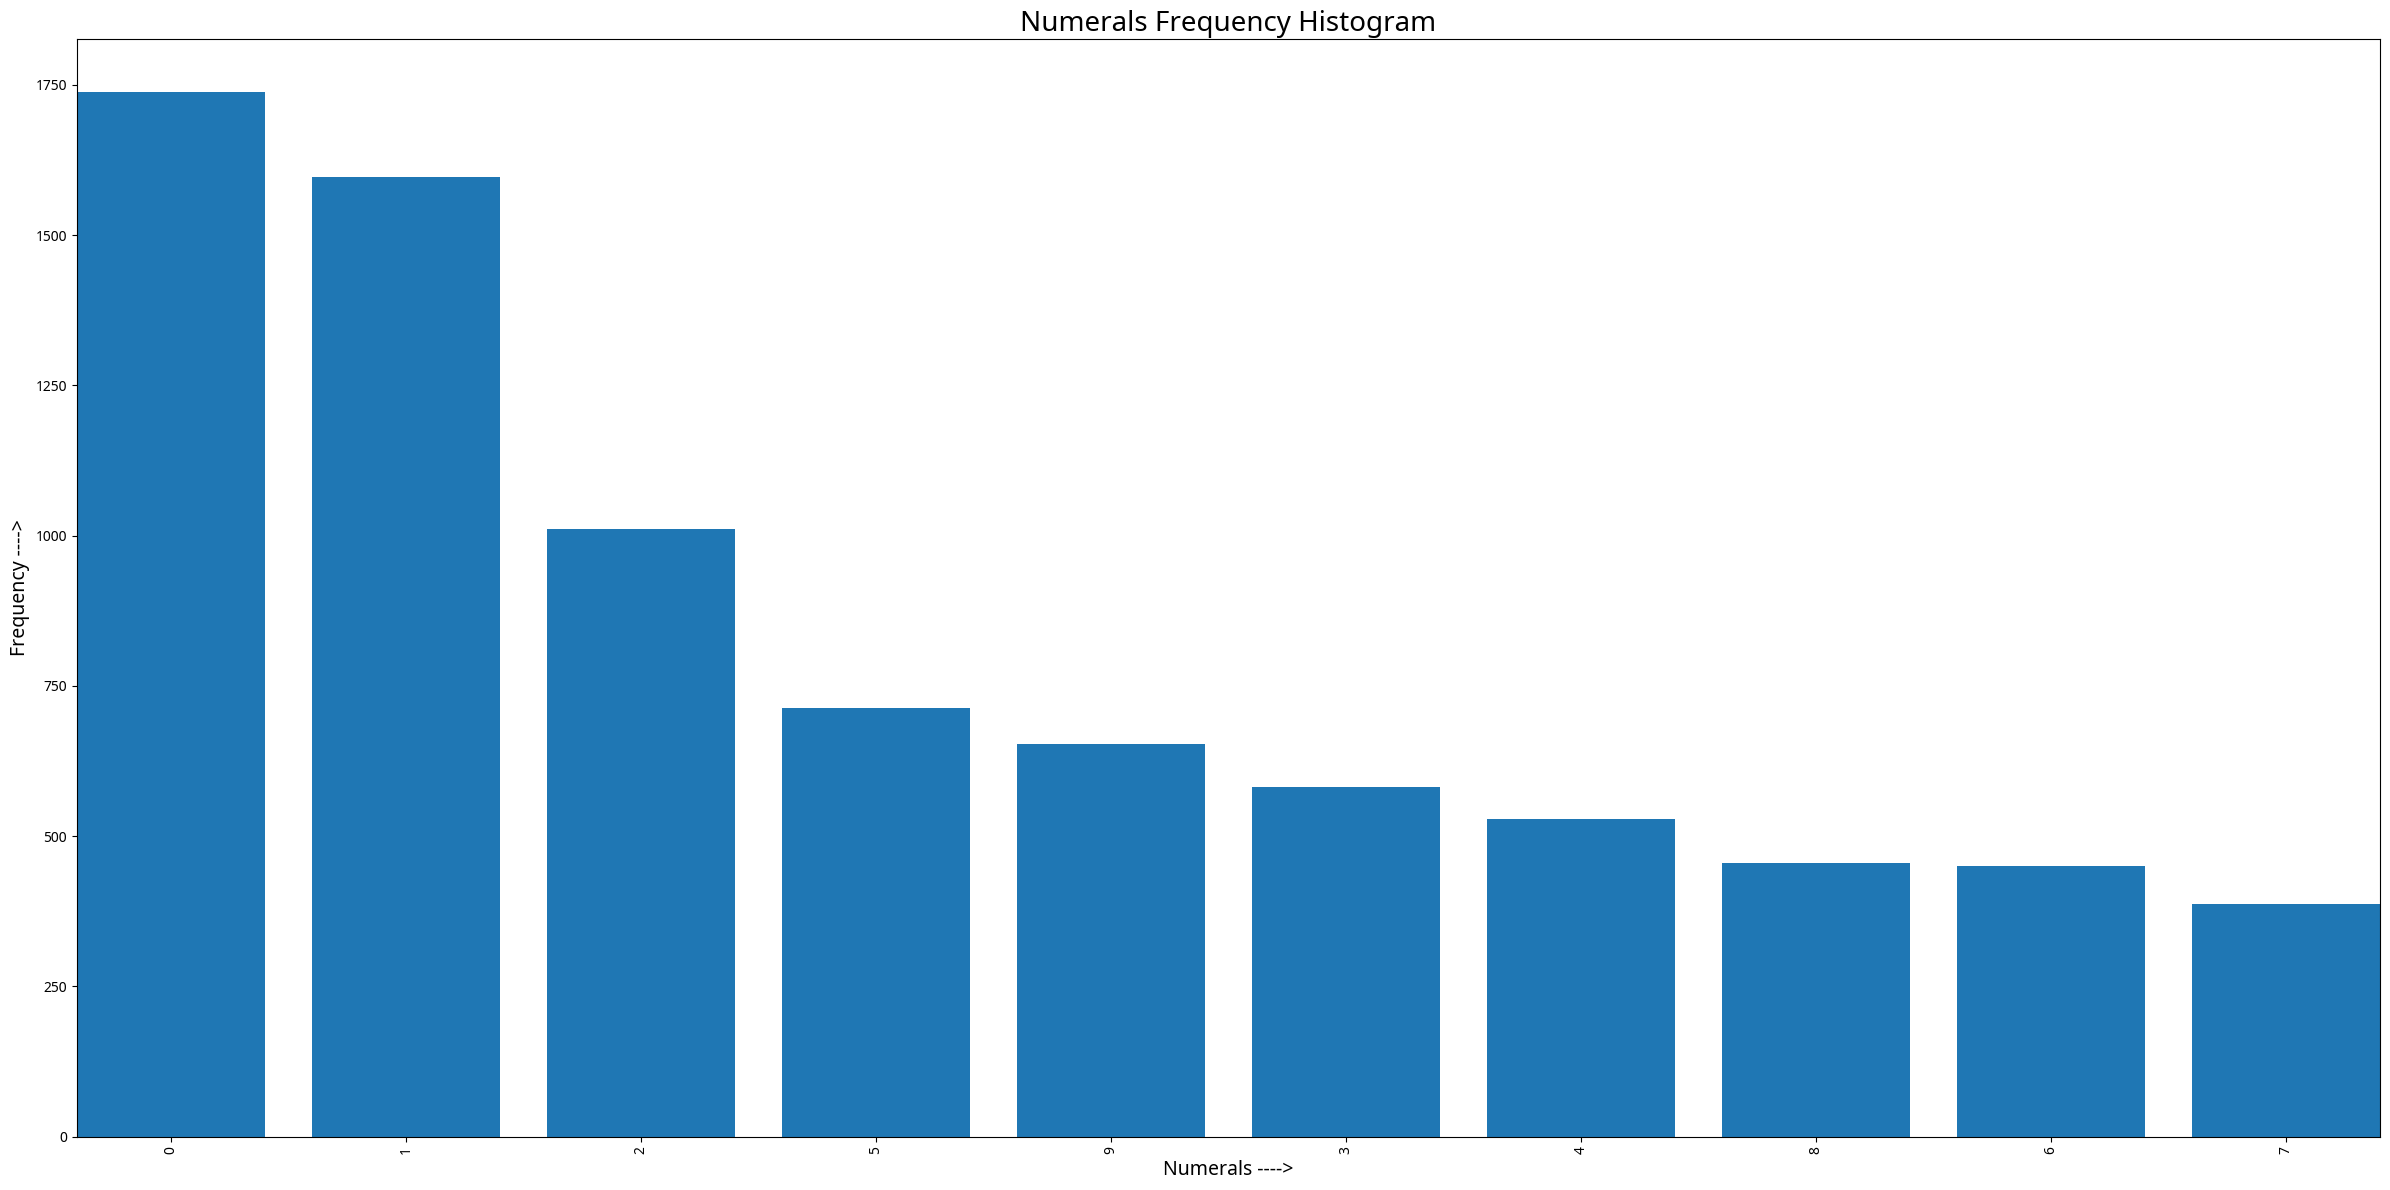

In [512]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")

# Testing

In [ ]:
path = hf_hub_download(
    repo_id="Arnab-Datta-240185/CS779-Capstone-Project",
    filename=f"test_data1.json",
    repo_type="dataset"
)

In [514]:
with open(path, "r") as file:
    data = json.load(file)

## Bengali

In [515]:
lang="Bengali"

In [516]:
des=pd.DataFrame(data[f"English-{lang}"]["Test"]).T
des.head(10)

,source
177039,current events
177040,The god Brahma was pleased with her penance bu...
177041,After feeling stiffness in chest or heaviness ...
177042,As it dawns on him that the baby is in fact hi...
177043,Australia produces significant amounts of lent...
177044,what's with my dinner order
177045,"In an interview with the New York Times, he cl..."
177046,The Chief Justice of the Madras High Court is ...
177047,The funny thing is that near many of the citie...
177048,It makes their Indian identity obvious .


In [517]:
print("Size of dataset",len(des))

Size of dataset 19672


### Unique Words

Unique English Words: 43143


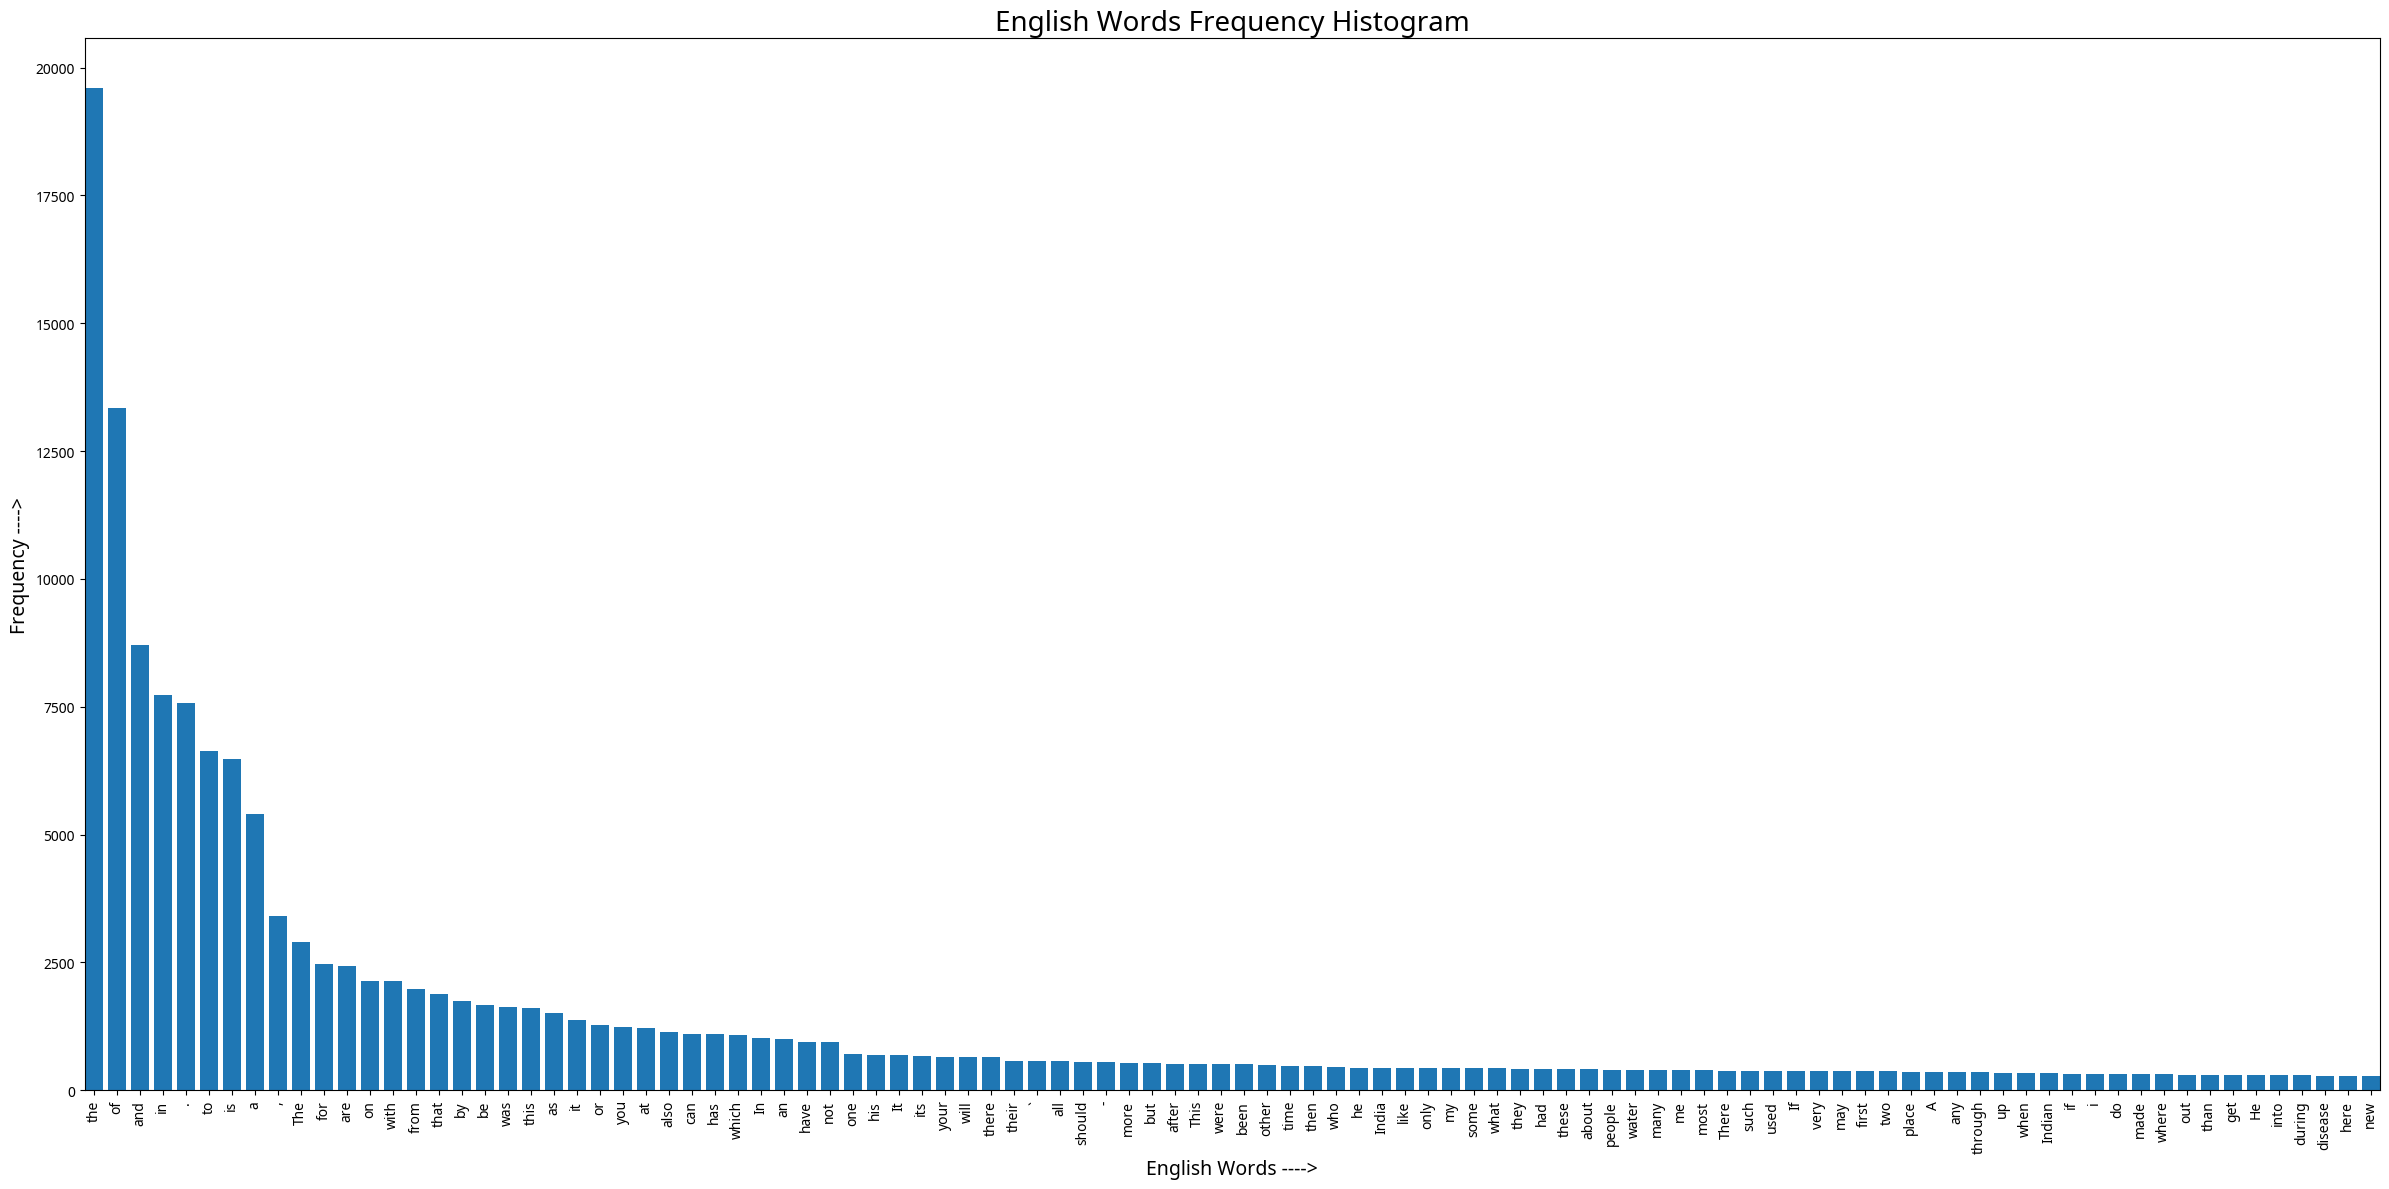

In [518]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 29699


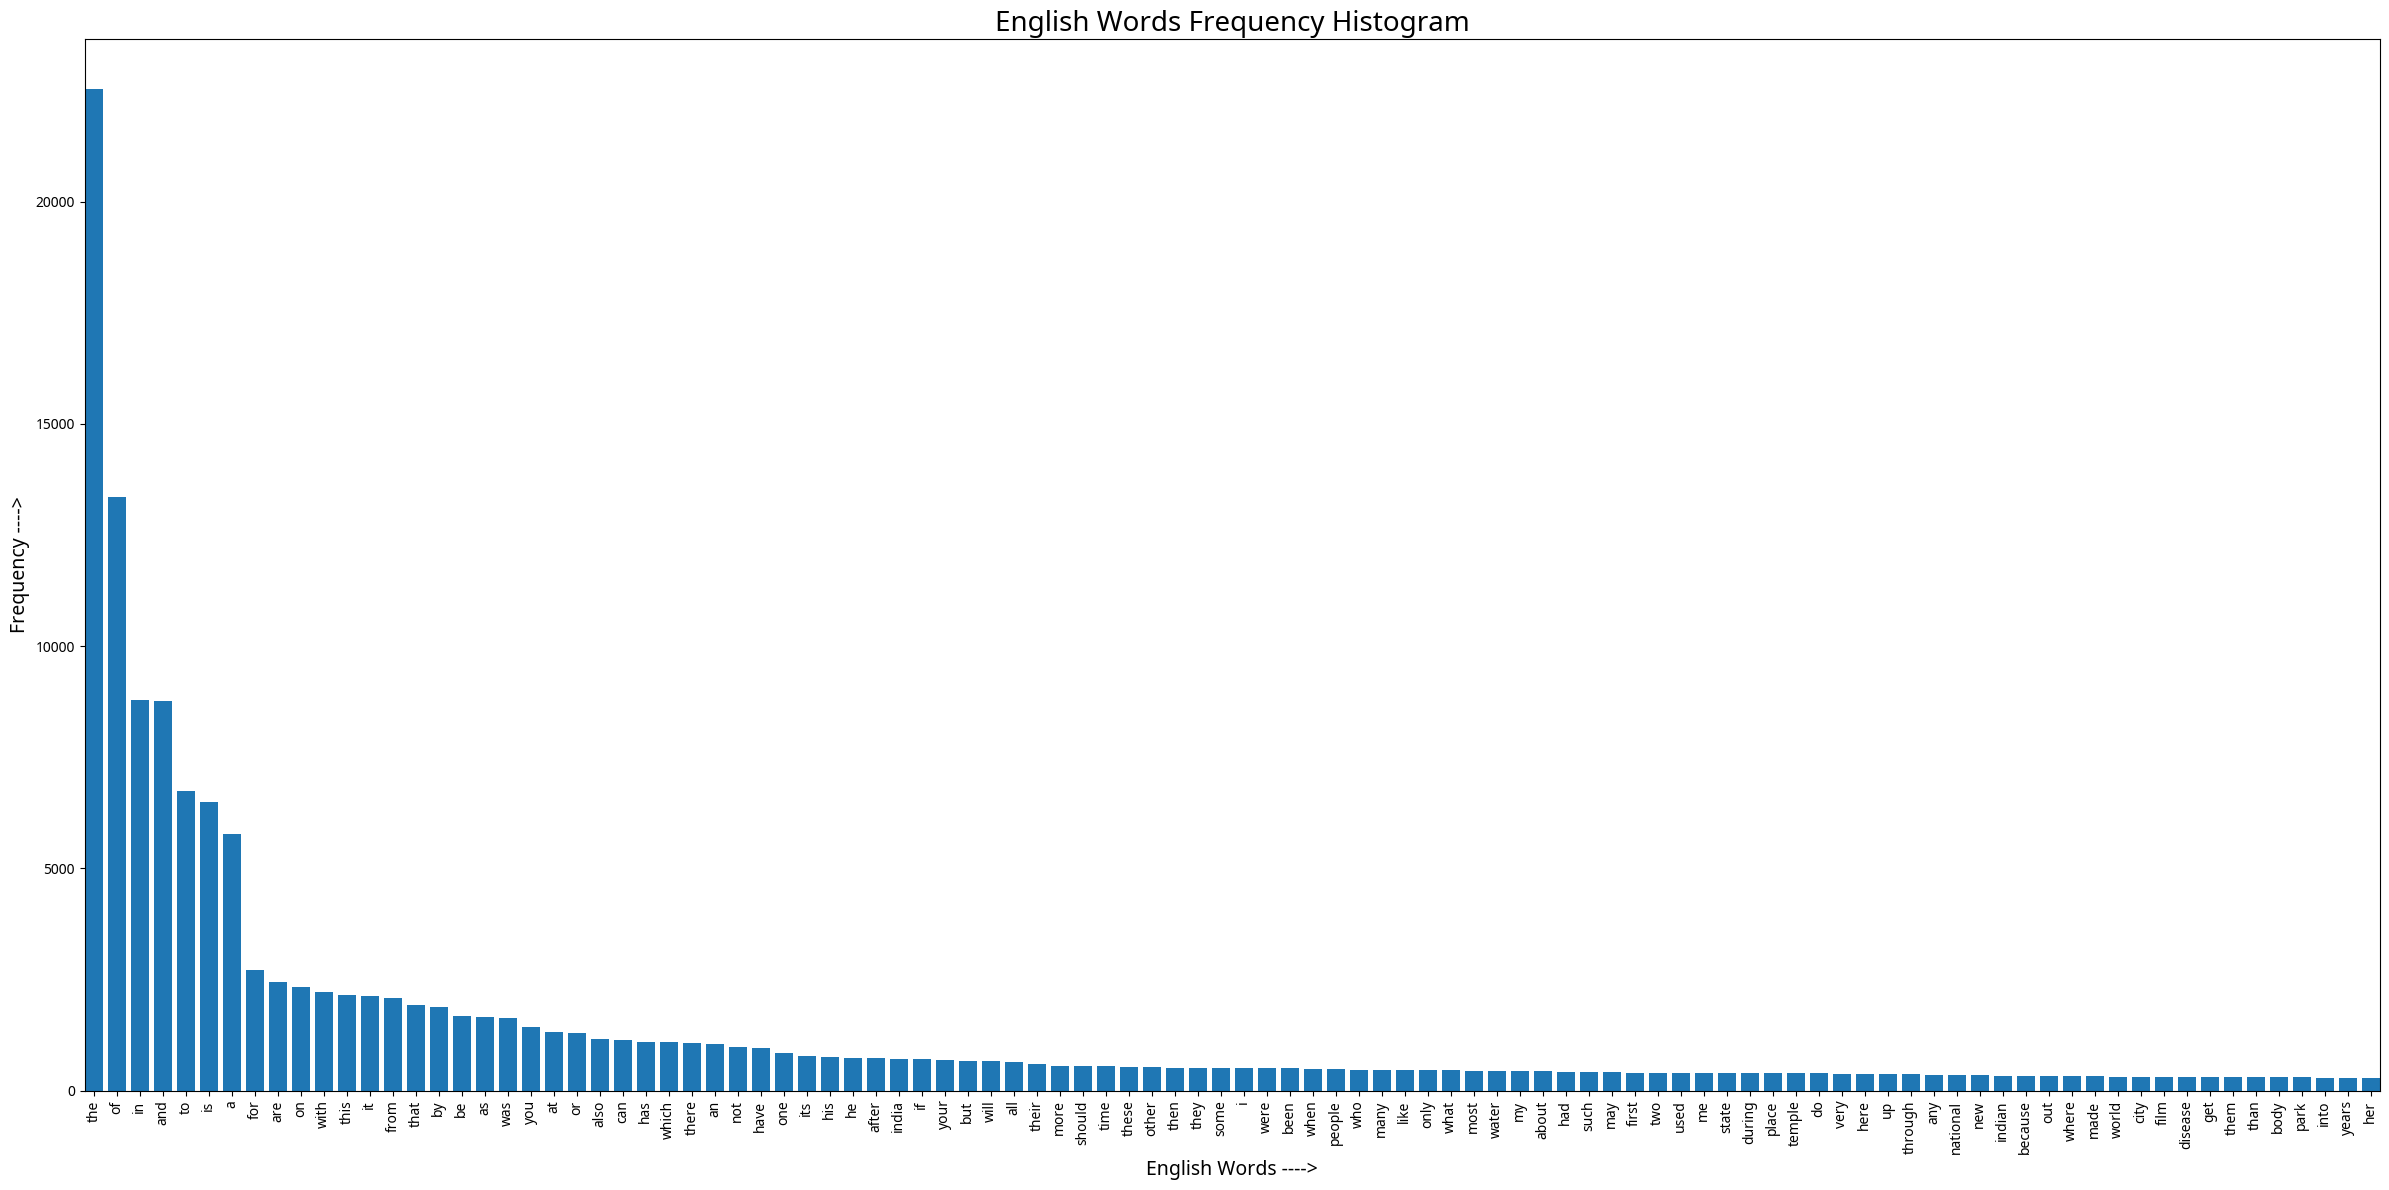

In [519]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

### Entropy

In [520]:
print("Source entropy:",entropy(des_eng))

Source entropy: 11.011939222546959


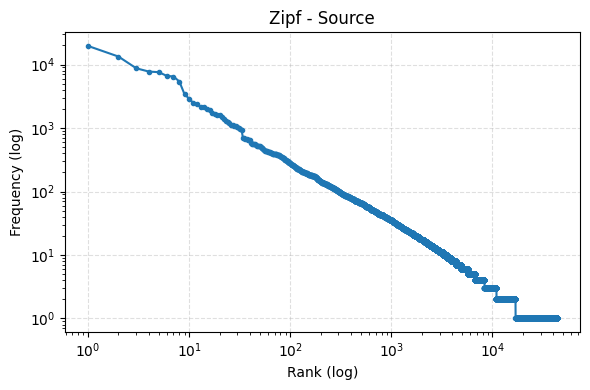

In [521]:
plot_zipf(des_eng, "Zipf - Source")

### Unique Characters

Unique English Characters: 150


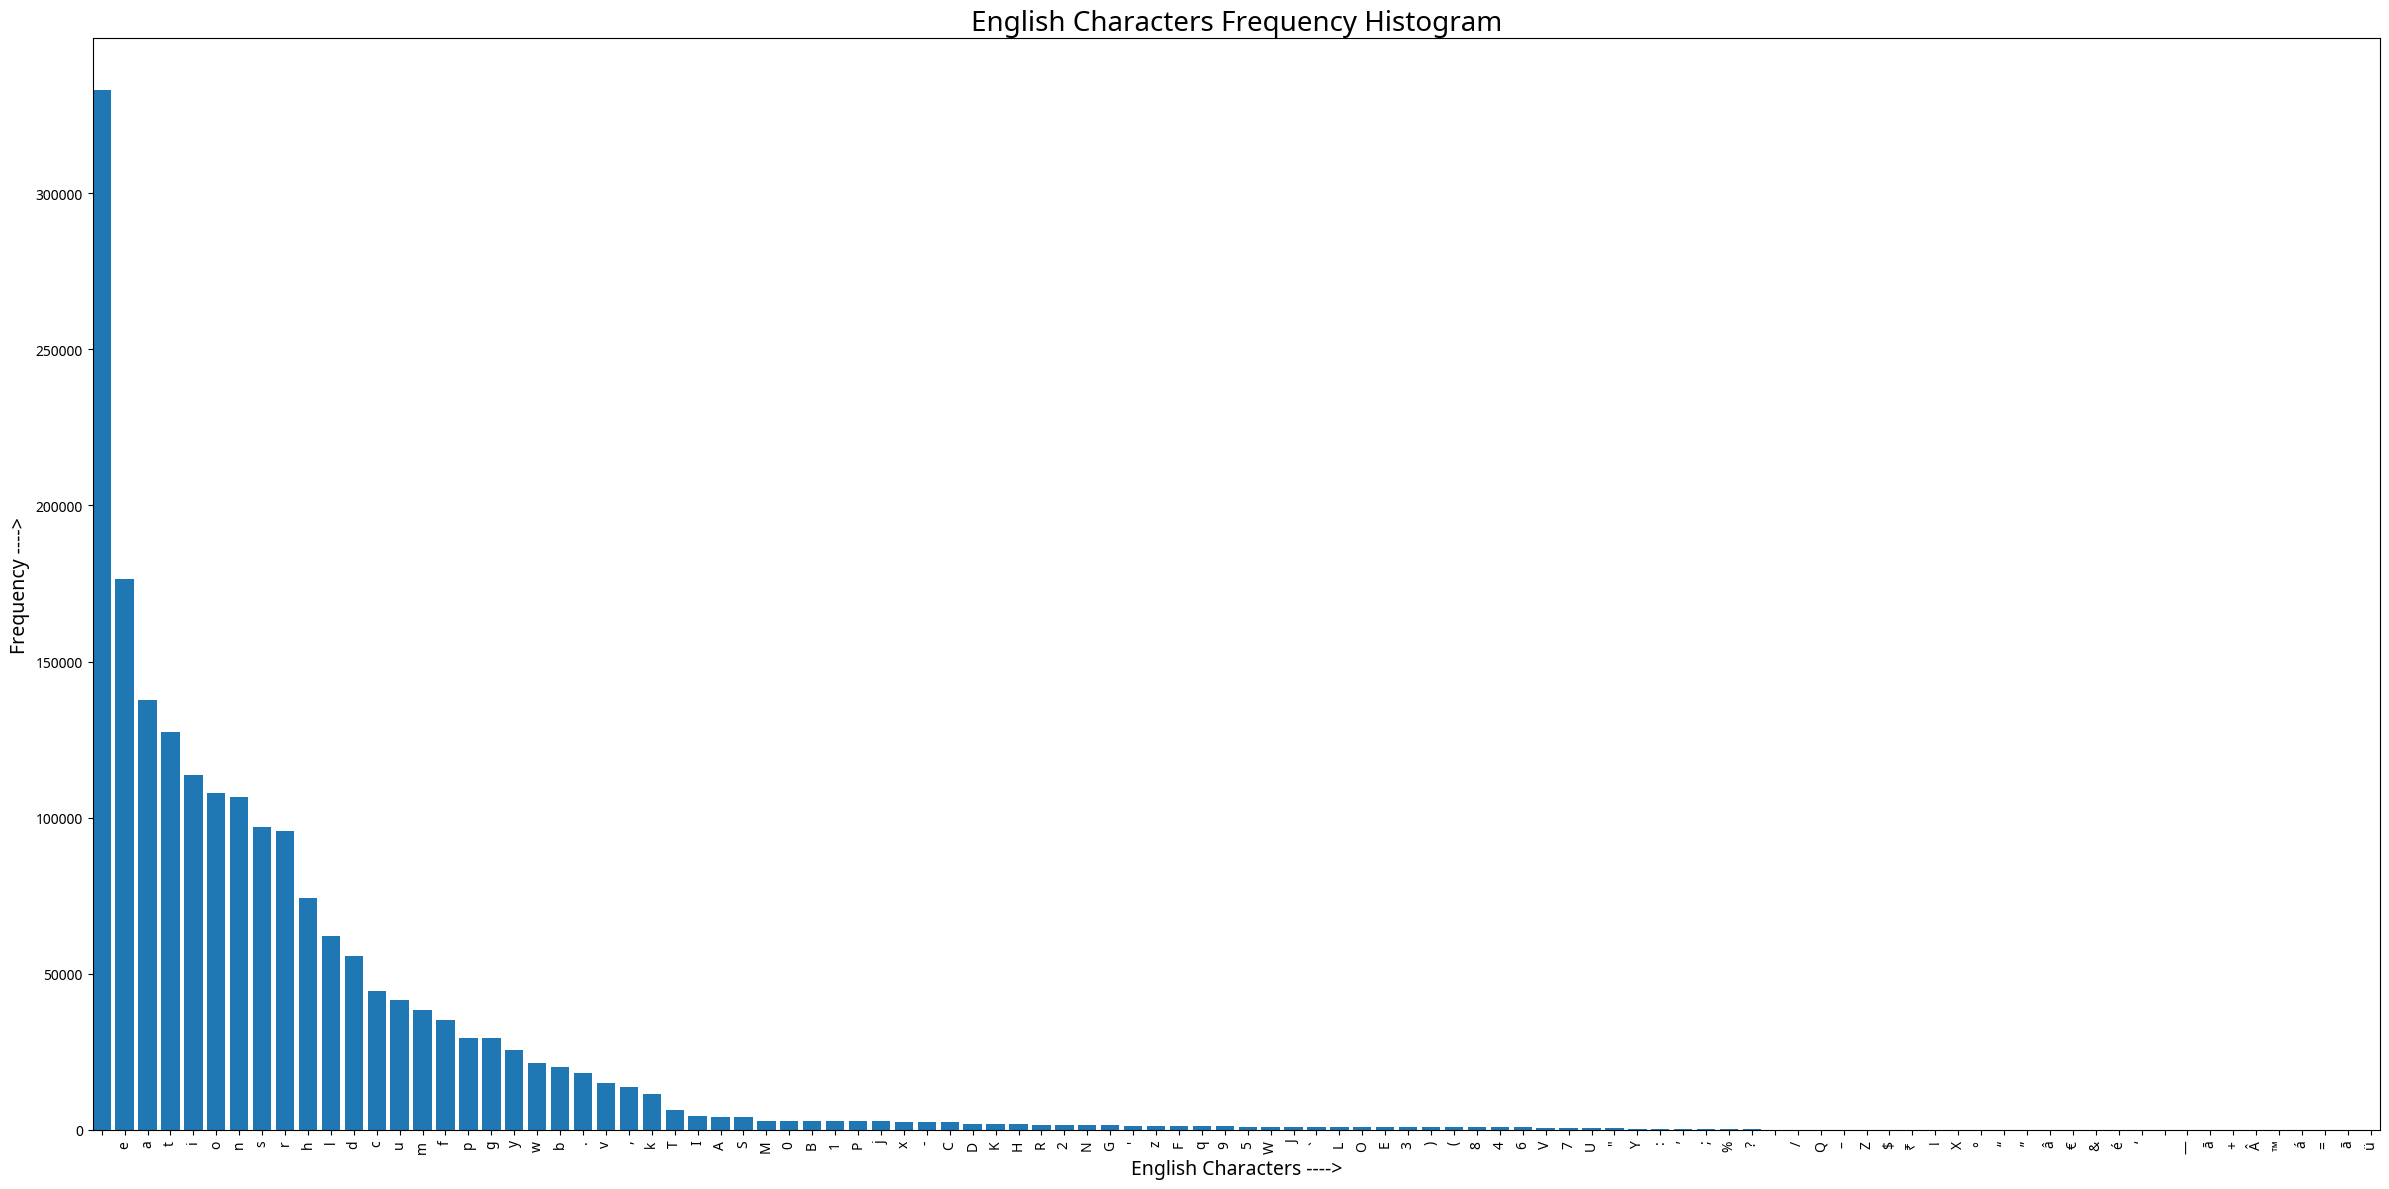

In [522]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

### Sentence Length

Average English Sentence Length: 16.93254371695811 words


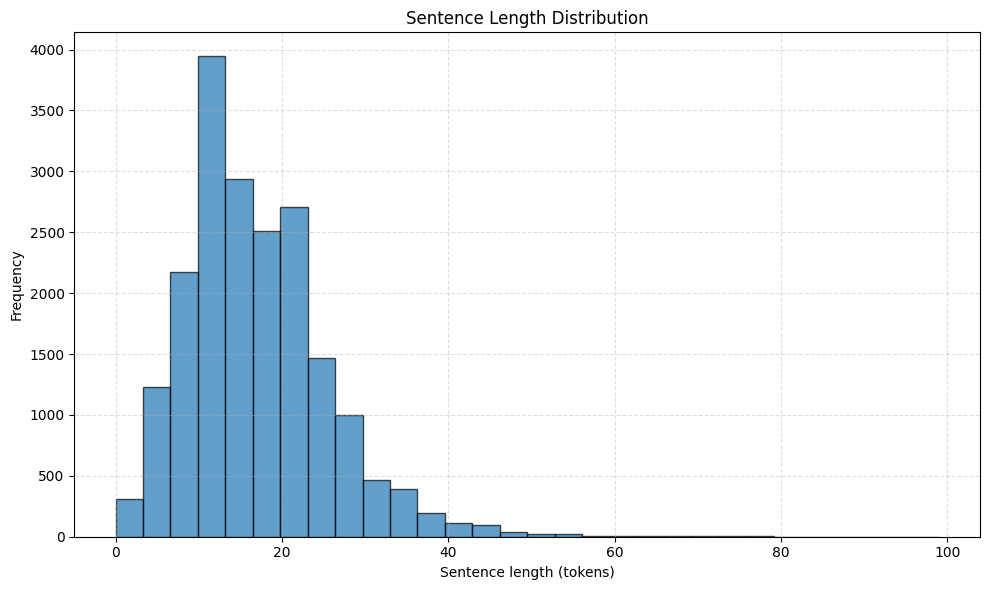

In [523]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

In [524]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))

Source sentence length entropy: 5.0155309511770065


### Numerals

Total Latin Script Numeral in dataset: 13897


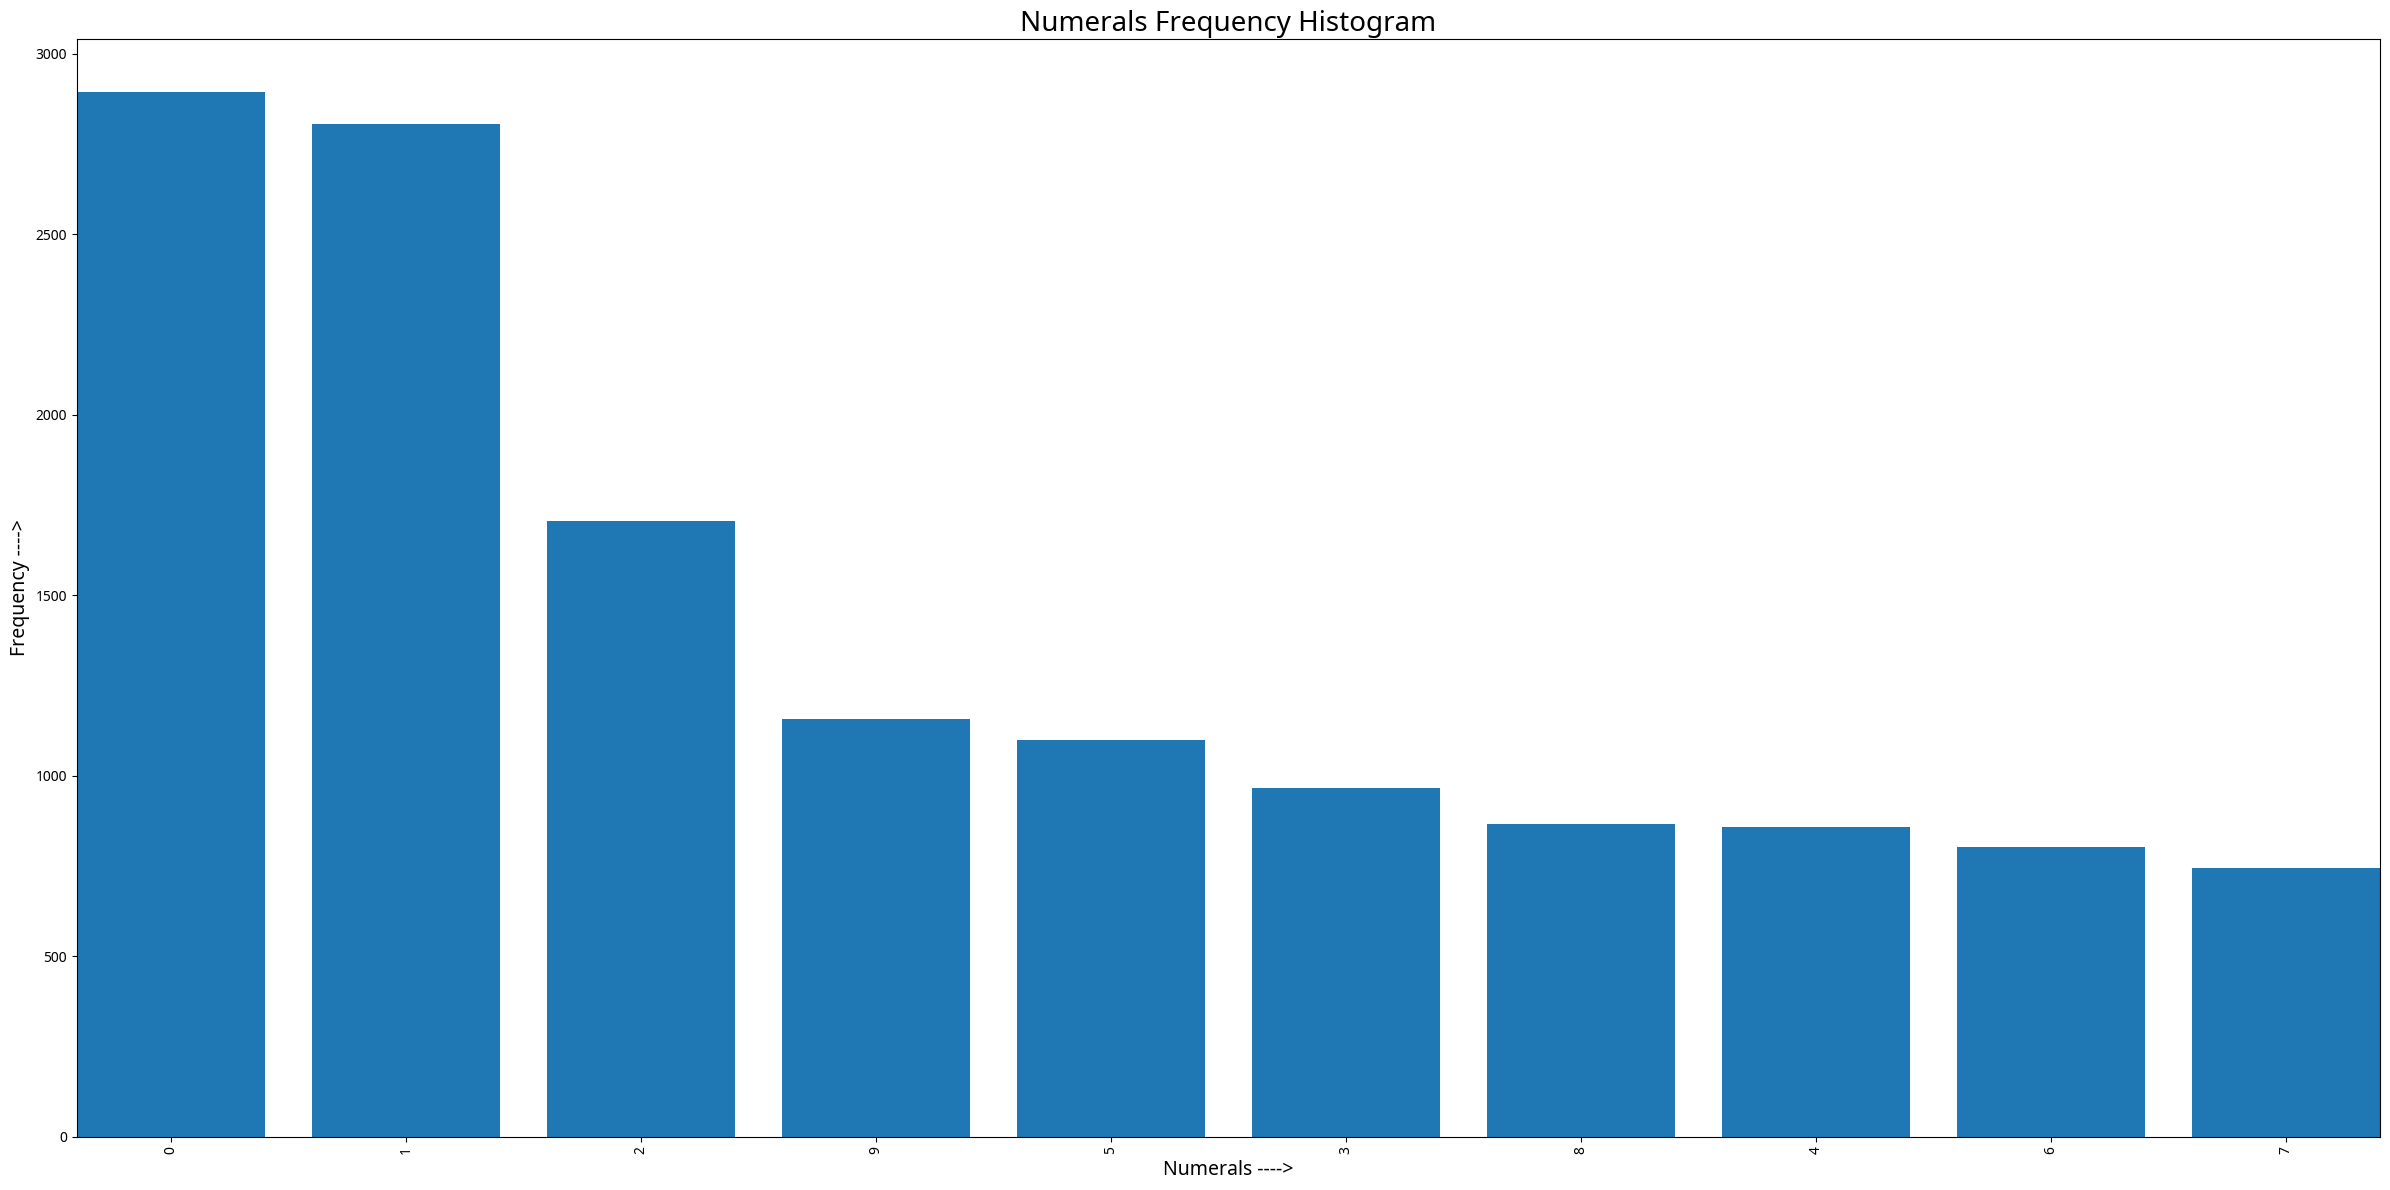

In [525]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")


## Hindi

In [526]:
lang="Hindi"

In [527]:
des=pd.DataFrame(data[f"English-{lang}"]["Test"]).T
des.head(10)

,source
540139,And then we need to assure students that a com...
540140,what is the address for the event scheduled on...
540141,Indira Gandhi National Park is spread in an ar...
540142,Local musicians also attracted the King's atte...
540143,"Of course, do some more stuff on this."
540144,As such this much is fixed that whenever I go ...
540145,So because of such considerations the designer...
540146,"Due to this, the agricultural productivity of ..."
540147,Specialists from around the world are unanimou...
540148,"A great place for trekking, the park offers a ..."


In [528]:
print("Size of dataset",len(des))

Size of dataset 23085


### Unique Words

Unique English Words: 47932


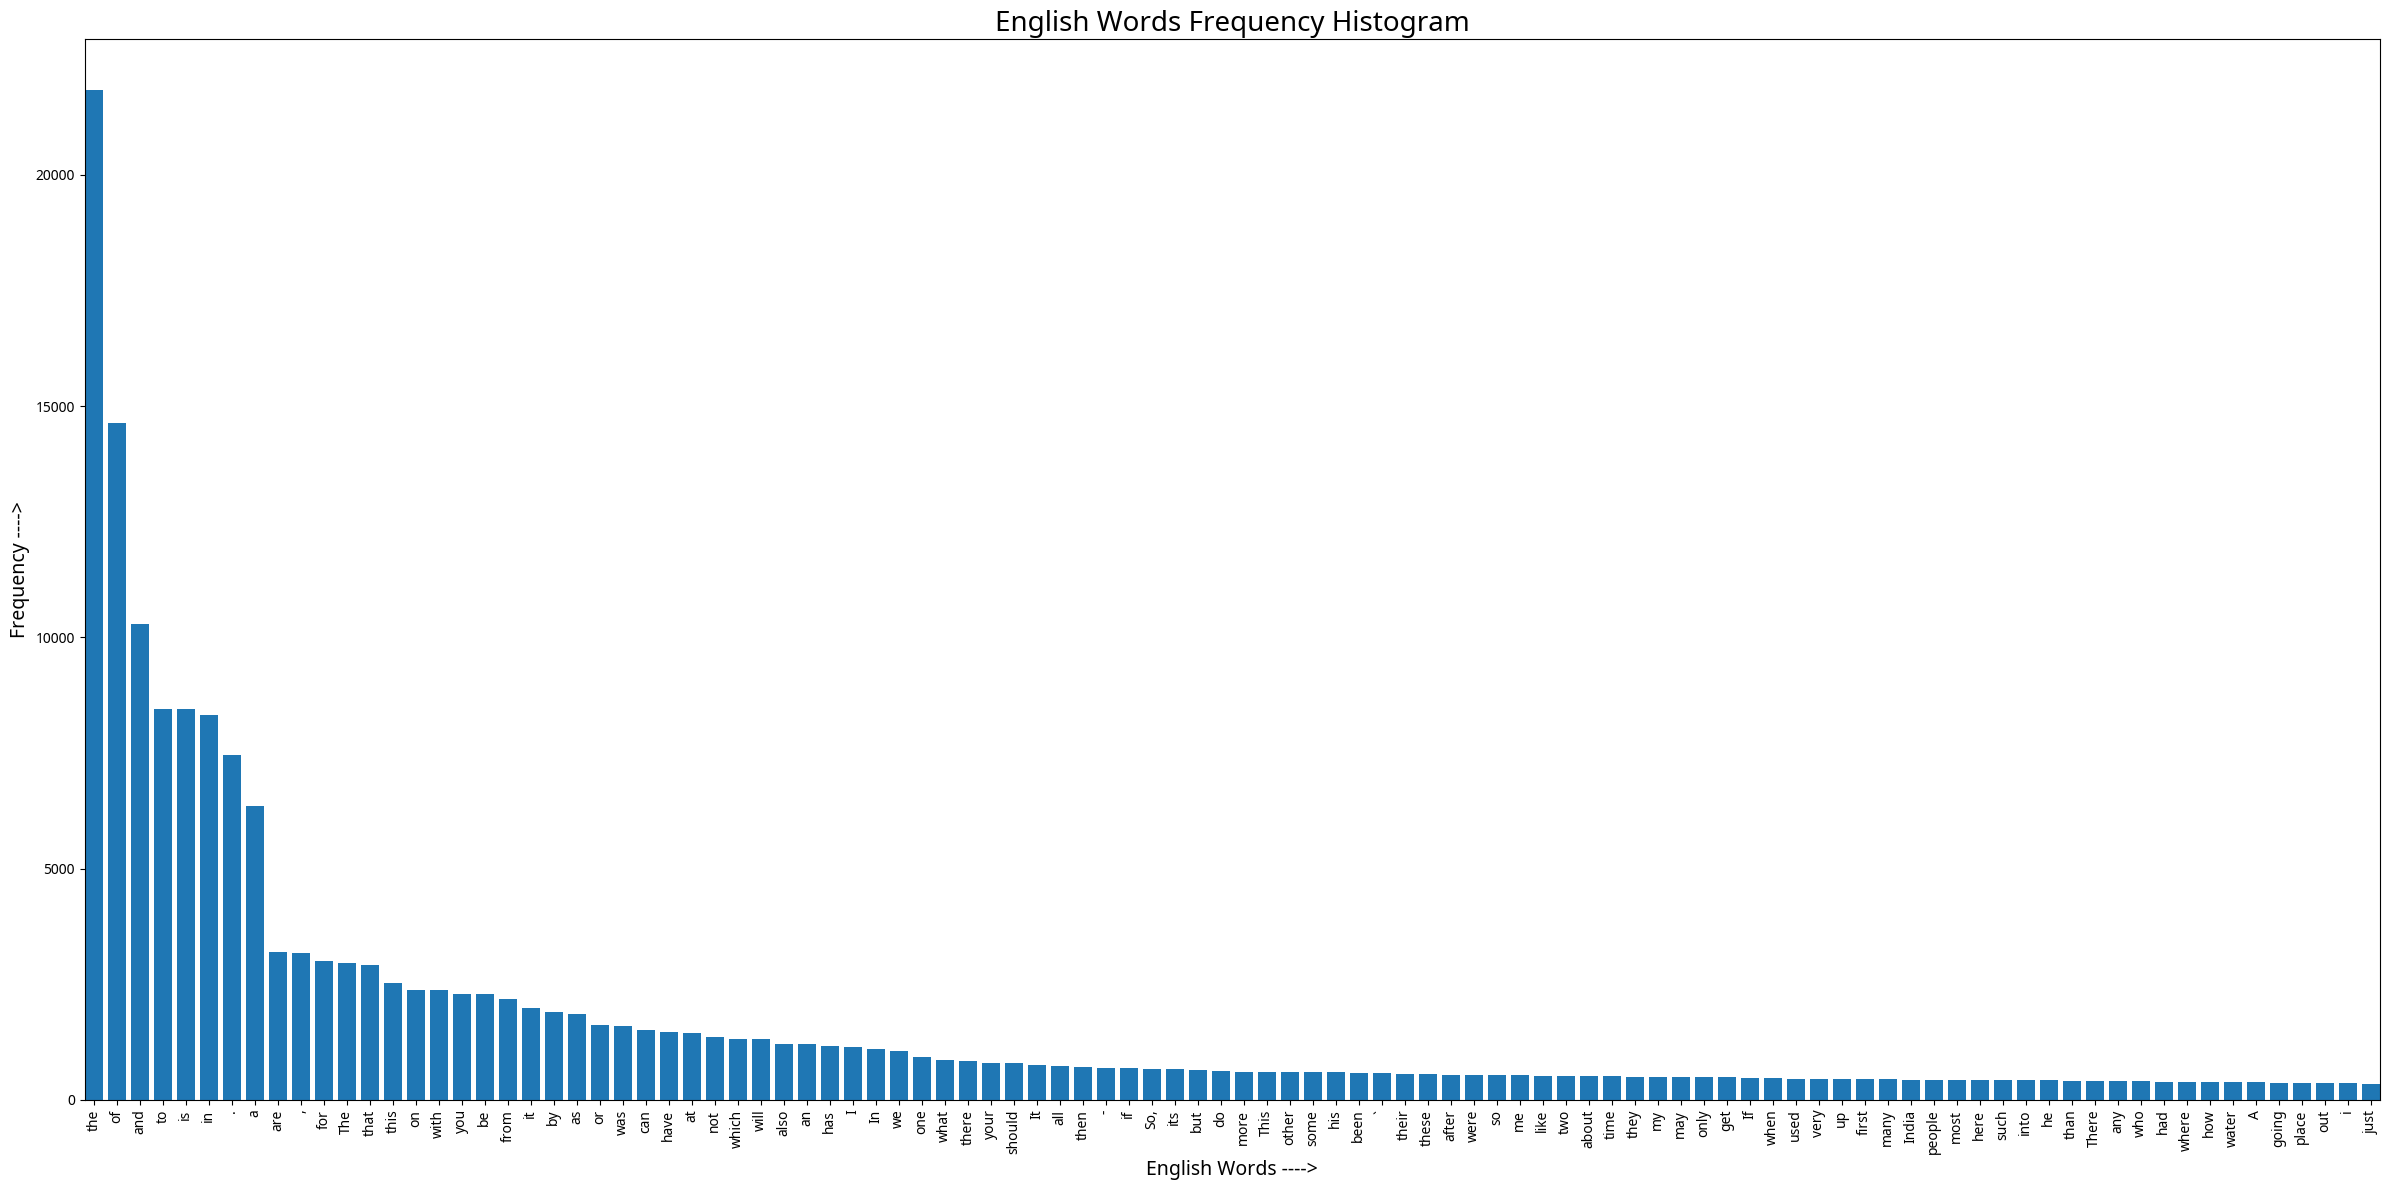

In [529]:
des_eng=Counter((" ".join(list(des["source"]))).split())
print("Unique English Words:",len(des_eng))
plot_top(des_eng.most_common(100),"English Words")

Unique Lower English Words: 31606


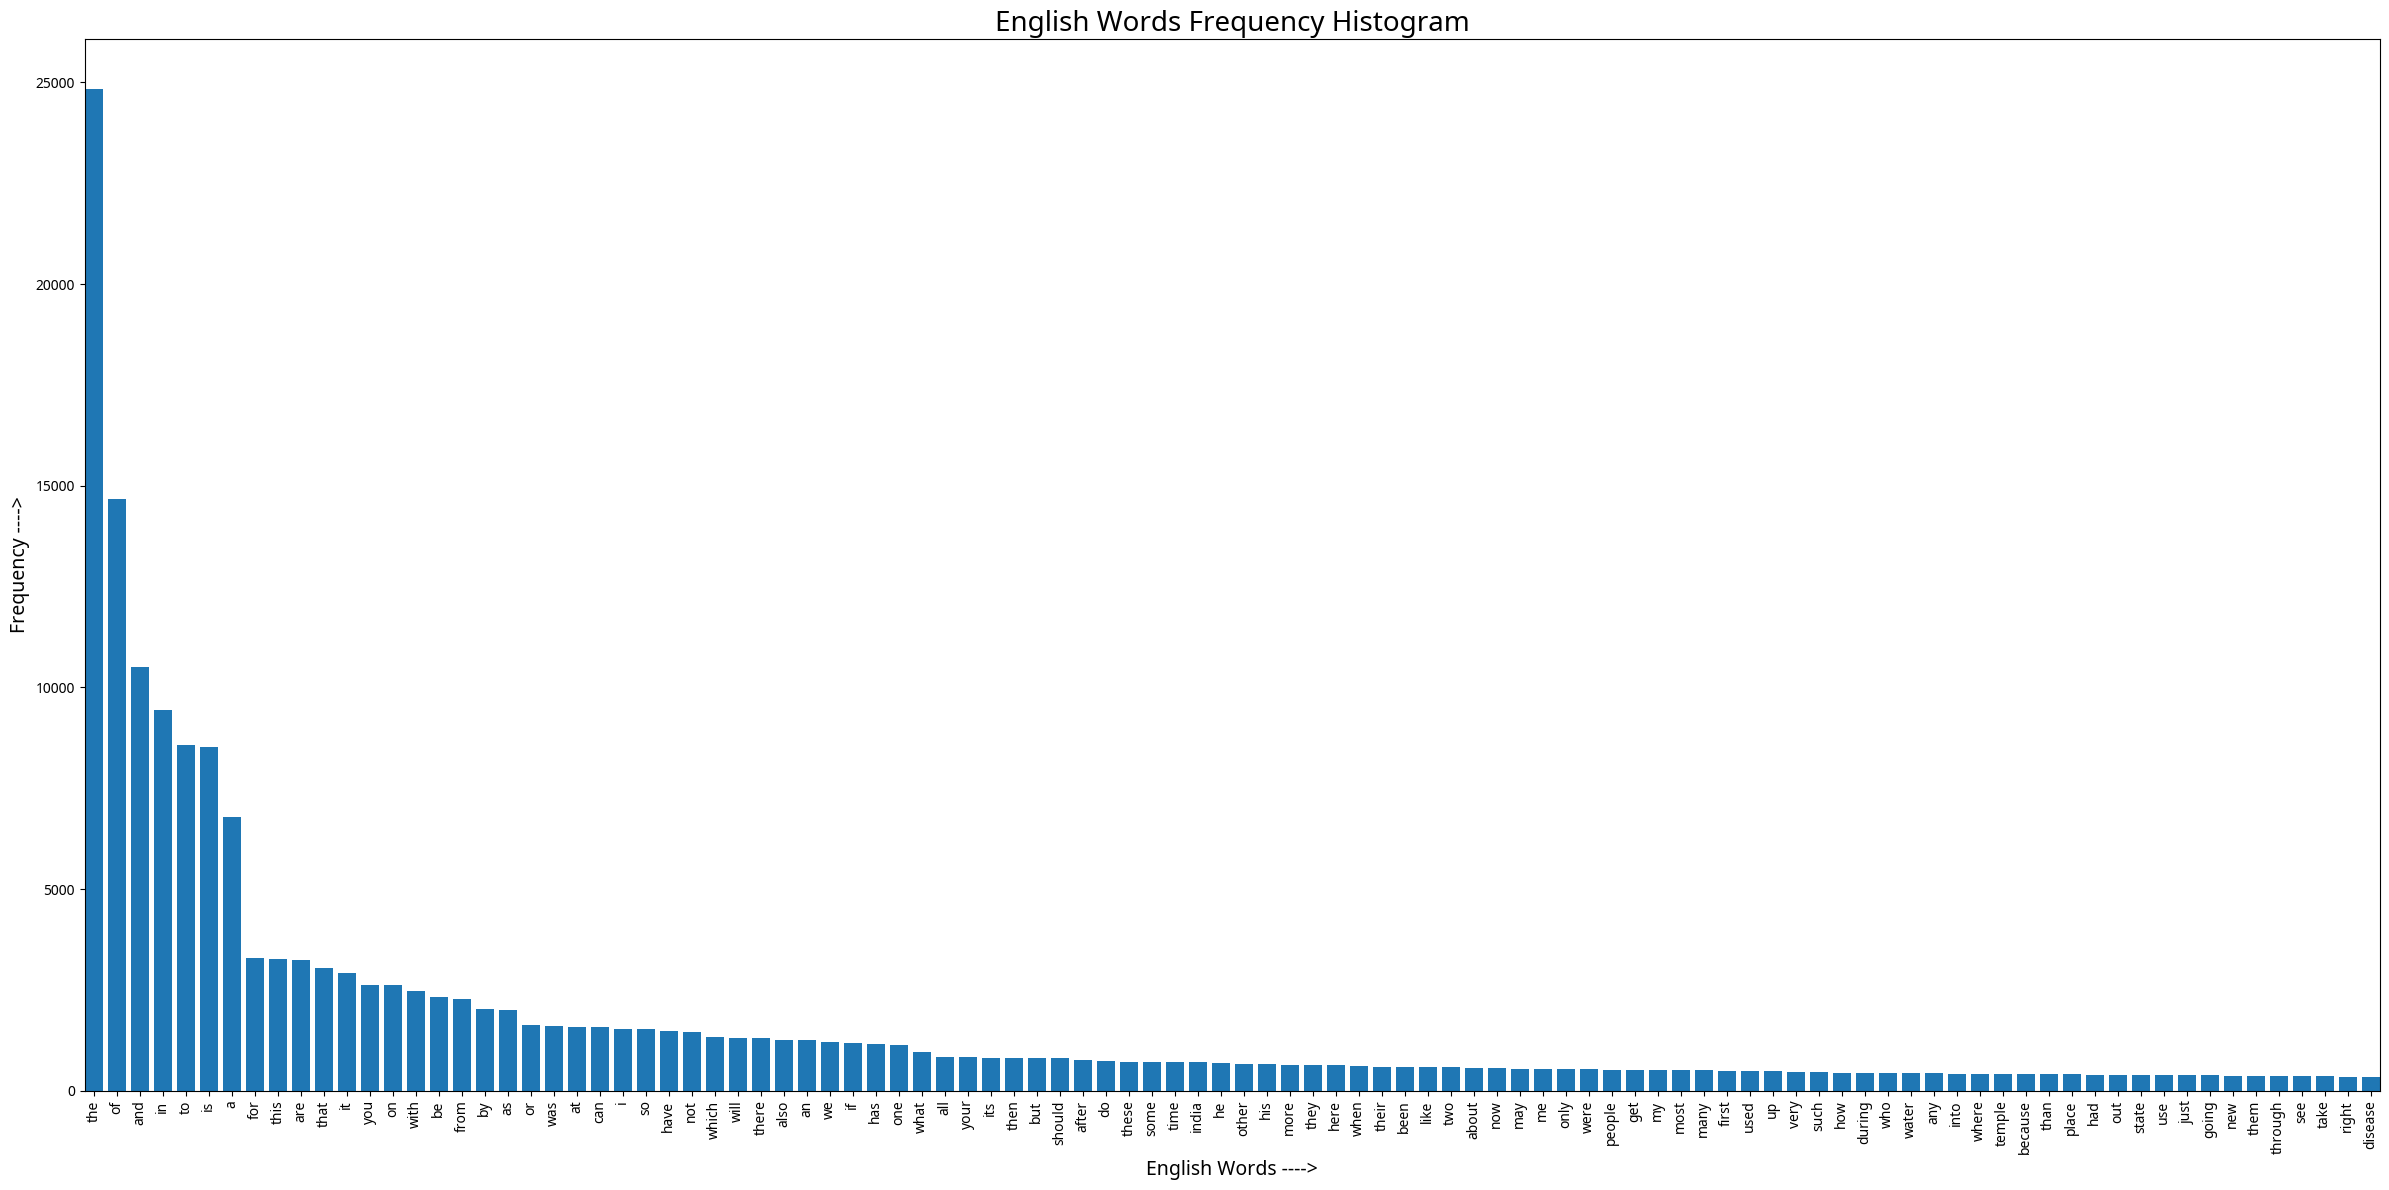

In [530]:
des_eng_low=Counter(re.sub(r"[^\w\s]","",(" ".join(list(des["source"])))).lower().split())
print("Unique Lower English Words:",len(des_eng_low))
plot_top(des_eng_low.most_common(100),"English Words")

### Entropy

In [531]:
print("Source entropy:",entropy(des_eng))

Source entropy: 11.058944265942477


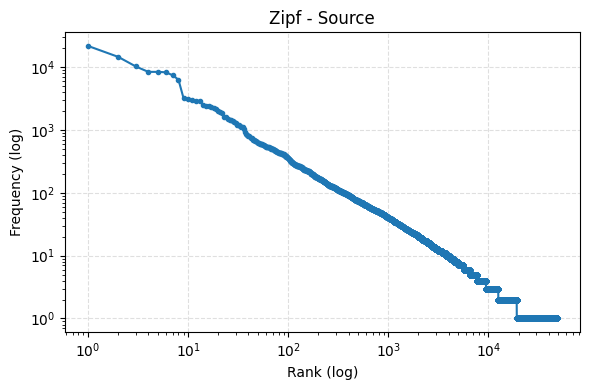

In [532]:
plot_zipf(des_eng, "Zipf - Source")

### Unique Characters

Unique English Characters: 194


/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Glyph 3405 (\N{MALAYALAM SIGN VIRAMA}) missing from font(s) Noto Sans Devanagari, Noto Sans.
  plt.tight_layout()
/tmp/ipykernel_8158/1062475222.py:21: UserWarning: Matplotlib currently does not support Malayalam natively.
  plt.tight_layout()
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 3405 (\N{MALAYALAM SIGN VIRAMA}) missing from font(s) Noto Sans Devanagari, Noto Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arnab/miniconda3/envs/CS779/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Matplotlib currently does not support Malayalam natively.
  fig.canvas.print_figure(bytes_io, **kw)


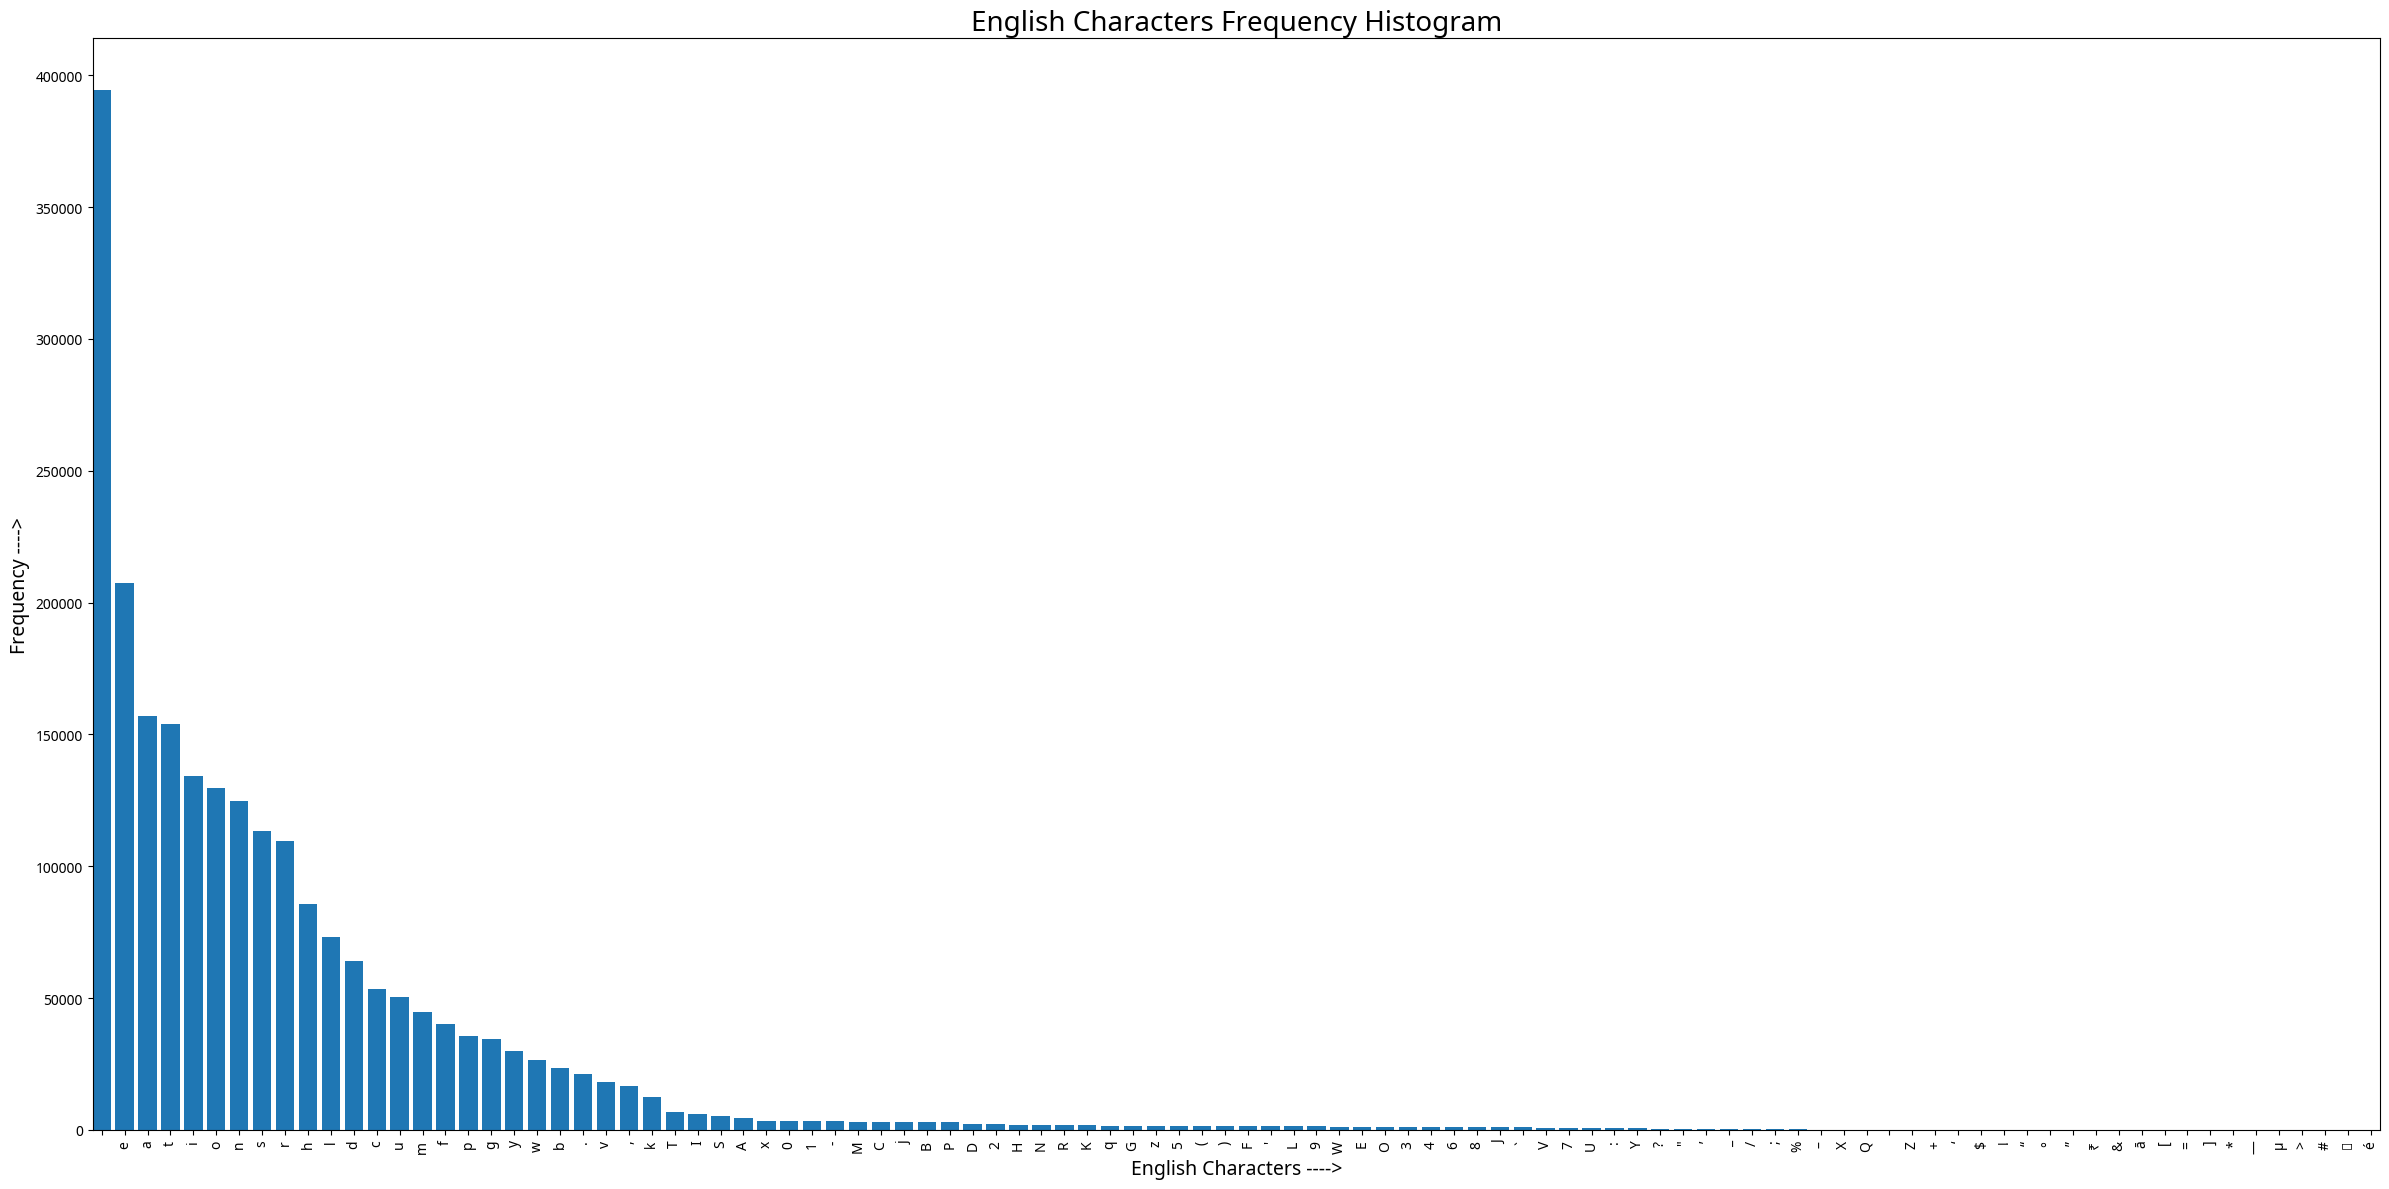

In [533]:
des_eng_char=Counter((" ".join(list(des["source"]))))
print("Unique English Characters:",len(des_eng_char))
plot_top(des_eng_char.most_common(100),"English Characters")

### Sentence Length

Average English Sentence Length: 17.084427117175654 words


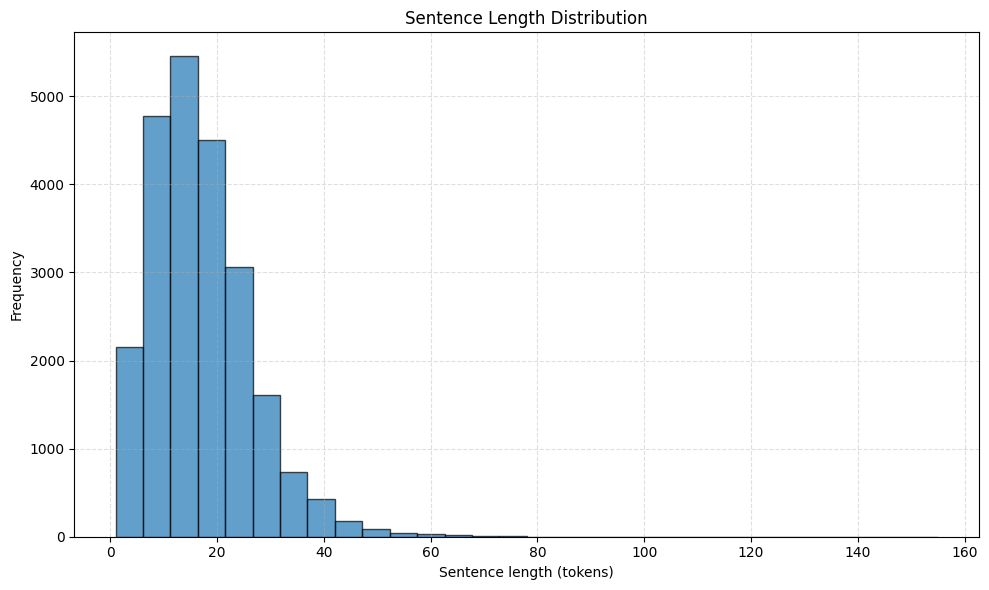

In [534]:
des_eng_sent=[len(sent.split()) for sent in des["source"]]
print("Average English Sentence Length:",sum(des_eng_sent)/len(des_eng_sent),"words")
plot_sentence_length_distribution(des_eng_sent)

In [535]:
print("Source sentence length entropy:",entropy(Counter(des_eng_sent)))

Source sentence length entropy: 5.101351674765164


### Numerals

Total Latin Script Numeral in dataset: 16783


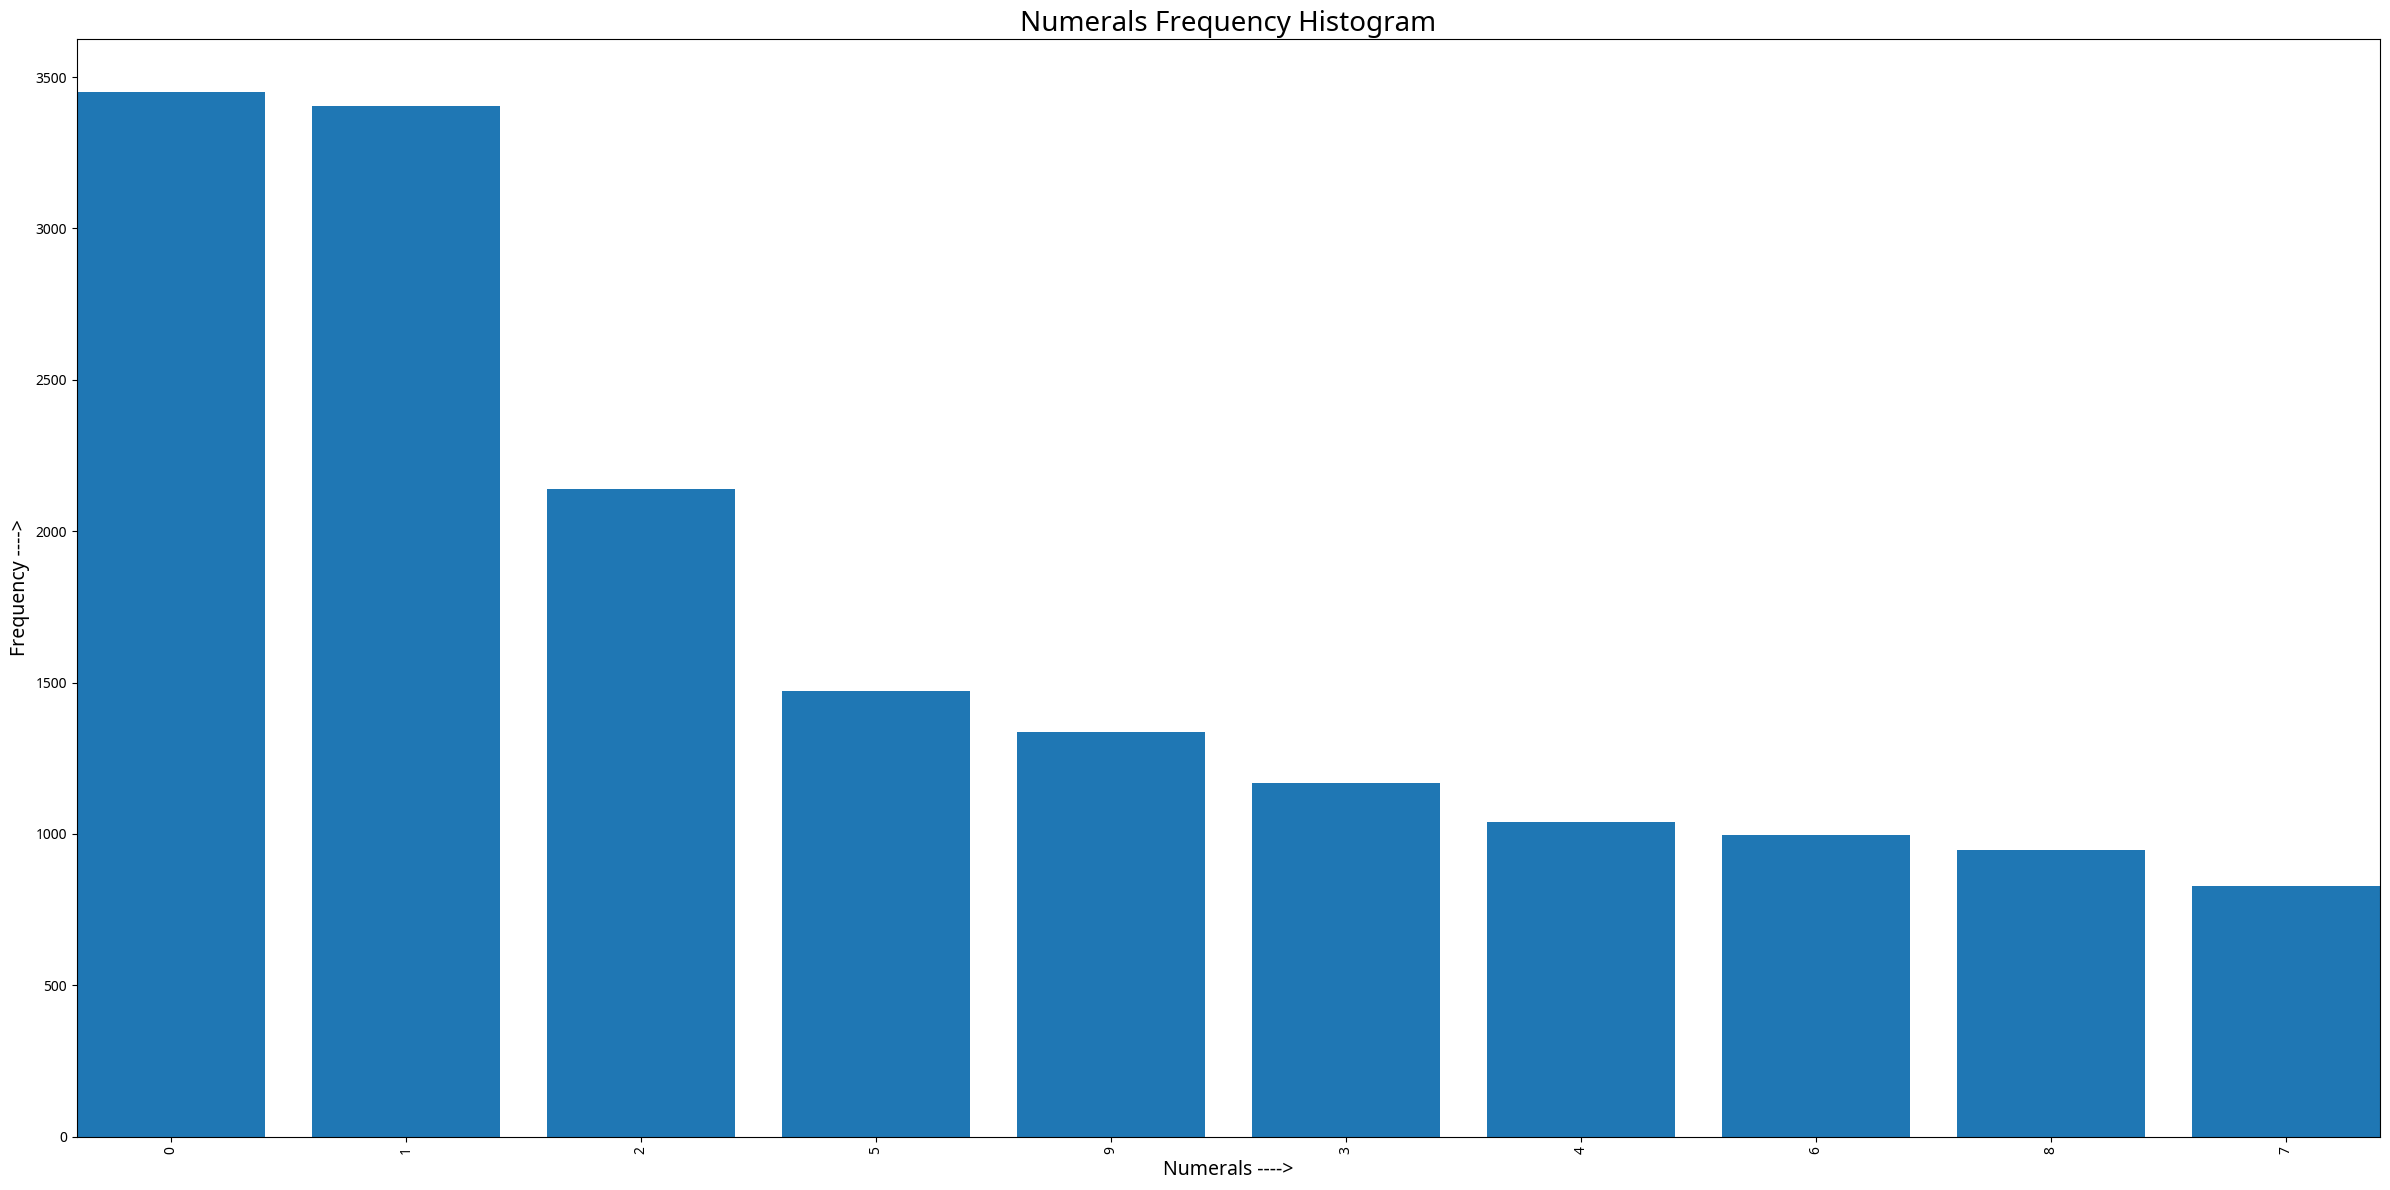

In [536]:
eng_digits = []
for sentence in des["source"]:
    eng_digits.extend(re.findall(r'[0-9]', sentence))  # find all single digits

# Build a frequency counter
eng_digits_counter = Counter(eng_digits)
print("Total Latin Script Numeral in dataset:",sum(eng_digits_counter.values()))
plot_top(eng_digits_counter.most_common(),"Numerals")